# **BrainStation Capstone Project**   

---



### **Airbnb Price Prediction in NYC** 

Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 1 of 4

###**Why do Airbnb listings in NYC matter a lot?**


“*Airbnbs Outnumber New York City Apartments in Hot Market*”, the headline from the Bloomberg
article published on May 18th, 2022, summarizes the impact of Airbnb apartments in the NYC rental market lately. Even though there are criticisms regarding the influence of Airbnb listing prices on the higher rental
prices in the city, others believe that it is mainly a chicken-egg situation in which it is difficult to decide
whether higher Airbnb listing prices or higher property rental prices emerged first. Inspired by these
articles, the following project questions emerged: What are the other determinants behind
Airbnb listing prices, and can we predict the prices using machine learning techniques? Basically, this
project is going to identify the determinants behind Airbnb hosts’ pricing strategy better and predict the
listing prices in NYC. The goal of the project is to increase the ROI in the existing and new listings. This project will also include newly engineered features originating
from neighborhoods, listing titles, and descriptions that are expected to contribute to the price
prediction.

**Data Collection and Data Dictionary**

The dataset was available in a tabular CSV.GZ format on Inside Airbnb. The dataset consisted of 37,410
observations and 74 mixed columns which refer to vacation rental description, geographic information,
review score, and host-related features. The data types in the datasets were object, numeric, date, and
boolean. 

### ▶ **NOTEBOOK 1: EXPLORATORY DATA ANALYSIS**


---



In this notebook we are going to explore each variable including its distribution, datatype and its relationship with one another. During this process, we will complete the following steps:
- Data cleaning (Handling the missing values)
- Feature engineering (Binning)
- Capping (Winsorization) or removing outliers
- Preventing multicollinearity issue by using VIF and correlation heatmap techniques.


Highlights of the Notebook:

- The original dataset was reduced by 15% due to the missing values. The final dataset consists of 31384 observation points and 33 independent features and a target variable.

- 30 variables including the target variable are examined. 

- The average overall rating score for NYC listing is 4.62 out of 5. 

- Majority of the hosts respond the messages within an hour.

- 21% of the hosts earned their superhost status by meeting, and often exceeding, guest expectations according to Airbnb.

- Almost half of the listings are based in Manhattan Borough.

- Neighborhoods with the highest number of listings are Midtown                (300), Hell's Kitchen (207), Harlem (169),Upper West Side (163), and Upper East Side (139).

- Majority of the listings allow 2-3 accommodates.

- A decline observed in the host registration since 2015.

- The rental listing prices vary a lot. There were even apartments at more than 10K per night. Since we failed to identify any pattern between highlyl priced listings and other variables, we have decided to cap the outliers which were around 8% of the data. All the prices were under 410. Manhattan mean price per night dropped by 23% while other neighborhoods reduced by between 7 and 12%. After using Winsorization technique to treat the outliers, the mean prices per night are as follows in US dollars:
  - 200 usd/per night in Manhattan
  - 141 usd/per night in Brooklyn
  - 125 usd/per night in Staten Island
  - 116 usd/per night in Queens
  - 110 usd/per night in Bronx

- `shared_bathroom` and `accommodates` have moderate or higher correlation with the target feature(price).



Some of the newly engineered features: 

- `host_verification_work_email`: It is created to identify whether listings verified via work email because we believe that the price may vary when the rental property is listed by professional companies or individuals. 

- `number of listing per neighborhood`: The competition tend to influence a listing's price too.

- Most of the attractions are located in Manhattan area and therefore the listings closer to Manhattan may be available at a higher price. Therefore we leveraged the domain knowledge and grouped the neighborhoods closer to Manhattan. 

- Furthermore the neighborhoods in Manhattan were grouped accordingly:

  - `neigh_harlem_manhattan`: Harlem and nearby neighborhoods tend to have a higher crime rate based on NYC Crime Index Open data included in the appendix file.
  - `neigh_central_park_manhattan`: Neighborhoods around Central Park including Upper East Side etc (from 59th street)
  - `neigh_midtown_west_manhattan`: 5th avenue and west from 34th street to 59th street
  - `neigh_midtown_east_manhattan`: 5th avenue and east from 34th street to 59th street
  - `neigh_midtown_south_manhattan`: 14th street to 34th street
  - `neigh_lower_manhattan`: South of 14th street

Installing required packages:

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 6.3 MB 40.6 MB/s 
     |████████████████████████████████| 16.7 MB 337 kB/s 


In [ ]:
# Import required libraries

%pylab inline
%config InlineBackend.figure_formats = ['retina']


# Import required libraries
import gzip
import shutil

import numpy as np
import pandas as pd


# Plotting
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Mapping
import geopandas as gpd

# Filling missing values or outliers
from sklearn.impute import KNNImputer
import scipy.stats as st


# Addressing multicollinearity issue
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Clustering 
from sklearn.cluster import KMeans

# Pipeline 
from tempfile import mkdtemp
cachedir = mkdtemp()
from sklearn.pipeline import Pipeline


# Seed number
seed=42


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Create a seaborn countplot function, which counts the observations in each categorical bin using bar.
def perc_graph (variable, dataset, title):
    sns.set_style("white")    #have a white background
      # set plot dimensions
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(x=variable, data=dataset, palette="Set2") #define the x and y axis and decide the color set
    plt.title(title + ' Distribution')
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    
    for i in axis.patches:   #create patches to calculate the percentage of each column
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn scatterplot graph function with hue=price to examine the distribution of disease presence in the selected variables
def scatter(dataset, variable_x, variable_y):
    sns.set_style("white")
    sns.scatterplot(x=dataset[variable_x],y=dataset[variable_y],hue=dataset['price'],palette="Set3")


#Create a seaborn countplot function with hue=WMNV to examine the disease presense distribution in the selected variable
def hue_graph(variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(8,8))
    Y= dataset[variable]
    total=len(Y)
    axis=sns.countplot(x=variable, data=dataset, hue="price", palette="Set3", order = dataset[variable].value_counts().index)
    plt.title(title, fontsize=15)
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    for i in axis.patches:
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn horizantal bar graph
def barh_graph (variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(15,5))  #graph size
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(y=variable, data=dataset, palette="Set3", order = dataset[variable].value_counts().index) #defining the axis x and y  #sns refers to the statistical graph
    plt.title(title + ' Distribution', fontsize=15)
    plt.xlabel('Number of Instances')
    plt.ylabel(variable, size=12)
    plt.show()

    
#Create a kernel density estimate (KDE) seaborn plot to illustrate the distribution of all the mosquitoes caught in a single trap.
def kde(variable, dataset, title):
    sns.set(rc={"figure.figsize":(9, 6)})
    sns.kdeplot(data=dataset, x=variable, shade=True, color="r").set(title=title +' Density', xlabel=variable )
    
    
#Create a seaborn line plot to display the evaluation of one numerical variable over time so variable_x is going to be labeled with numerical columns including time values. 
def line(variable_x, variable_y, dataset, title):
    sns.set(rc={"figure.figsize":(8, 8)})
    sns.lineplot(x = variable_x, y = variable_y, data = dataset).set(title=title, ylabel=variable_y, xlabel=variable_x,)
    plt.xticks(rotation = 25)   #rotate the x axis values

def scatter(x,y,dataset,title):
    sns.scatterplot(x=dataset[x], y=dataset[y], data=dataset, color="g", alpha=0.5)
    plt.xlabel(x,size=12)
    plt.ylabel(y,size=12)
    plt.title(title +' Correlation', fontsize=15)
    plt.legend(loc='upper left')
    plt.show()
    

In [ ]:
# Outliers | Capping method

def df_outliers(col, dataframe):
    Q1 = np.percentile(dataframe[col] , 25)
    Q3 = np.percentile(dataframe[col] , 75)

    # 2.
    Q1,Q3 = np.percentile(dataframe[col] , [25,75])

   # Find IQR, upper limit, lower limit
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR

    # Find outliers
    outliers = dataframe[col][(dataframe[col]> ul) | (dataframe[col]< ll)]
    outliers=outliers.to_frame()
    print(outliers.describe())



def capping(col,df, q1,q2):
    q_l = df[col].quantile(q1)
    q_h = df[col].quantile(q2)

    df[col] = df[col].clip(lower = q_l, upper = q_h)

    fig = plt.figure(figsize =(10, 7))
 
    plt.boxplot(df[col])
    plt.title(col)
    # show plot
    plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!ls "/content/drive/My Drive"



Mounted at /content/drive
 Acarlioglu_Aslinur_Resume.gdoc
 additional_sources
'BOA Statements'
 boston.csv.gz
'Brainstation Capstone'
'Colab Notebooks'
'Copy of Copy of Resume Template #1.gdoc'
'Copy of Goal Setting Activity Worksheet.gslides'
'Copy of Sprint Plan Template.gslides'
 dc.csv.gz
 df_preprocessed_capped.csv
 df_recommender.csv
 june_listings.csv.gz
 june_reviews.csv.gz
 neighbourhoods.geojson
'Resume without capstone.gdoc'
'without projects.gdoc'
 X_test.csv
 X_train.csv
 X_validation.csv
 y_test.csv
 y_train.csv
 y_validation.csv


In [ ]:
# Inspect the raw listing dataset
data = pd.read_csv('drive/My Drive/Brainstation Capstone/june_listings.csv.gz',compression='gzip',header=0, sep=',', quotechar='"')
print(data)

                       id                                      listing_url  \
0                    2595                https://www.airbnb.com/rooms/2595   
1                    5121                https://www.airbnb.com/rooms/5121   
2                    5136                https://www.airbnb.com/rooms/5136   
3                    5178                https://www.airbnb.com/rooms/5178   
4                    5203                https://www.airbnb.com/rooms/5203   
...                   ...                                              ...   
37405  640612171111039003  https://www.airbnb.com/rooms/640612171111039003   
37406  640629990855220048  https://www.airbnb.com/rooms/640629990855220048   
37407  640658348674867448  https://www.airbnb.com/rooms/640658348674867448   
37408  641072234133563797  https://www.airbnb.com/rooms/641072234133563797   
37409  641241352138040023  https://www.airbnb.com/rooms/641241352138040023   

            scrape_id last_scraped  \
0      20220603182654   2

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Unzip listing data file and convert it to csv
with gzip.open('drive/My Drive/Brainstation Capstone/june_listings.csv.gz', 'rb') as f_in:
    with open('june_listings.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [ ]:
# Convert csv file to a dataframe and name it.

df_listing=pd.read_csv('june_listings.csv')
df_listing.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20220603182654   2022-06-04   
1  5121  https://www.airbnb.com/rooms/5121  20220603182654   2022-06-04   
2  5136  https://www.airbnb.com/rooms/5136  20220603182654   2022-06-04   
3  5178  https://www.airbnb.com/rooms/5178  20220603182654   2022-06-04   
4  5203  https://www.airbnb.com/rooms/5203  20220603182654   2022-06-03   

                                       name  \
0                     Skylit Midtown Castle   
1                           BlissArtsSpace!   
2  Spacious Brooklyn Duplex, Patio + Garden   
3          Large Furnished Room Near B'way　   
4        Cozy Clean Guest Room - Family Apt   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
1  One room available for rent in a 2 bedroom apt...   
2  We welcome you to stay in our lovely 2 br dupl...   
3  Please don’t expect the luxury here just a bas...   
4  Our best guests are seeking a safe, clean, spa...   

                               neighborhood_overview  \
0  Centrally located in the heart of Manhattan ju...   
1                                                NaN   
2                                                NaN   
3    Theater district, many restaurants around here.   
4  Our neighborhood is full of restaurants and ca...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/f0813a11-40b2...     2845   
1  https://a0.muscache.com/pictures/2090980c-b68e...     7356   
2  https://a0.muscache.com/pictures/miso/Hosting-...     7378   
3  https://a0.muscache.com/pictures/12065/f070997...     8967   
4  https://a0.muscache.com/pictures/103776/b37157...     7490   

                                 host_url  ... review_scores_communication  \
0  https://www.airbnb.com/users/show/2845  ...                        4.79   
1  https://www.airbnb.com/users/show/7356  ...                        4.91   
2  https://www.airbnb.com/users/show/7378  ...                        5.00   
3  https://www.airbnb.com/users/show/8967  ...                        4.44   
4  https://www.airbnb.com/users/show/7490  ...                        4.95   

  review_scores_location review_scores_value license instant_bookable  \
0                   4.86                4.41     NaN                f   
1                   4.47                4.52     NaN                f   
2                   4.50                5.00     NaN                f   
3                   4.87                4.39     NaN                f   
4                   4.94                4.92     NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              3                                           3   
1                              2                                           0   
2                              1                                           1   
3                              1                                           0   
4                              1                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            2   
2                                            0   
3                                            1   
4                                            1   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.31  
1                                           0              0.32  
2                                           0              0.02  
3                                           0              3.37  
4                                           0              0.76  

[5 rows x 74 columns]

In [ ]:
# df_listing data summary:

print(f"The shape of df_listing is {df_listing.shape}")
print(f"There are {df_listing.isna().sum().sum()} missing values in the df_listing dataset")
print(f"There are {df_listing.duplicated().sum()} duplicated rows in the df_listing dataset")

The shape of df_listing is (37410, 74)
There are 292986 missing values in the df_listing dataset
There are 0 duplicated rows in the df_listing dataset


**GENERAL INSIGHTS ABOUT THE DATASET:**

In this dataset we find variables about host, rental property, review scores, and listing details:

In [ ]:
# Columns and details
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37410 entries, 0 to 37409
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37410 non-null  int64  
 1   listing_url                                   37410 non-null  object 
 2   scrape_id                                     37410 non-null  int64  
 3   last_scraped                                  37410 non-null  object 
 4   name                                          37396 non-null  object 
 5   description                                   36523 non-null  object 
 6   neighborhood_overview                         22430 non-null  object 
 7   picture_url                                   37410 non-null  object 
 8   host_id                                       37410 non-null  int64  
 9   host_url                                      37410 non-null 

In [ ]:
df_listing.describe().T

count          mean  \
id                                            37410.0  6.100385e+16   
scrape_id                                     37410.0  2.022060e+13   
host_id                                       37410.0  1.237140e+08   
host_listings_count                           37344.0  6.381151e+01   
host_total_listings_count                     37344.0  6.381151e+01   
latitude                                      37410.0  4.072931e+01   
longitude                                     37410.0 -7.394617e+01   
accommodates                                  37410.0  2.904918e+00   
bathrooms                                         0.0           NaN   
bedrooms                                      33756.0  1.354219e+00   
beds                                          36509.0  1.634720e+00   
minimum_nights                                37410.0  1.976399e+01   
maximum_nights                                37410.0  5.909123e+04   
minimum_minimum_nights                        37395.0  2.040741e+01   
maximum_minimum_nights                        37395.0  2.752614e+01   
minimum_maximum_nights                        37395.0  1.552375e+06   
maximum_maximum_nights                        37395.0  3.390048e+06   
minimum_nights_avg_ntm                        37395.0  2.698508e+01   
maximum_nights_avg_ntm                        37395.0  2.318962e+06   
calendar_updated                                  0.0           NaN   
availability_30                               37410.0  4.698931e+00   
availability_60                               37410.0  1.279260e+01   
availability_90                               37410.0  2.352096e+01   
availability_365                              37410.0  1.197049e+02   
number_of_reviews                             37410.0  2.634787e+01   
number_of_reviews_ltm                         37410.0  7.248142e+00   
number_of_reviews_l30d                        37410.0  7.569901e-01   
review_scores_rating                          29461.0  4.615201e+00   
review_scores_accuracy                        28982.0  4.748894e+00   
review_scores_cleanliness                     28992.0  4.626467e+00   
review_scores_checkin                         28978.0  4.815760e+00   
review_scores_communication                   28987.0  4.807910e+00   
review_scores_location                        28975.0  4.747036e+00   
review_scores_value                           28975.0  4.649349e+00   
calculated_host_listings_count                37410.0  1.511478e+01   
calculated_host_listings_count_entire_homes   37410.0  9.396685e+00   
calculated_host_listings_count_private_rooms  37410.0  5.600508e+00   
calculated_host_listings_count_shared_rooms   37410.0  5.126971e-02   
reviews_per_month                             29461.0  1.166622e+00   

                                                       std           min  \
id                                            1.806040e+17  2.595000e+03   
scrape_id                                     0.000000e+00  2.022060e+13   
host_id                                       1.382397e+08  2.438000e+03   
host_listings_count                           4.003326e+02  0.000000e+00   
host_total_listings_count                     4.003326e+02  0.000000e+00   
latitude                                      5.804081e-02  4.050456e+01   
longitude                                     5.670141e-02 -7.426952e+01   
accommodates                                  1.964525e+00  0.000000e+00   
bathrooms                                              NaN           NaN   
bedrooms                                      7.340384e-01  1.000000e+00   
beds                                          1.148007e+00  1.000000e+00   
minimum_nights                                3.277133e+01  1.000000e+00   
maximum_nights                                1.110384e+07  1.000000e+00   
minimum_minimum_nights                        4.098996e+01  1.000000e+00   
maximum_minimum_nights                        7.935138e+01  1.00000

Text(0.5, 0.95, 'Numerical Features Distributions')

<Figure size 432x288 with 0 Axes>

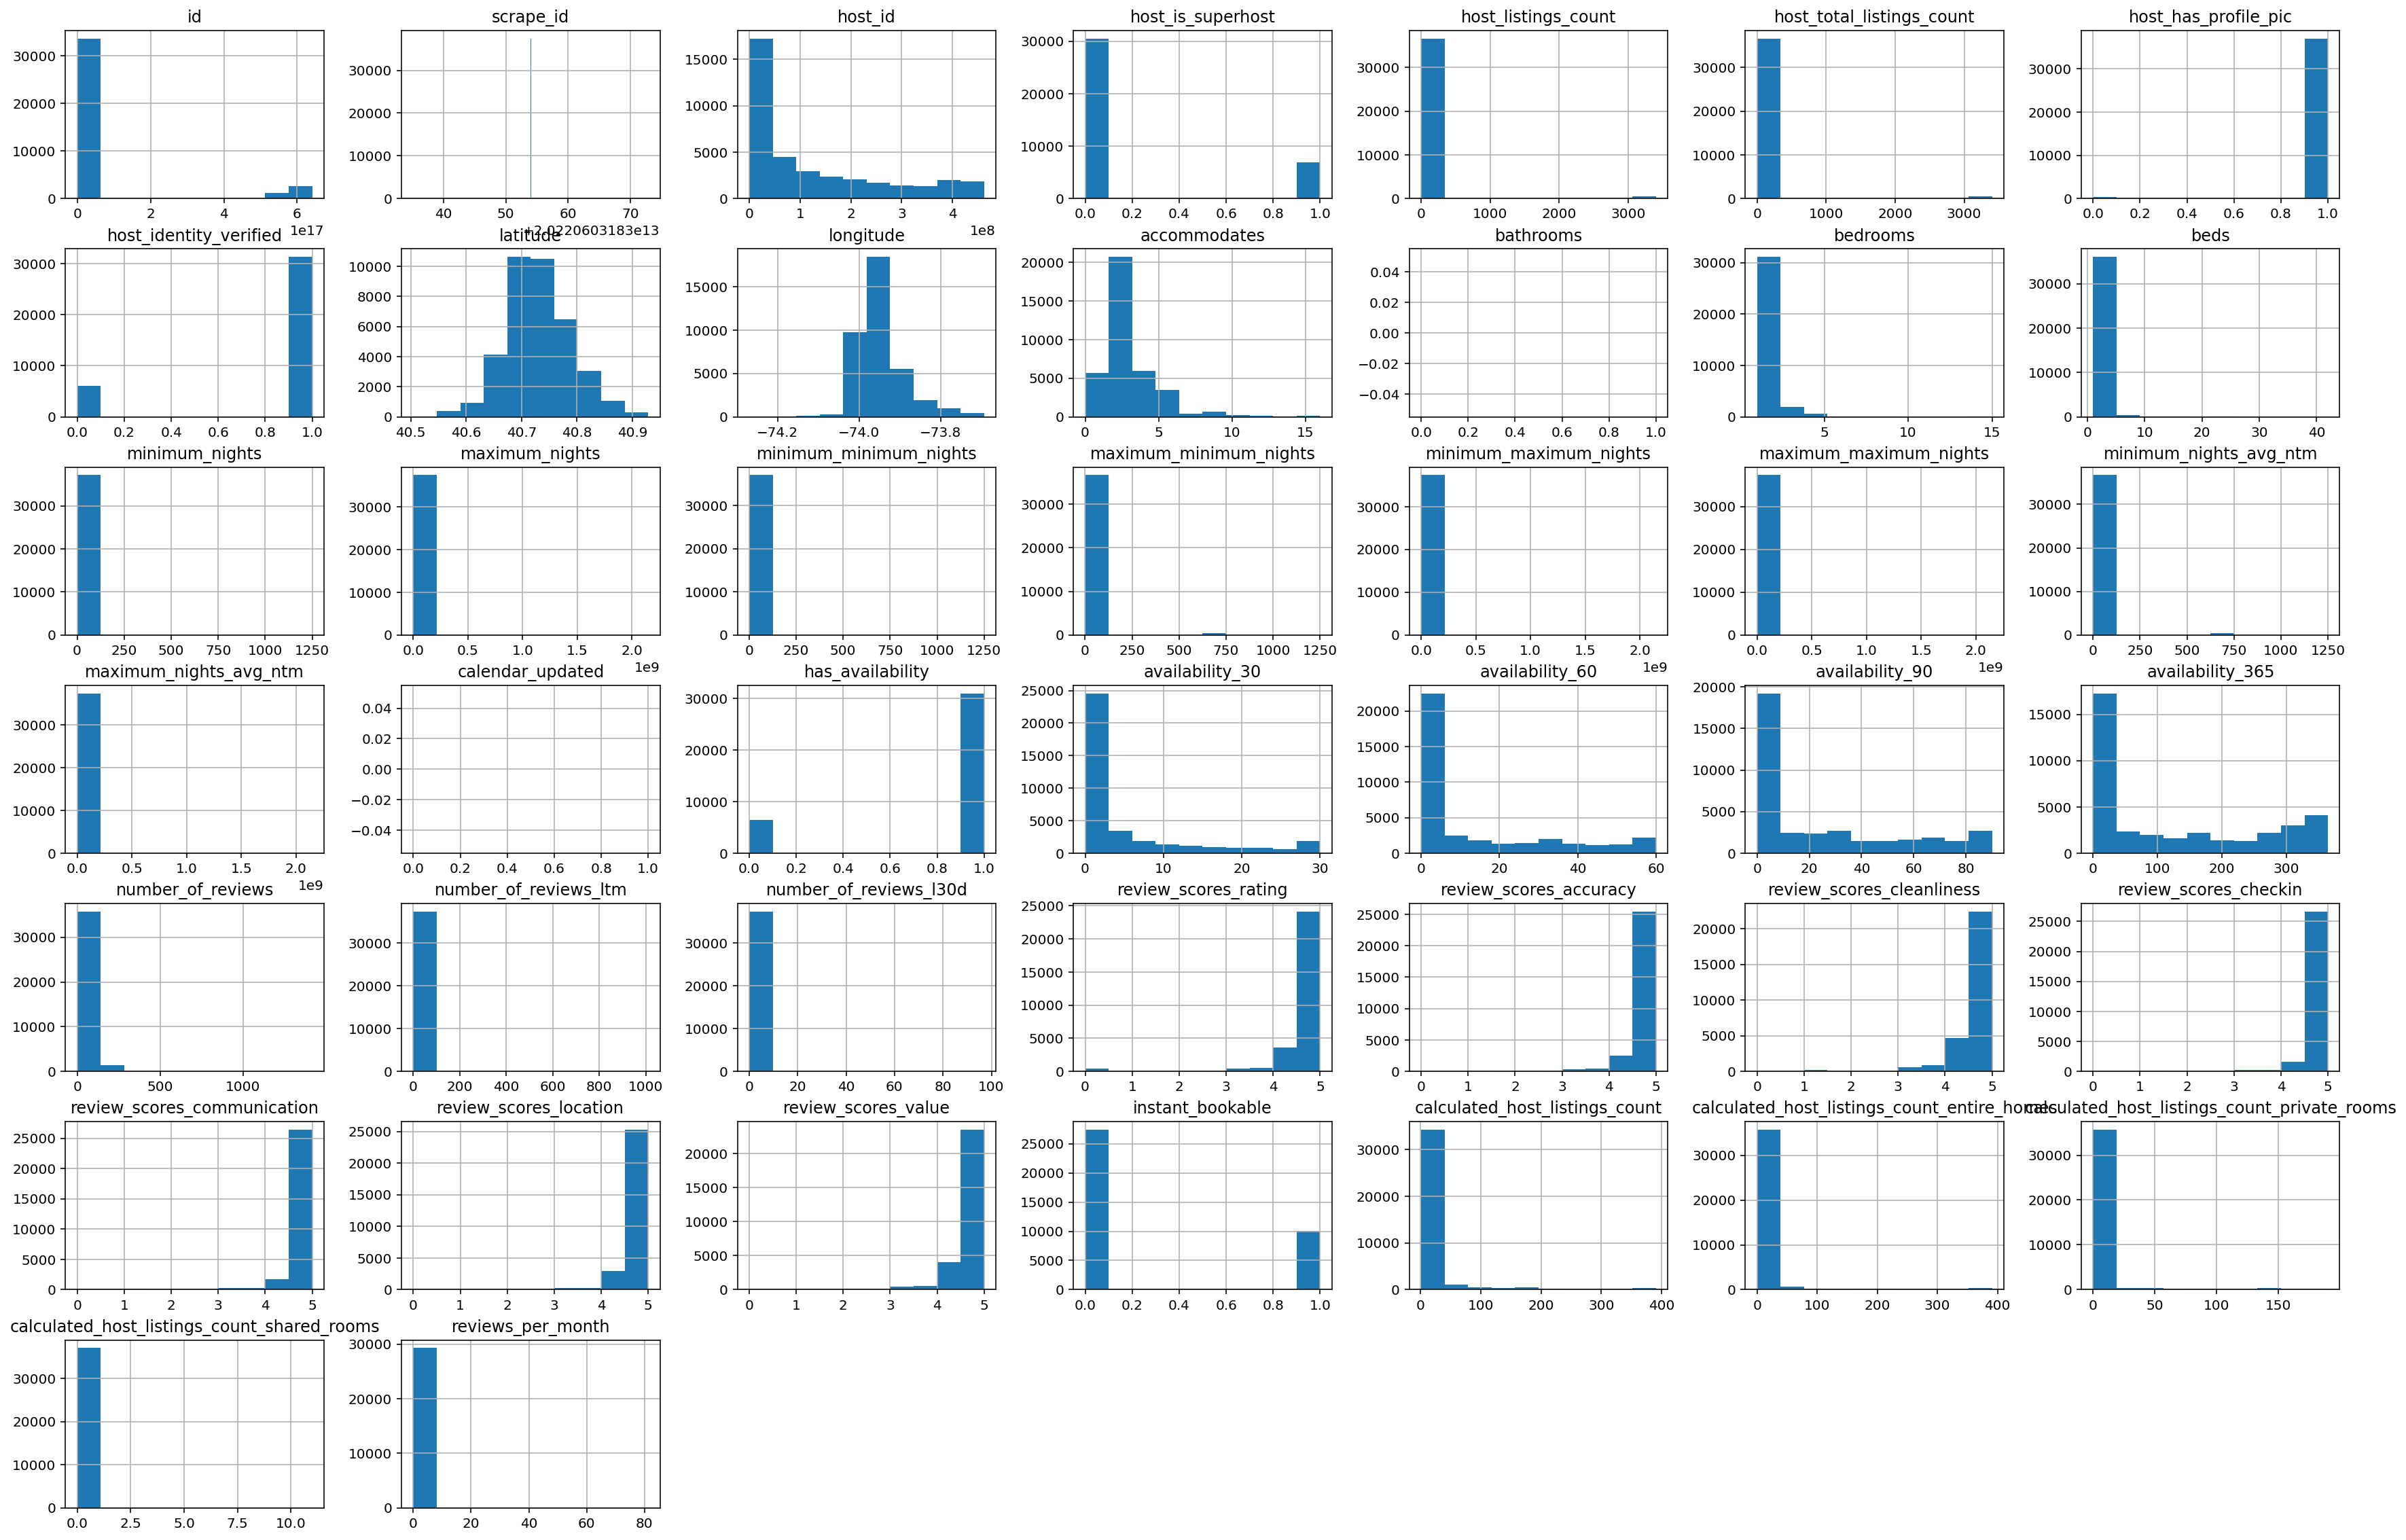

In [ ]:
# Convert boolean values to numeric
df_listing.replace({'f': 0, 't': 1}, inplace=True)
df_listing_num=df_listing.select_dtypes(include='number')
# Plot the distribution of numerical and boolean categories
plt.figure()
df_listing_num.hist(figsize=(30,20));
plt.title("Numerical Features Distributions", fontsize=18, y=0.95)


General insights from the plots of the numerical and boolean variables above:

1.   The range of each variable varies.    
2.   Review Score columns are left skewed and includes more positive reviews
3.   Availability colums are right skewed and are mostly less than 10.
4.   Majority of the hosts are not superhost
5.   Most of the listing are bookable instantly.
6.   Almost all listings have less than 5 bedrooms.
7.   Majority of the listings allow 2 accommodates.

Correlation Heatmap between features and target variable:

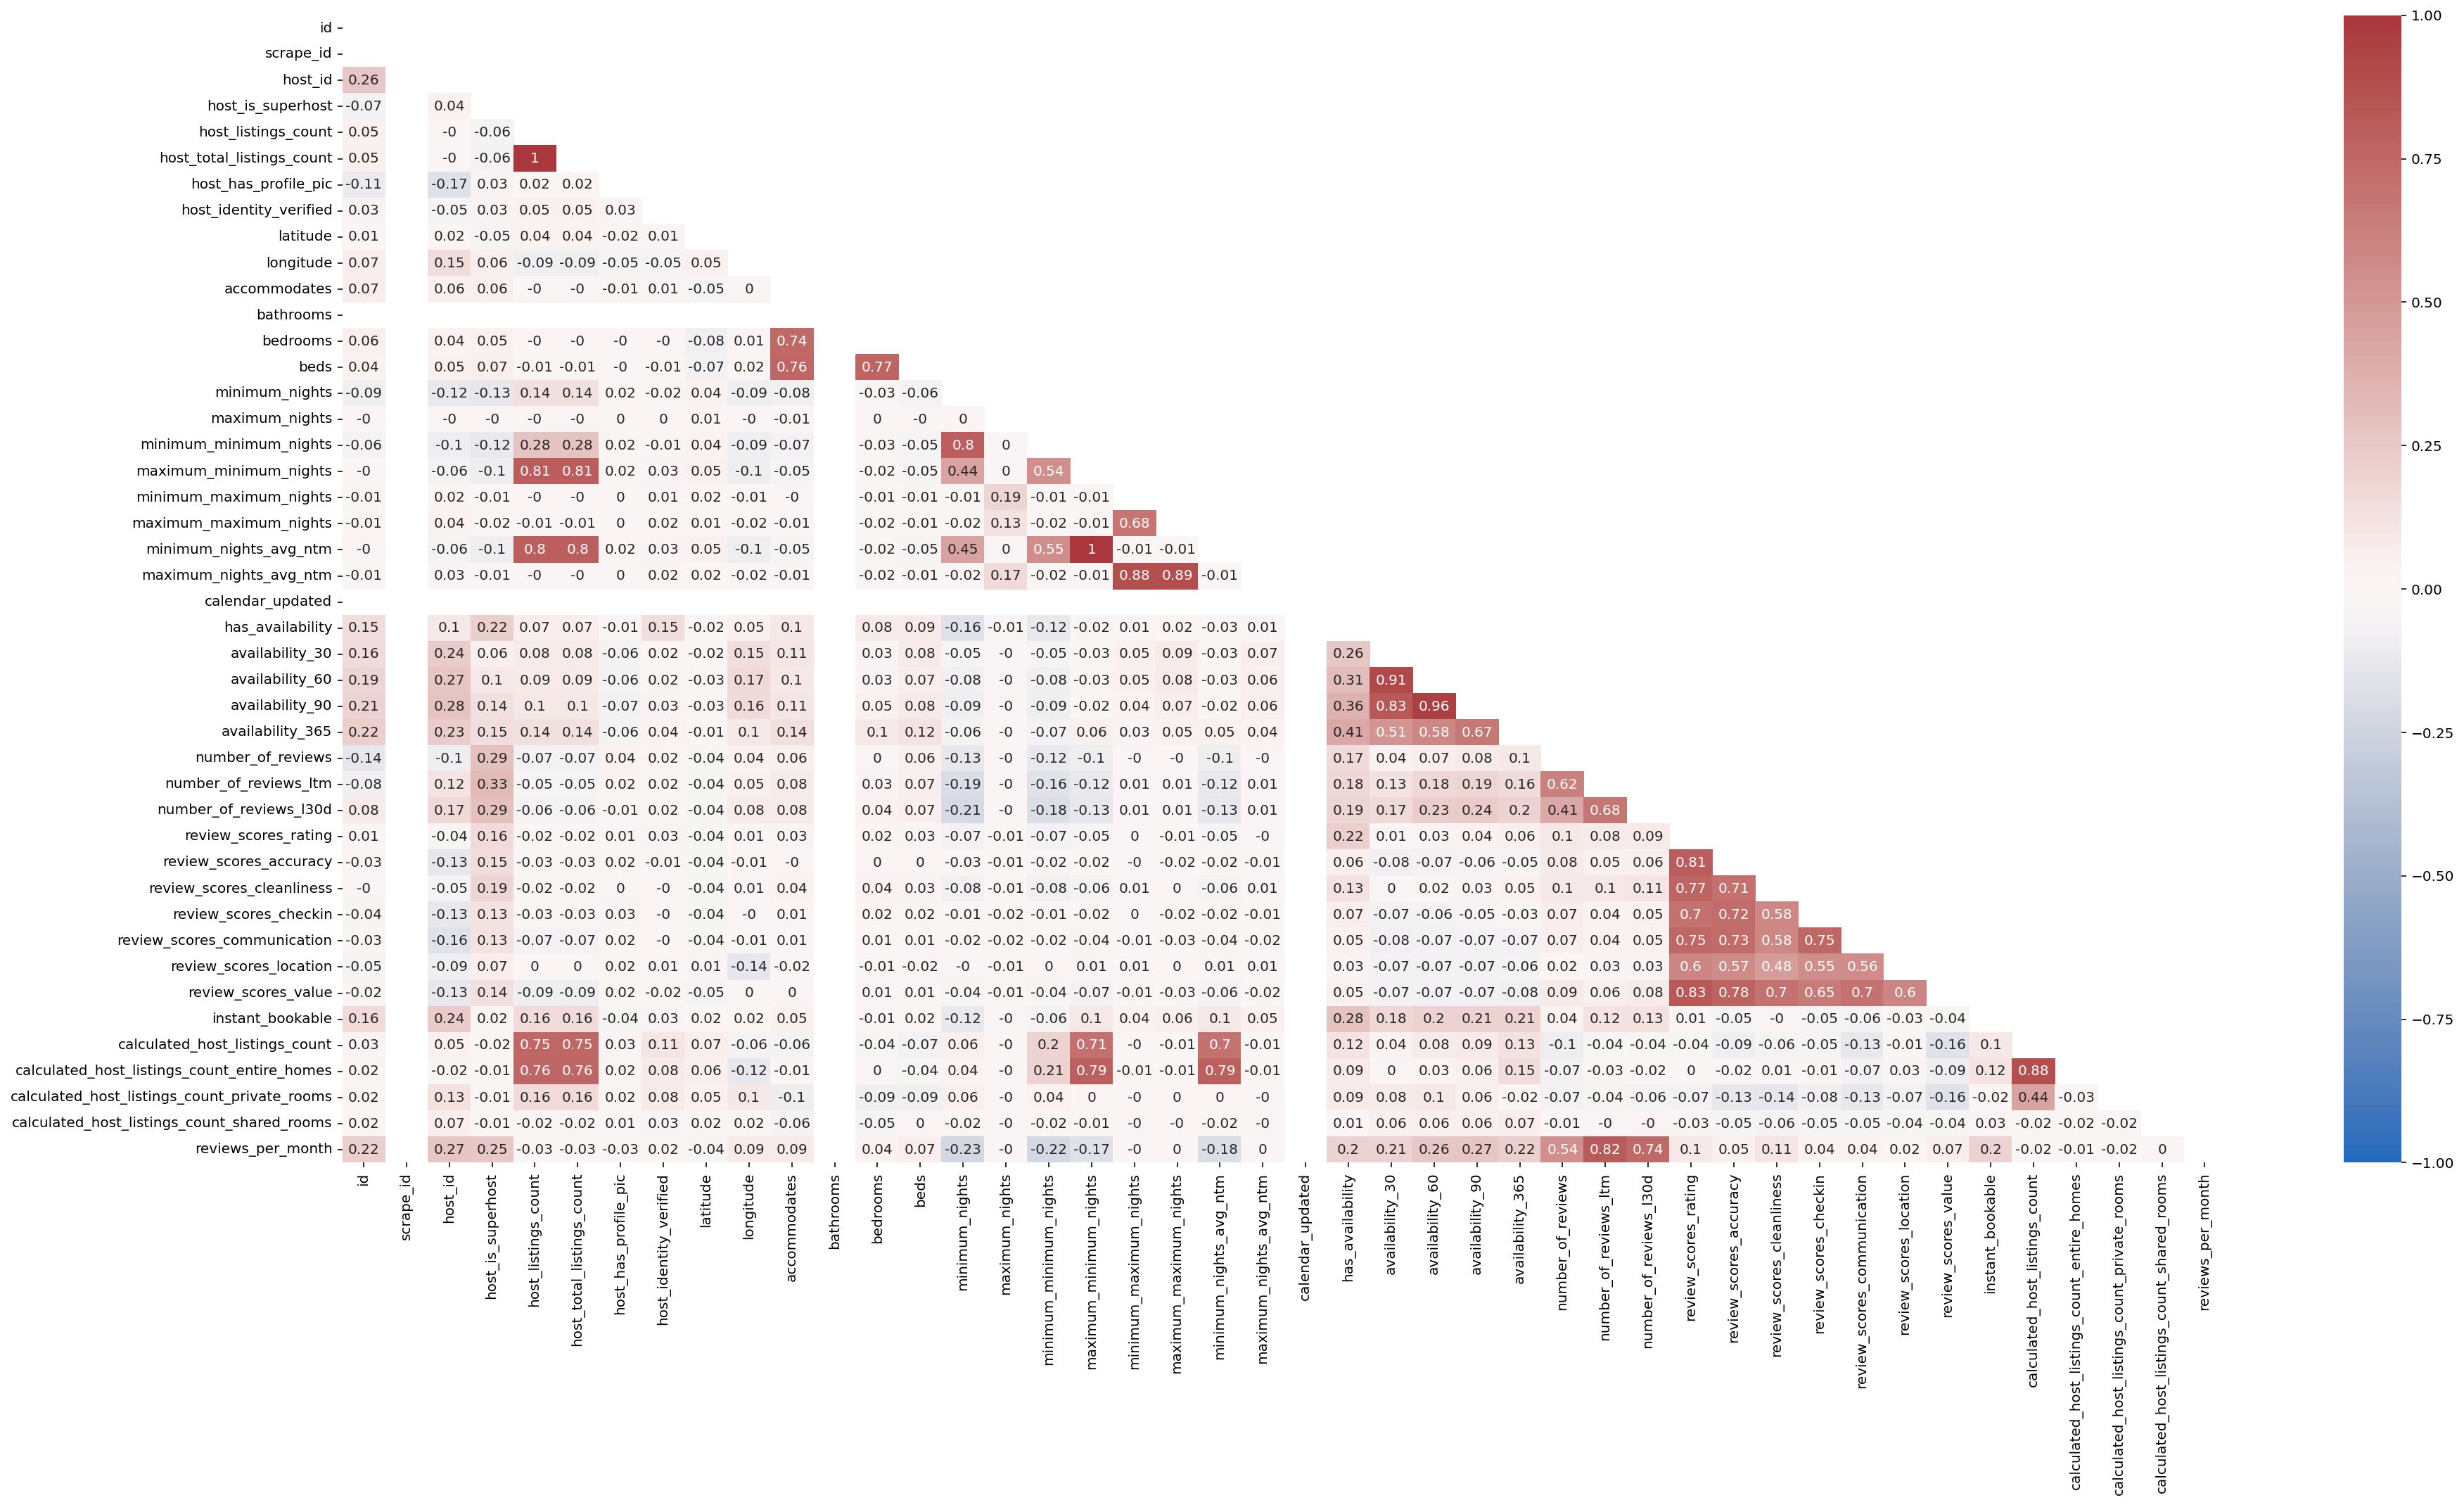

In [ ]:
matrix = df_listing.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(30,15))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()




*   There are redundant columns such as minimum_nights and minimum_minimum_nights. Therefore they look highly correlated.
*   Irrelevant/unnecessary columns should be dropped.


*   Review scores are highly correlated in a positive way. 
*   Bedrooms and accommodates columns are positively correlated too which was expected.
*   We may also need to drop some columns to prevent multicollinearity issue.

Let's take a quick look at some columns closely:

Review scores: 
*   Majority of the reviews are positive. 
*   There are zero review scores. 
The mean of review score types from lowest to highest:
  - The mean rating review score is 4.62  | it refers to the overall review score. 
  - The mean cleanliness review score is 4.63
  - The mean value review score is 4.65  | is given based on the price of the listing so it should have a relationship with our target value.
  - The mean accuracy review score is 4.75
  - The mean location review score is 4.75
  - The mean communication review score is 4.81 | the hosts seem to respond messages on time.
  - The mean check-in review score is 4.82












In [ ]:
df_listing[df_listing.columns[df_listing.columns.str.contains('review_scores')]].describe()

review_scores_rating  review_scores_accuracy  \
count          29461.000000            28982.000000   
mean               4.615201                4.748894   
std                0.759865                0.471923   
min                0.000000                0.000000   
25%                4.590000                4.710000   
50%                4.830000                4.900000   
75%                5.000000                5.000000   
max                5.000000                5.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               28992.000000           28978.000000   
mean                    4.626467               4.815760   
std                     0.549928               0.416488   
min                     0.000000               0.000000   
25%                     4.500000               4.800000   
50%                     4.800000               4.950000   
75%                     5.000000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                 28987.000000            28975.000000   
mean                      4.807910                4.747036   
std                       0.443218                0.405745   
min                       0.000000                0.000000   
25%                       4.800000                4.670000   
50%                       4.960000                4.860000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  
count         28975.000000  
mean              4.649349  
std               0.497136  
min               0.000000  
25%               4.560000  
50%               4.780000  
75%               4.970000  
max               5.000000

In [ ]:
# Quick look at first_review column
df_listing.first_review.head(10)

0    2009-11-21
1    2009-05-28
2    2014-01-02
3    2009-05-06
4    2009-09-07
5    2009-05-08
6    2009-04-23
7    2009-05-25
8           NaN
9    2009-10-28
Name: first_review, dtype: object

In [ ]:
# Quick look at neighborhood_overview column
df_listing.neighborhood_overview

0        Centrally located in the heart of Manhattan ju...
1                                                      NaN
2                                                      NaN
3          Theater district, many restaurants around here.
4        Our neighborhood is full of restaurants and ca...
                               ...                        
37405                                                  NaN
37406                                                  NaN
37407                                                  NaN
37408    This rental is located in NYC’s East Village. ...
37409                                                  NaN
Name: neighborhood_overview, Length: 37410, dtype: object

In [ ]:
# Quick look at beds column
df_listing.beds

0        1.0
1        1.0
2        2.0
3        1.0
4        1.0
        ... 
37405    4.0
37406    4.0
37407    2.0
37408    1.0
37409    1.0
Name: beds, Length: 37410, dtype: float64

In [ ]:
df_listing.property_type 

0                 Entire rental unit
1        Private room in rental unit
2                 Entire rental unit
3        Private room in rental unit
4        Private room in rental unit
                    ...             
37405             Entire rental unit
37406               Entire townhouse
37407    Private room in rental unit
37408             Entire rental unit
37409                   Entire condo
Name: property_type, Length: 37410, dtype: object

In [ ]:
df_listing.room_type                    

0        Entire home/apt
1           Private room
2        Entire home/apt
3           Private room
4           Private room
              ...       
37405    Entire home/apt
37406    Entire home/apt
37407       Private room
37408    Entire home/apt
37409    Entire home/apt
Name: room_type, Length: 37410, dtype: object

In [ ]:
 # Another unneccasary column
 df_listing.neighbourhood

0        New York, United States
1                            NaN
2                            NaN
3        New York, United States
4        New York, United States
                  ...           
37405                        NaN
37406                        NaN
37407                        NaN
37408    New York, United States
37409                        NaN
Name: neighbourhood, Length: 37410, dtype: object

In [ ]:
df_listing.number_of_reviews_ltm


0         0
1         0
2         1
3        62
4         0
         ..
37405     0
37406     0
37407     0
37408     0
37409     0
Name: number_of_reviews_ltm, Length: 37410, dtype: int64

We believe that `host_response_time`, `host_response_rate`, `host_acceptance_rate` columns tend to influence the visitors when they leave a review. Furthermore, `review_scores` values may impact the host decision when determining their listing rates. However half of these columns below involve lots of N/A values. Before we decide to drop them, we will attempt to fill the missing values. 

For now we will only drop columns below as we think that they are redundant or irrelevant with the target variable which is `price`.

In [ ]:
# Columns to be dropped

drop_columns = ['host_name','neighbourhood','neighborhood_overview','listing_url', 'picture_url','scrape_id','last_scraped','bathrooms','calendar_updated','host_url','license',
                'host_neighbourhood','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
                'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_last_scraped']


In [ ]:
# drop the columns
df_listing=df_listing.drop(drop_columns, axis=1)

In [ ]:
# Let's check the missing values
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
host_about                             0.44
host_response_time                     0.35
host_response_rate                     0.35
host_acceptance_rate                   0.31
review_scores_value                    0.23
review_scores_location                 0.23
review_scores_checkin                  0.23
review_scores_accuracy                 0.23
review_scores_communication            0.23
review_scores_cleanliness              0.23
reviews_per_month                      0.21
review_scores_rating                   0.21
last_review                            0.21
first_review                           0.21
bedrooms                               0.10
beds                                   0.02
description                            0.02
host_location                          0.00
bathrooms_text                         0.00
host_has_profile_pic                   0.00
host_identity_verified                 0.00
host_total_listings_count              0.00
host_listings_count                    0.00
host_picture_url                       0.00
host_thumbnail_url                     0.00
host_is_superhost                      0.00
host_since                             0.00
name                                   0.00

Apparently there are 7949 listings with NaN review score and host related features, which correspond to 21% of the entire dataset. 

In [ ]:
# Extract the rows with only zero or NaN rows 
df_nan=df_listing[(df_listing.number_of_reviews==0) | (df_listing.number_of_reviews.isna())][['host_acceptance_rate','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review','last_review','host_since','price']]



In [ ]:
df_nan.shape

(7949, 22)

In [ ]:
# Select the NaN values in both review and host response related columns
df_listing[(df_listing['review_scores_communication'].isna()) & (df_listing['host_response_time'].isna())].shape

(4107, 55)

We will also drop the rows missing both host response time values and communication review scores which refer to 4107 rows or 11% of the entire dataset.

In [ ]:
# drop all the rows with lack of host response related and review scores.
df_listing.dropna(subset=['review_scores_communication', 'host_response_time'], how='all', inplace=True)
df_listing=df_listing.reset_index(drop=True)
df_listing.shape

(33303, 55)

Now we have left 33,303 rows. However we still have remaining missing values.

Let's check nan host response time and checkin review scores values too:

In [ ]:
df_listing[(df_listing['review_scores_checkin'].isna()) & (df_listing['host_response_time'].isna())].shape

(9, 55)

Only 9 rows so we can drop them too.

In [ ]:
# drop all the rows with lack of host response related and review scores.
df_listing.dropna(subset=['review_scores_checkin', 'host_response_time'], how='all', inplace=True)
df_listing.shape

(33294, 55)

In [ ]:
# Let's check the missing values
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
host_about                             0.42
host_response_time                     0.27
host_response_rate                     0.27
host_acceptance_rate                   0.24
review_scores_location                 0.13
review_scores_value                    0.13
review_scores_communication            0.13
review_scores_checkin                  0.13
review_scores_cleanliness              0.13
review_scores_accuracy                 0.13
reviews_per_month                      0.13
review_scores_rating                   0.13
last_review                            0.13
first_review                           0.13
bedrooms                               0.10
beds                                   0.02
description                            0.02
host_location                          0.00
bathrooms_text                         0.00
host_has_profile_pic                   0.00
host_identity_verified                 0.00
host_total_listings_count              0.00
host_listings_count                    0.00
host_picture_url                       0.00
host_thumbnail_url                     0.00
host_is_superhost                      0.00
host_since                             0.00
name                                   0.00

For EDA purposes, we are going to be keep the id & host_id columns:

**1.** `price`:  target value

In [ ]:
# remove the $ from the price and convert to float
df_listing['price']= df_listing['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

In [ ]:
# Sanity check
df_listing['price'].describe()

count    33294.000000
mean       190.669880
std        327.587526
min          0.000000
25%         77.000000
50%        127.000000
75%        210.000000
max      12900.000000
Name: price, dtype: float64

24 places are listed with zero prices.

In [ ]:
df_listing[df_listing.price==0].shape

(24, 55)

In [ ]:
# drop listings with zero price
df_listing=df_listing[df_listing.price!=0]

In [ ]:
# Quick look at the listings with less $50
df_listing[df_listing.price<50][['bedrooms','beds','price','host_since','room_type','neighbourhood_group_cleansed']]

bedrooms  beds  price  host_since     room_type  \
249         1.0   1.0   47.0  2011-07-11  Private room   
336         1.0   1.0   41.0  2011-10-07  Private room   
412         1.0   1.0   45.0  2011-11-28  Private room   
444         1.0   1.0   45.0  2011-10-15  Private room   
535         1.0   1.0   35.0  2011-12-23  Private room   
...         ...   ...    ...         ...           ...   
33203       1.0   1.0   39.0  2020-02-06  Private room   
33218       1.0   1.0   44.0  2015-03-21  Private room   
33232       1.0   1.0   47.0  2019-04-01  Private room   
33239       1.0   1.0   45.0  2016-09-29  Private room   
33251       1.0   1.0   36.0  2019-08-09  Private room   

      neighbourhood_group_cleansed  
249                          Bronx  
336                          Bronx  
412                         Queens  
444                       Brooklyn  
535                       Brooklyn  
...                            ...  
33203                       Queens  
33218                     Brooklyn  
33232                       Queens  
33239                        Bronx  
33251                     Brooklyn  

[2749 rows x 6 columns]

The listing the max price value. It seems outdated because the host has been active since


In [ ]:
df_listing[df_listing.price==12900][['bedrooms','beds','price','host_since']]

bedrooms  beds    price  host_since
17189       4.0   6.0  12900.0  2011-10-07

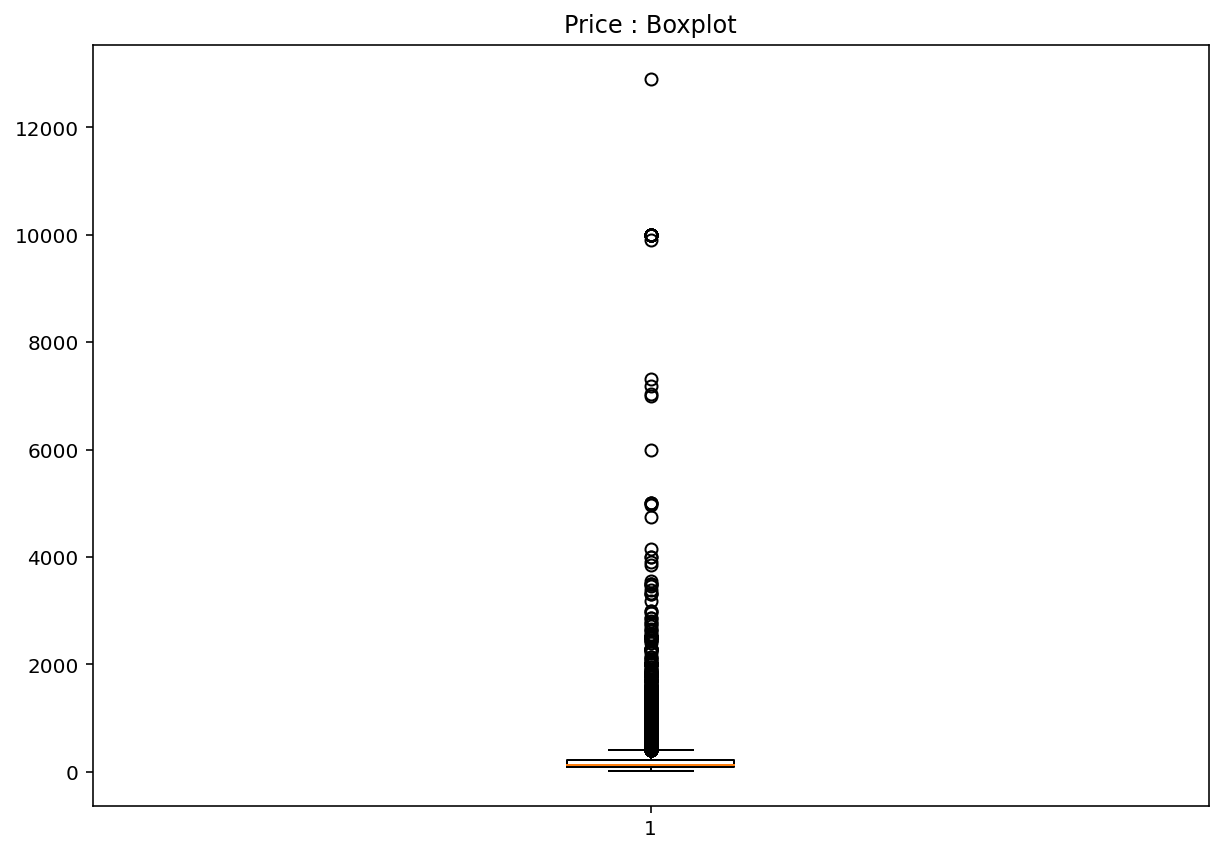

In [ ]:
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(df_listing['price'])
plt.title('Price : Boxplot')
# show plot
plt.show()

Highly skewed data:

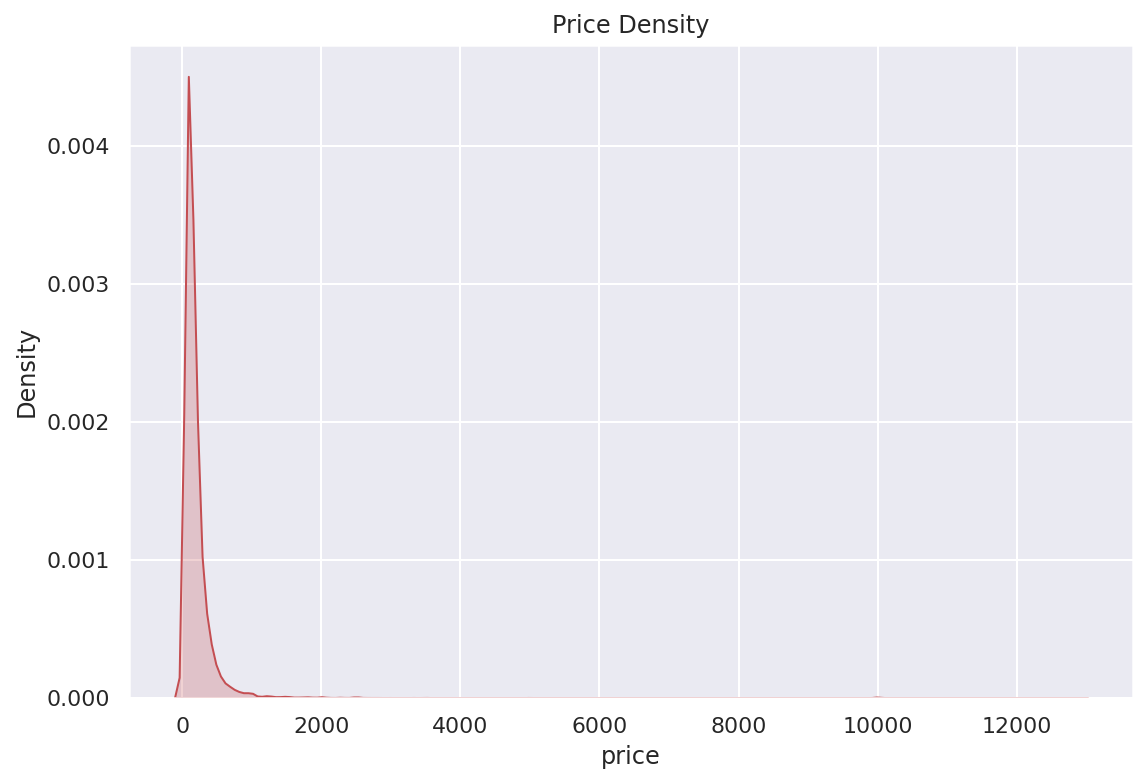

In [ ]:
kde('price',df_listing,'Price')

Well.. We have lots of outliers and will check if they contribute in predicting the prices. It is hard to interpret them though we zoom in.

In [ ]:
fig = px.box(df_listing, x="neighbourhood_group_cleansed", y="price", title='Prices per Neighborhood Group/NYC Borough with Outliers')


fig.show()

Let's save the old mean prices in a temporary dataframe:

In [ ]:
temp=df_listing.groupby('neighbourhood_group_cleansed').mean()['price']

temp

neighbourhood_group_cleansed
Bronx            121.827258
Brooklyn         151.792334
Manhattan        259.155884
Queens           122.734296
Staten Island    140.175393
Name: price, dtype: float64

In [ ]:
# Filter high price listings and sort from highest to lowest
df_listing[df_listing.price>4000][['bedrooms','beds','price','host_since','neighbourhood_cleansed']].sort_values(by='price', ascending=False)

bedrooms  beds    price  host_since neighbourhood_cleansed
17189       4.0   6.0  12900.0  2011-10-07                 Harlem
17705       1.0   2.0  10000.0  2019-09-27                Midtown
17703       1.0   2.0  10000.0  2019-09-27                Midtown
18034       1.0   1.0  10000.0  2019-06-06        Lower East Side
31724       5.0   8.0  10000.0  2015-06-03        Upper East Side
7457        2.0   2.0  10000.0  2016-02-12       Long Island City
17706       1.0   1.0  10000.0  2019-09-27                Midtown
27212       NaN   1.0  10000.0  2016-02-06     Financial District
14690       1.0   5.0  10000.0  2018-02-07            Murray Hill
17704       1.0   1.0  10000.0  2019-09-27                Midtown
19826       NaN   1.0   9999.0  2019-02-03        Upper East Side
18022       1.0   1.0   9999.0  2019-05-21                Midtown
16105       1.0   1.0   9999.0  2019-05-21         Hell's Kitchen
3041        2.0   2.0   9999.0  2011-10-01            East Harlem
24006       1.0   1.0   9994.0  2016-06-09               Longwood
2776        1.0   1.0   9990.0  2013-05-02           East Village
24611       NaN   1.0   9900.0  2013-01-15            East Harlem
5456        1.0   1.0   7314.0  2012-10-17        Lower East Side
8445        2.0   2.0   7184.0  2016-11-24               Canarsie
8852        4.0   9.0   7041.0  2011-10-07                 Harlem
19813       1.0   1.0   7000.0  2020-03-03       Theater District
1730        1.0   2.0   6000.0  2012-04-16        Upper West Side
22330       3.0   4.0   5000.0  2016-03-14      Flatiron District
6421        2.0   2.0   5000.0  2014-10-21                Tribeca
33001       9.0   6.0   5000.0  2012-08-29             Park Slope
9460        3.0   3.0   4964.0  2017-05-08           West Village
20988       2.0   3.0   4743.0  2016-08-11           Central Park
25878       2.0   2.0   4143.0  2016-08-18       Theater District

We do not observe any pattern between the high prices and other columns. We are going to cap the high prices and replace them with Q3 value which around 400.

In [ ]:
# Filter the outliers
df_outliers('price',df_listing)

              price
count   2389.000000
mean     828.807451
std      979.799511
min      410.000000
25%      479.000000
50%      582.000000
75%      800.000000
max    12900.000000


In [ ]:
print(f'The percentage of the outliers in the target column: {round(2389/len(df_listing),2)}')

The percentage of the outliers in the target column: 0.07


Winsorization technique allows us to do percentile capping. For example, values that are less than the value at 1st percentile are replaced by the value at 1st percentile, and values that are greater than the value at 99th percentile are replaced by the value at 99th percentile. The winsorization at 5th and 95th percentile is also common. However, the winsorization at 8th and 92nd will be used in this project to handle the outliers.

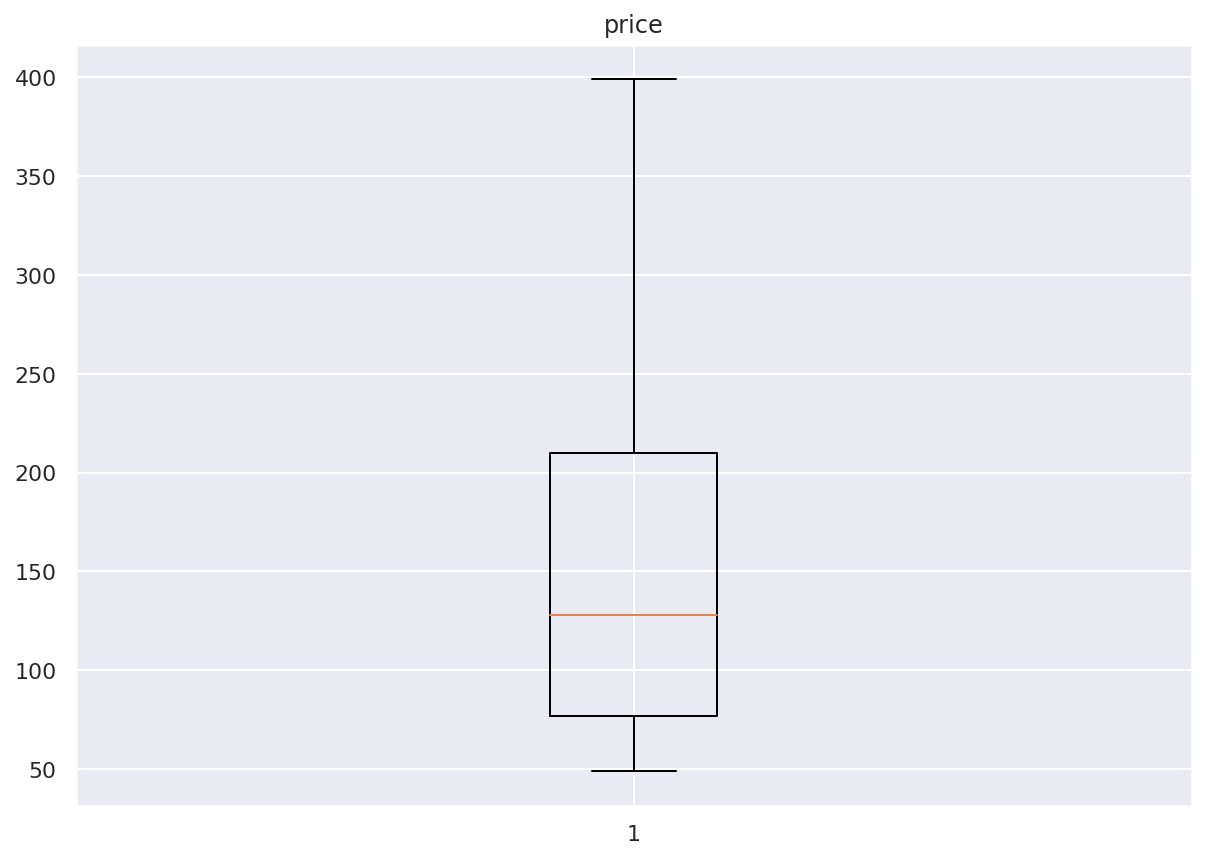

In [ ]:
capping('price',df_listing,0.08,0.92)

We no longer observe any outliers. Most of the outliers are gathered around 400.

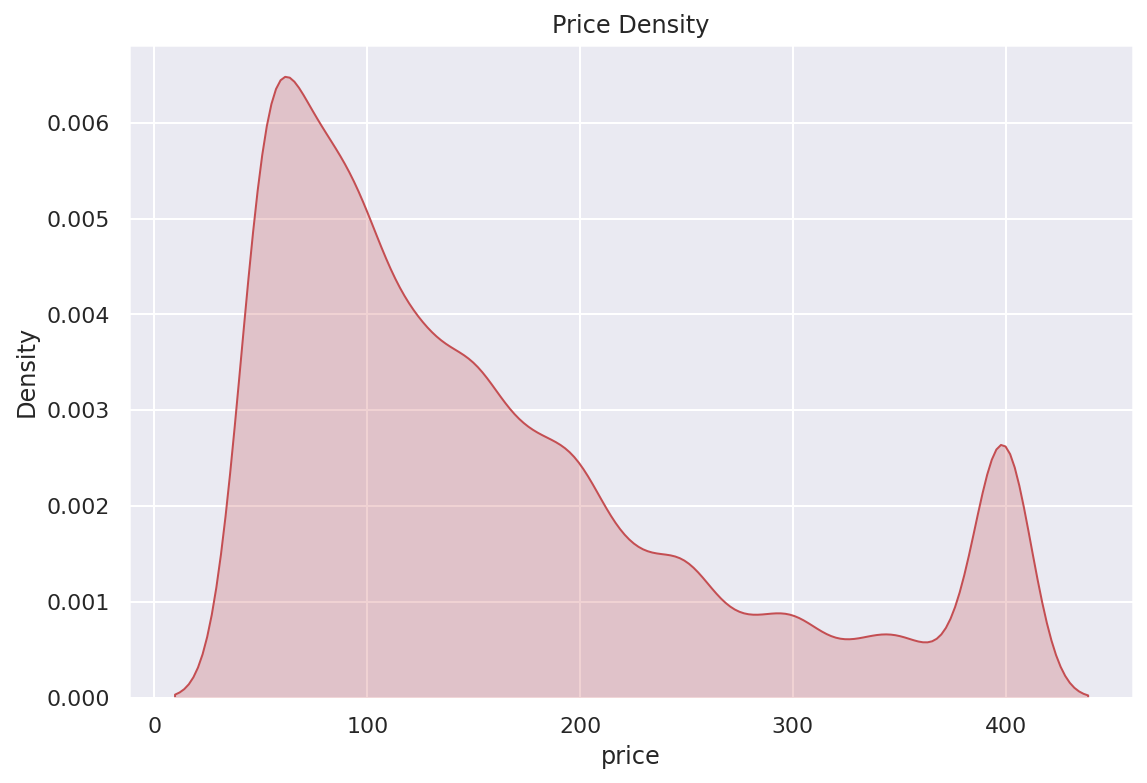

In [ ]:
kde('price',df_listing,'Price')

Before and after capping the outliers, here are the mean listing price values per neighbourhoods:

In [ ]:
temp

neighbourhood_group_cleansed
Bronx            121.827258
Brooklyn         151.792334
Manhattan        259.155884
Queens           122.734296
Staten Island    140.175393
Name: price, dtype: float64

In [ ]:
df_listing.groupby('neighbourhood_group_cleansed').mean()['price']

neighbourhood_group_cleansed
Bronx            110.602219
Brooklyn         141.259502
Manhattan        200.634666
Queens           115.788862
Staten Island    125.193717
Name: price, dtype: float64

Avg Manhattan price has dropped by 23% while other neighborhoods have reduced by 7-12%.

More details are below:

In [ ]:
fig = px.box(df_listing, x="neighbourhood_group_cleansed", y="price", title='Prices per Neighborhood Group/NYC Borough')


fig.show()

2. `accommodates`: number of the person(s) to stay

In [ ]:
# No missing value
df_listing.accommodates.isna().sum()

0

In [ ]:
df_listing.accommodates.value_counts()

2     15213
4      5413
1      4596
3      3328
6      1692
5      1516
8       559
7       364
10      181
16      134
12      107
9        79
11       24
15       24
14       21
13       19
Name: accommodates, dtype: int64

Let's take a look at its relationship with price:

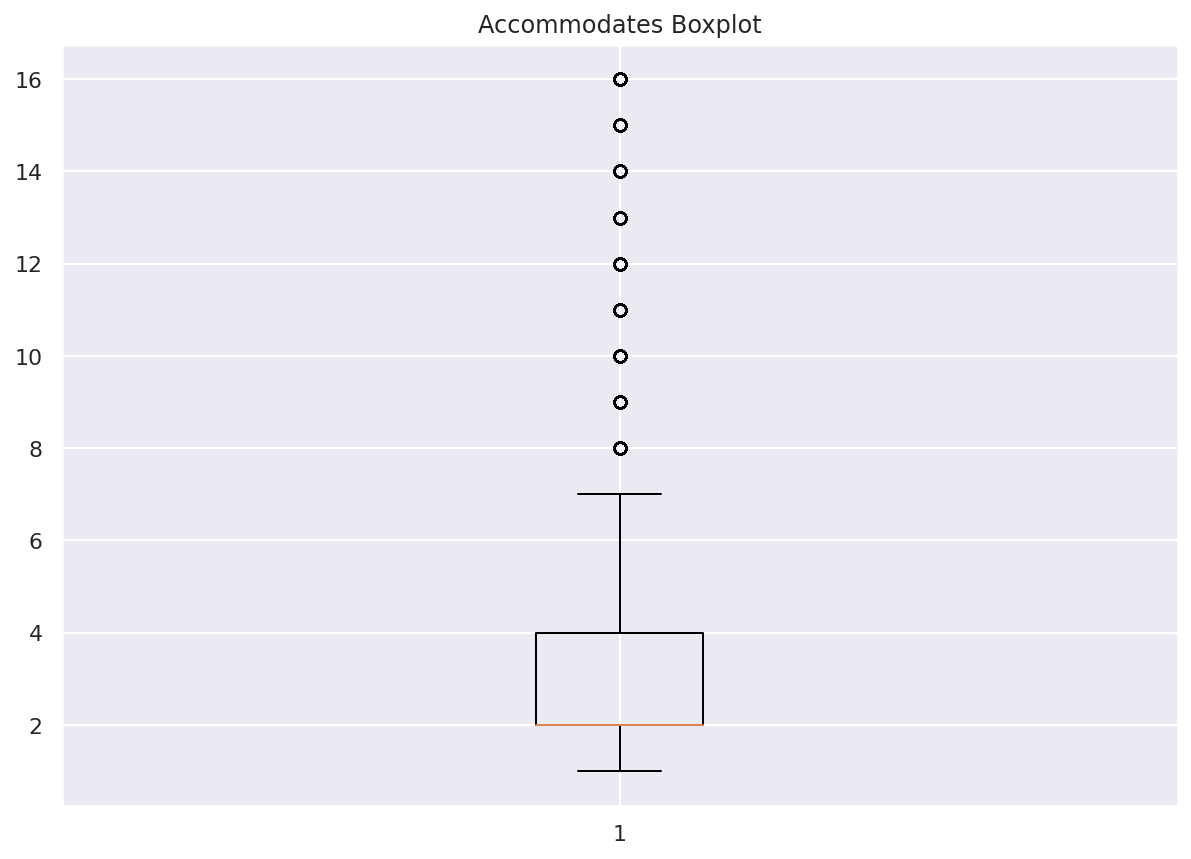

In [ ]:
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(df_listing['accommodates'])
plt.title('Accommodates Boxplot')
# show plot
plt.show()

Again we have outliers and skewed data.

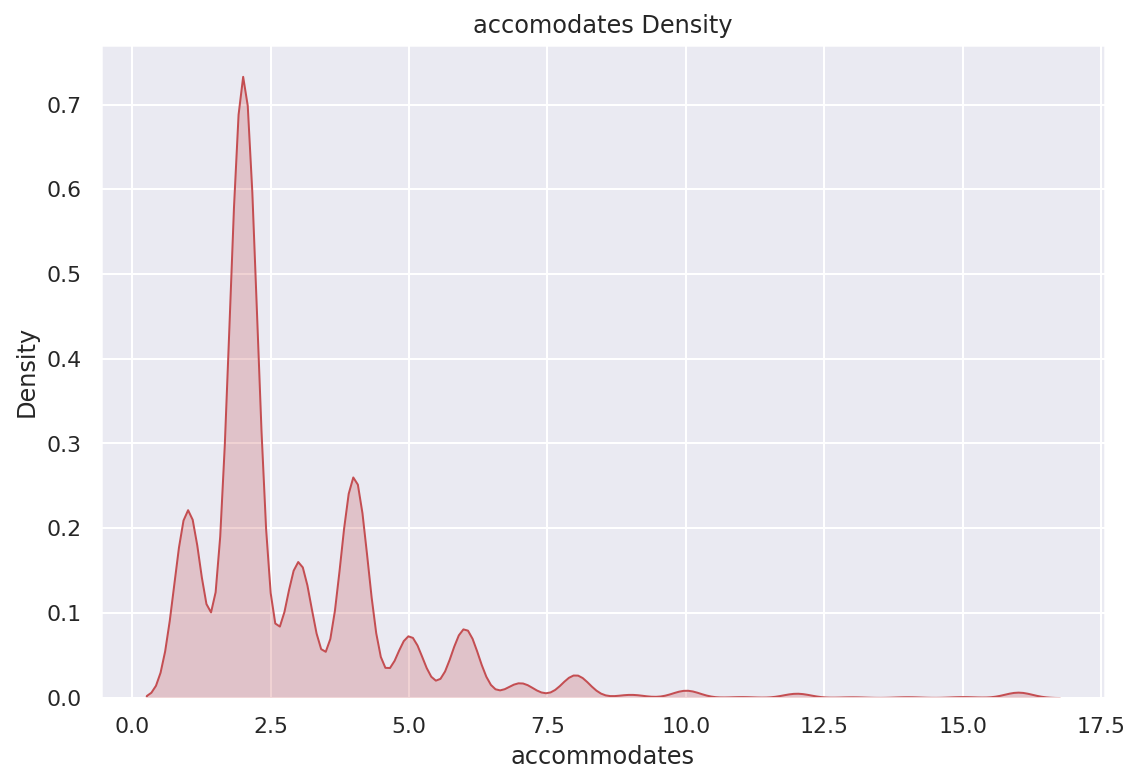

In [ ]:
kde('accommodates',df_listing,'accomodates')

In [ ]:
# FIlter outliers
df_outliers('accommodates',df_listing)

       accommodates
count   1148.000000
mean      10.092334
std        2.752222
min        8.000000
25%        8.000000
50%        9.000000
75%       12.000000
max       16.000000


In [ ]:
print(f'The percentage of the outliers in the accommodates: {round(1148/len(df_listing),2)}')

The percentage of the outliers in the accommodates: 0.03


In [ ]:
# Let's take a look at the rows with more than 7 accommodates
temp=df_listing[df_listing.accommodates>7][['accommodates','price','bedrooms','neighbourhood_cleansed','host_since']]

Let's plot the relationship between price and listings with more than 7 accommodates:

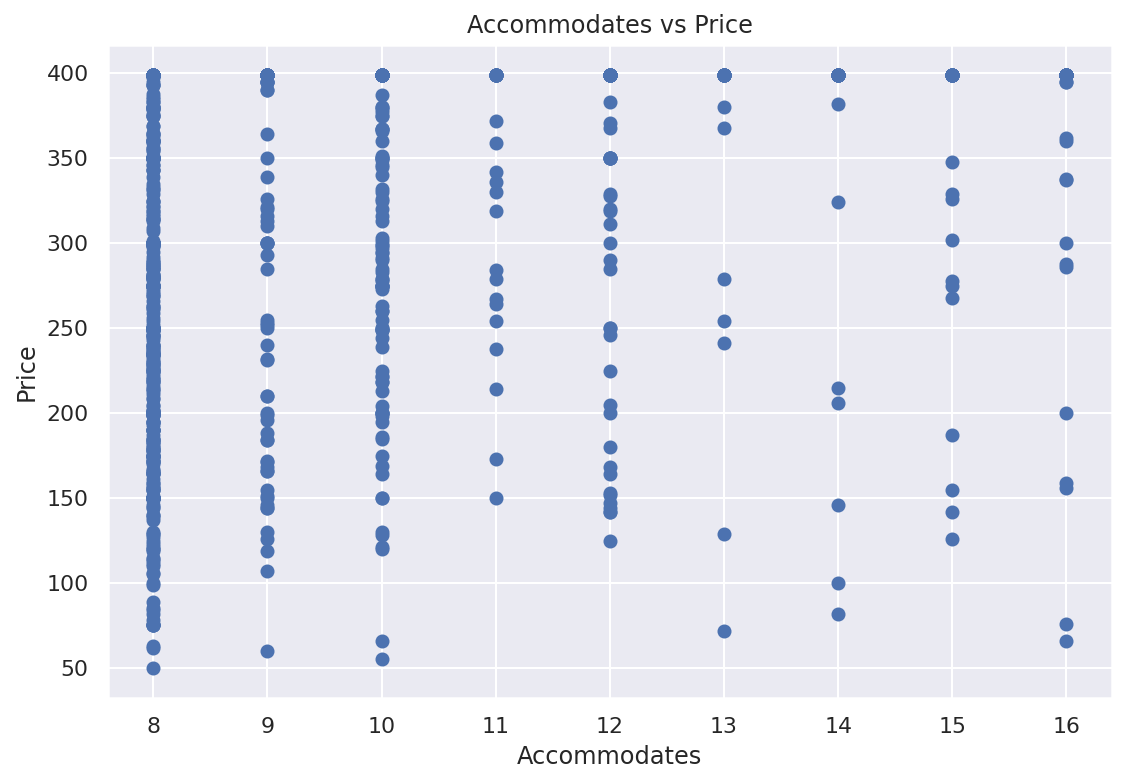

In [ ]:
plt.scatter(x=temp['accommodates'], y=temp['price'])
plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Accommodates vs Price')
plt.show()

There is no specific pattern.

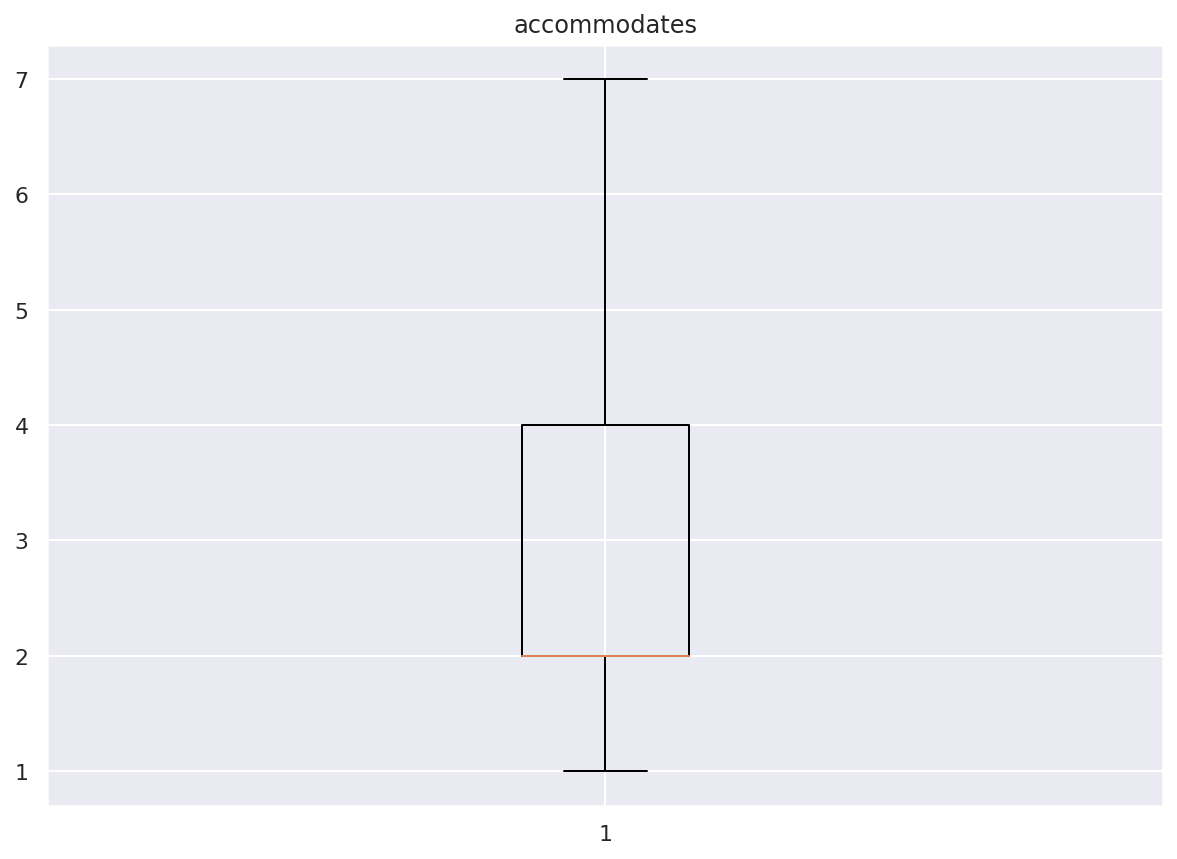

In [ ]:
# No more outliers!

capping('accommodates',df_listing,0.0,0.96)

In [ ]:
df_listing.accommodates.value_counts()

2.0    15213
4.0     5413
1.0     4596
3.0     3328
6.0     1692
5.0     1516
7.0     1512
Name: accommodates, dtype: int64

**3.** `room_type`: We can drop the hotel rooms and shared rooms.

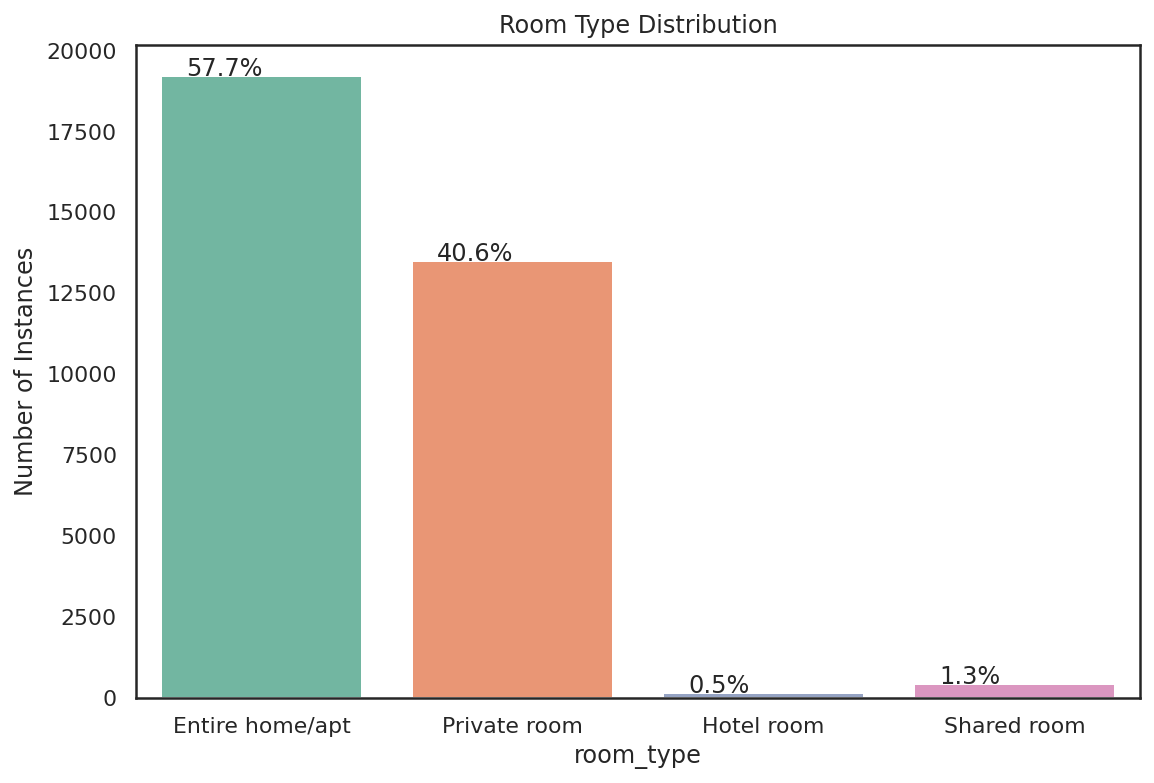

In [ ]:
perc_graph('room_type',df_listing,'Room Type')

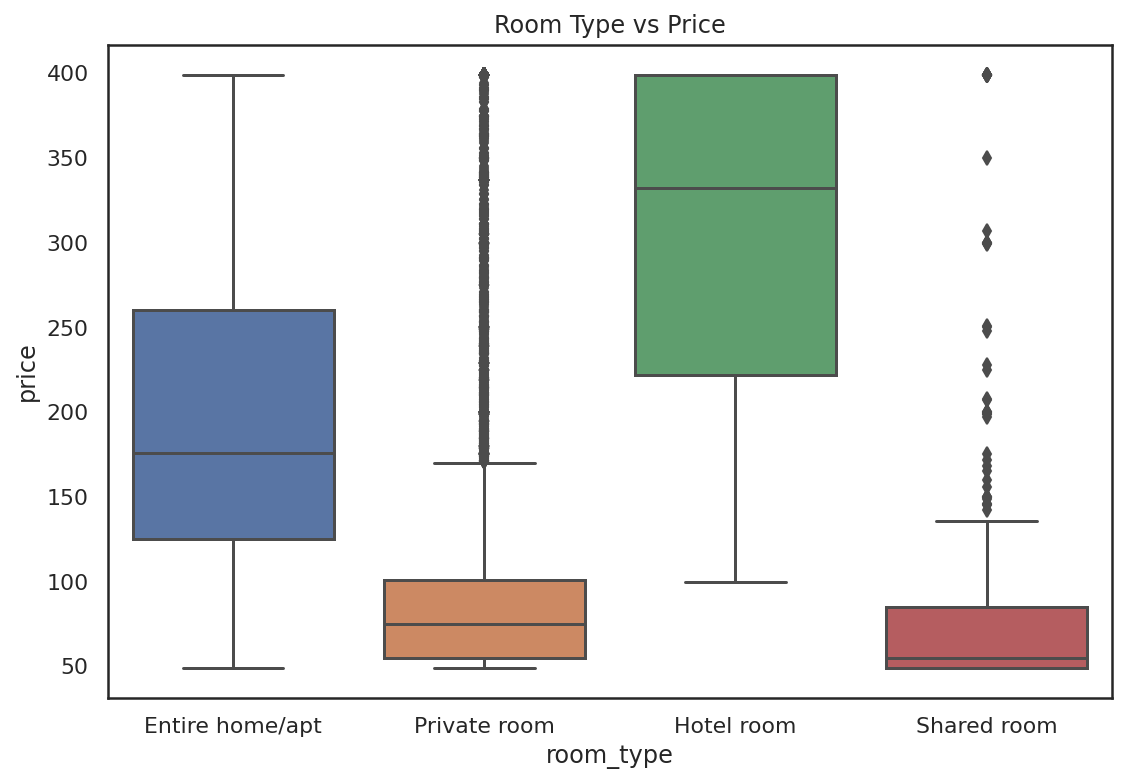

In [ ]:
sns.boxplot(x="room_type", y="price", data=df_listing).set_title('Room Type vs Price')
plt.show()

In [ ]:
# Exclude hotel rooms and shared rooms
df_listing=df_listing[df_listing.room_type!='Hotel room']
df_listing=df_listing[df_listing.room_type!='Shared room']

In [ ]:
# Let's check the shape again
df_listing.room_type.value_counts()

Entire home/apt    19205
Private room       13495
Name: room_type, dtype: int64

`property type`: it's a redundant column so that we will drop it.

In [ ]:
# List the unique values of property types
df_listing.property_type.value_counts()

Entire rental unit                    14491
Private room in rental unit            8457
Private room in home                   1864
Entire home                            1271
Entire condo                           1270
Private room in townhouse              1111
Entire loft                             640
Entire townhouse                        580
Room in hotel                           557
Private room in condo                   483
Entire guest suite                      349
Room in boutique hotel                  330
Entire serviced apartment               285
Private room in loft                    231
Private room in guest suite             108
Private room in casa particular          67
Entire place                             64
Room in aparthotel                       57
Entire guesthouse                        56
Private room in serviced apartment       51
Private room in bed and breakfast        51
Private room in hostel                   37
Private room                    

In [ ]:
# Drop the original column
df_listing=df_listing.drop('property_type',axis=1)

**4.** `has_availability`: We will drop this column because we have more detailed columns about availability.

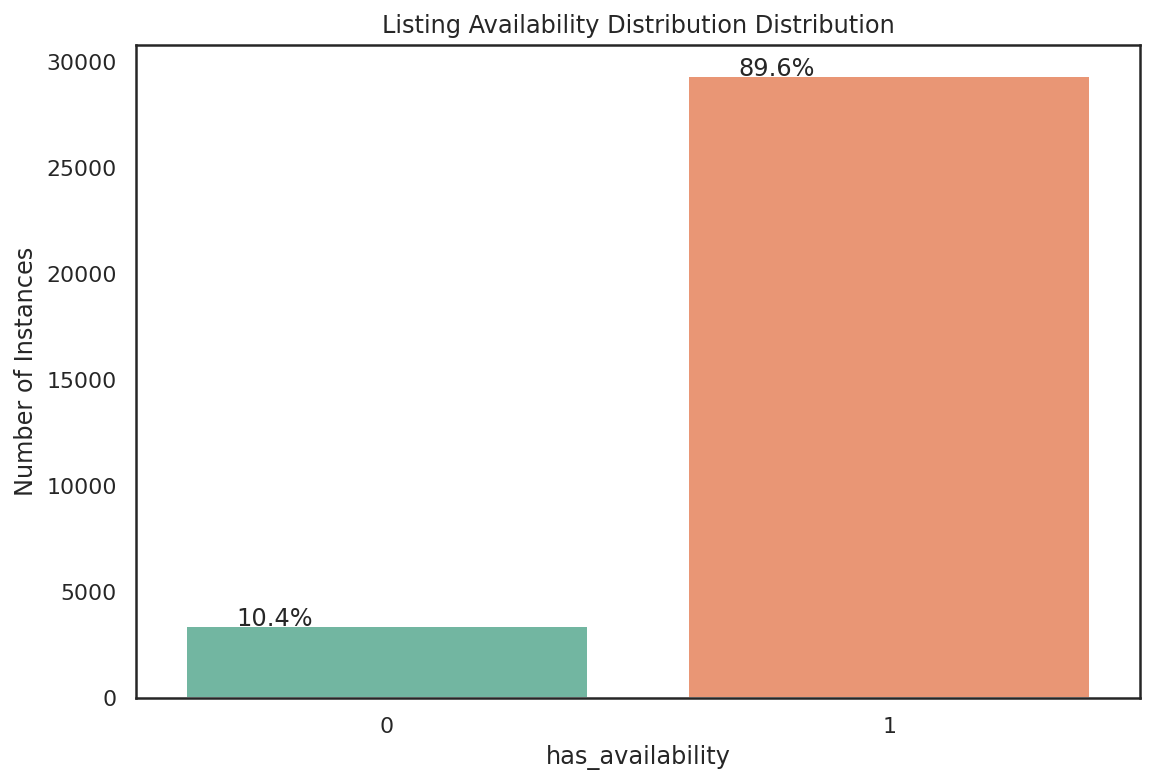

In [ ]:
# Plot the distribution of the listing availability
perc_graph('has_availability',df_listing,'Listing Availability Distribution')

In [ ]:
# Drop the column
df_listing=df_listing.drop('has_availability',axis=1)

**5.**`availability`: 30% of the listings seems to be unavailable in the next 365 days. What should we do about them? To achieve the target profit the host may tend to increase or decrease the listing price based on the apt availability. But it is also stated in the data dictionary that these columns may be blocked by the host.

In [ ]:
# Check unavailable days in each column
print(f'Availability within 30 days: {df_listing[df_listing.availability_30==0].shape}.')
print(f'Availability within 60 days: {df_listing[df_listing.availability_60==0].shape}.')
print(f'Availability within 90 days: {df_listing[df_listing.availability_90==0].shape}.')
print(f'Availability within 365 days: {df_listing[df_listing.availability_365==0].shape}.')

Availability within 30 days: (17613, 53).
Availability within 60 days: (14483, 53).
Availability within 90 days: (11969, 53).
Availability within 365 days: (10166, 53).


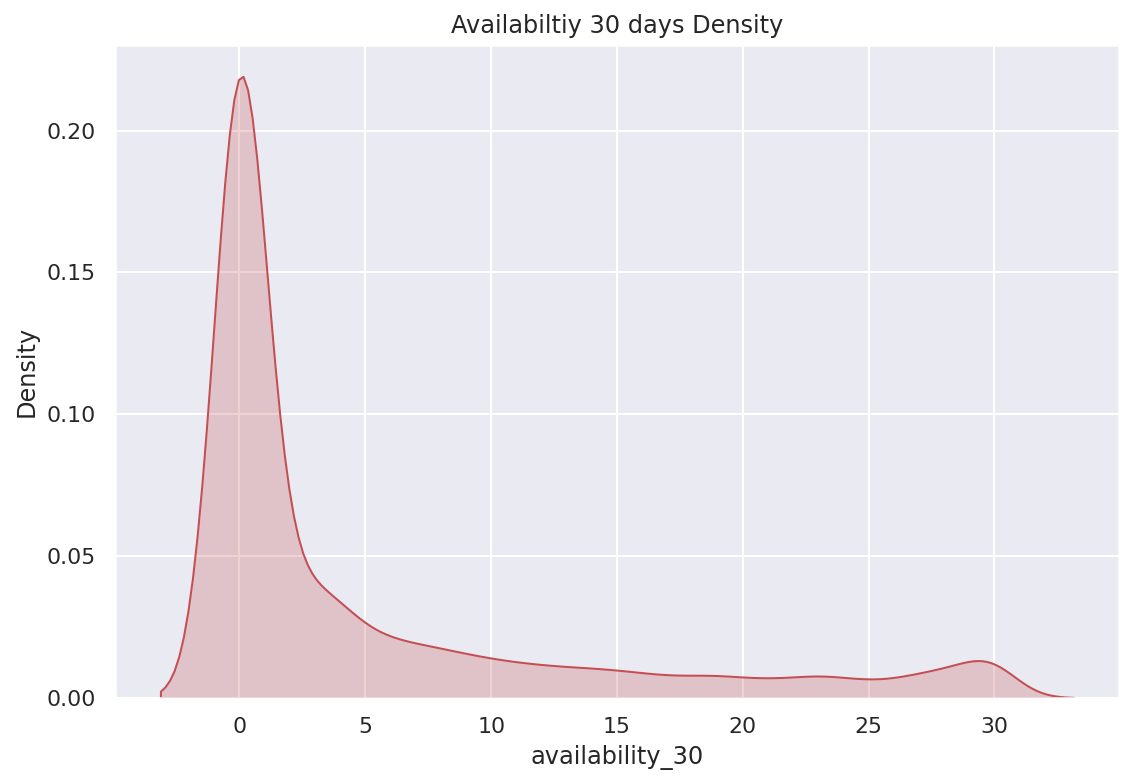

In [ ]:
kde('availability_30',df_listing, 'Availabiltiy 30 days')

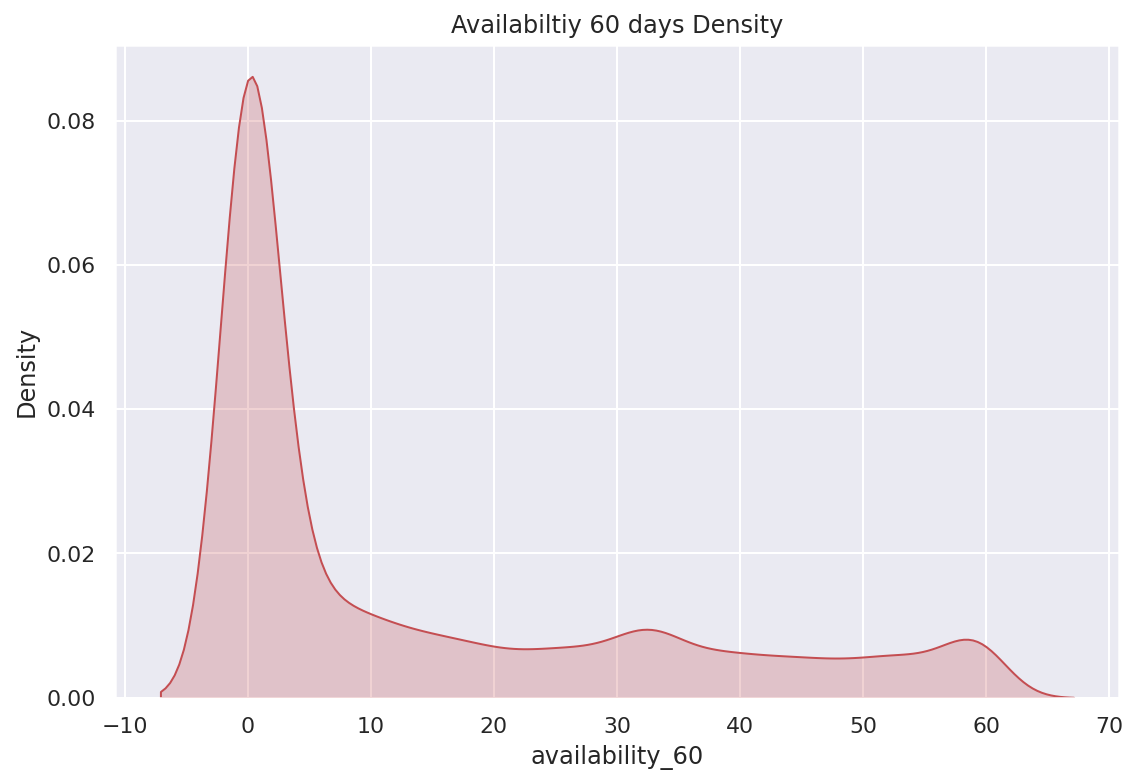

In [ ]:
kde('availability_60',df_listing, 'Availabiltiy 60 days')

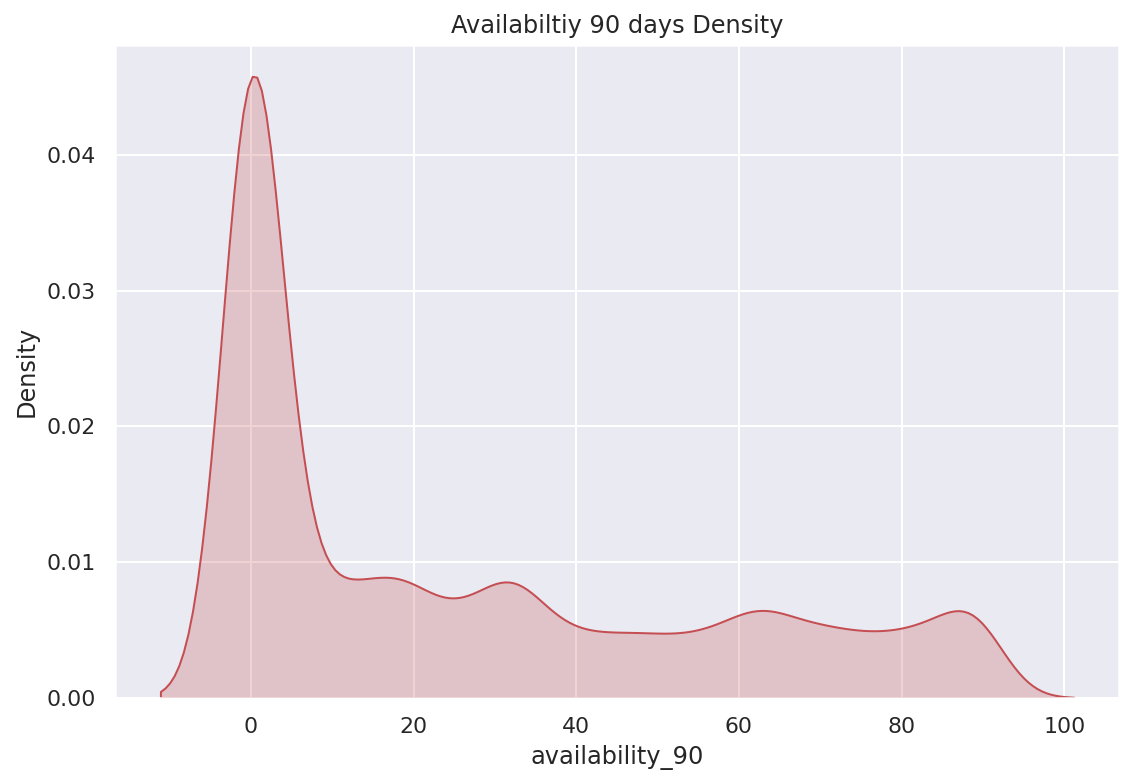

In [ ]:
kde('availability_90',df_listing, 'Availabiltiy 90 days')

We decided to keep only `availability_30` column.

In [ ]:
# Drop the column
df_listing=df_listing.drop(columns=['availability_60','availability_90','availability_365'],axis=1)

**6.** `host_about` : 40% of the text based column has no value. It will be so hard to fill these missing values and thereby we have decided to drop it.

In [ ]:
df_listing=df_listing.drop('host_about', axis=1)

**7.** `host_acceptance_rate`: We are dropping the listings with zero host acceptance rate but will use the KNN technique to fill the listings with NaN acceptance which was around 25%. 

In [ ]:
df_listing.host_acceptance_rate.value_counts()

100%    6973
99%     1684
98%     1415
94%      895
0%       879
        ... 
7%         5
2%         2
6%         2
4%         1
3%         1
Name: host_acceptance_rate, Length: 100, dtype: int64

In [ ]:
# Trim % sign
df_listing.host_acceptance_rate= df_listing.host_acceptance_rate.str.replace('%', '')

In [ ]:
# There are 879 rows with zero acceptance rate
df_listing[df_listing.host_acceptance_rate=='0']

id                                               name  \
15                   9704                Spacious 1 bedroom in luxe building   
29                  15396                 Sunny & Spacious Chelsea Apartment   
43                  19812        2 bedroom Williamsburg Apt - Bedford L stop   
47                  21794                COZY QUIET monthly room 4 DOOGLERS!   
63                  31555             Luminous Beautiful West Village Studio   
...                   ...                                                ...   
33103  634848367620090610  the historical building in the heart of Manhattan   
33214  637719730931290728                                      Crescent Cove   
33252  639044574294988805                    CHEERFUL 4 BEDROOMS NEXT TO ALL   
33260  639169307092560146   True 1400 sq 2 bed 2 bath with large balcony UES   
33281  639742902368120599                       UNBEATABLE WILLIAMSBURG ROOM   

                                             description    host_id  \
15     The room is spacious, the neighborhood is safe...      32045   
29     Modern, spacious, bright and well designed apa...      60278   
43     I love my apartment and I love being able to o...      74857   
47     Private, quiet and comfortable room with a lof...      83257   
63     Wonderfully bright, nicely furnished 400-squar...     135619   
...                                                  ...        ...   
33103  Enjoy easy access to popular shops and restaur...   48819761   
33214  Kick back and relax in this calm, stylish , Un...   72074833   
33252  Bring the whole family to this great place wit...  183178516   
33260  Bring the whole family to this 2 bed set up pe...   17848036   
33281  WELCOME TO WILLIAMSBURG!<br /><br />My name is...    4204942   

       host_since                              host_location  \
15     2009-08-16          New York, New York, United States   
29     2009-12-05          New York, New York, United States   
43     2010-01-29          New York, New York, United States   
47     2010-02-20          New York, New York, United States   
63     2010-05-31          New York, New York, United States   
...           ...                                        ...   
33103  2015-11-11  Marina del Rey, California, United States   
33214  2016-05-15          New York, New York, United States   
33252  2018-04-08              New York, Iowa, United States   
33260  2014-07-09          New York, New York, United States   
33281  2012-11-20          New York, New York, United States   

       host_response_time host_response_rate host_acceptance_rate  \
15           within a day                50%                    0   
29           within a day                75%                    0   
43     a few days or more                 0%                    0   
47     a few days or more                 0%                    0   
63                    NaN                NaN                    0   
...                   ...                ...                  ...   
33103        within a day                59%                    0   
33214      within an hour               100%                    0   
33252  within a few hours                90%                    0   
33260      within an hour                80%                    0   
33281      within an hour               100%                    0   

       host_is_superhost  ... review_scores_checkin  \
15                   0.0  ...                  4.91   
29                   0.0  ...                  5.00   
43                   0.0  ...                  4.65   
47                   0.0  ...                  5.00   
63                   0.0  ...                  4.90   
...                  ...  ...                   ...   
33103                0.0  ...                   NaN   
33214                0.0  ...                   NaN   
33252                0.0  ...                   NaN   
33260                0.0  ...                   NaN   
33281 

In [ ]:
# Eliminate zero acceptance rate
df_listing=df_listing[df_listing.host_acceptance_rate!='0']

In [ ]:
print(f"NaN value proportion in the host acceptance rate column: {round((df_listing.host_acceptance_rate.isna().sum()/len(df_listing))*100, 1)}%")

NaN value proportion in the host acceptance rate column: 25.2%


`host_acceptance_rate`: We label nan values (25%) in this column as unknown. We do not want to lose a huge chunk of data. We will use KNN method to fill them. 

In [ ]:
  # fit on the dataset

imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

  # transform the dataset
df_listing['host_acceptance_rate']= imputer.fit_transform(df_listing[['host_acceptance_rate']]).round(2)


In [ ]:
# Correct the datatype
df_listing.host_acceptance_rate=df_listing.host_acceptance_rate.astype('int')

In [ ]:

  # print total missing value percentages again

print(' Number of missing values in column host_acceptance_rate:')

df_listing['host_acceptance_rate'].isna().sum()

 Number of missing values in column host_acceptance_rate:


0

In [ ]:
# Bin host_acceptance_rate values
host_acceptance_bins=[1,26,51,76,101]
host_acceptance_labels=['1-25%','26-50%','51-75%','76-100%']
df_listing['host_acceptance_rate']=pd.cut(df_listing['host_acceptance_rate'], bins=host_acceptance_bins, labels=host_acceptance_labels, right=False)


In [ ]:
# Distribution of host acceptance percentage values
df_listing.host_acceptance_rate.value_counts()

76-100%    26382
51-75%      3129
26-50%      1748
1-25%        562
Name: host_acceptance_rate, dtype: int64

In [ ]:
# Sanity check
df_listing.host_acceptance_rate.isna().sum()

0

In [ ]:
# Let's check the missing values
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
host_response_time                     0.27
host_response_rate                     0.27
review_scores_location                 0.13
review_scores_value                    0.13
review_scores_communication            0.13
review_scores_checkin                  0.13
review_scores_cleanliness              0.13
review_scores_accuracy                 0.13
reviews_per_month                      0.13
first_review                           0.13
review_scores_rating                   0.13
last_review                            0.13
bedrooms                               0.10
beds                                   0.02
description                            0.02
host_location                          0.00
host_total_listings_count              0.00
host_thumbnail_url                     0.00
host_is_superhost                      0.00
host_since                             0.00
host_listings_count                    0.00
host_picture_url                       0.00
host_identity_verified                 0.00
host_has_profile_pic                   0.00
bathrooms_text                         0.00
name                                   0.00

**8.** `host_response_time`: Customer message response time may have a relationship with communication review score.

In [ ]:
df_listing[df_listing.host_response_time.isna()][['review_scores_communication','number_of_reviews','review_scores_checkin','host_response_rate','host_response_time']].sort_values(by=['review_scores_communication'], ascending=False)

review_scores_communication  number_of_reviews  review_scores_checkin  \
9406                           5.0                 19                   5.00   
11016                          5.0                  4                   5.00   
11046                          5.0                  4                   3.67   
11041                          5.0                  2                   5.00   
11037                          5.0                  2                   5.00   
...                            ...                ...                    ...   
4147                           0.0                  1                   0.00   
3285                           0.0                  1                   0.00   
5446                           0.0                  1                   0.00   
3064                           0.0                  1                   5.00   
6826                           0.0                  1                   0.00   

      host_response_rate host_response_time  
9406                 NaN                NaN  
11016                NaN                NaN  
11046                NaN                NaN  
11041                NaN                NaN  
11037                NaN                NaN  
...                  ...                ...  
4147                 NaN                NaN  
3285                 NaN                NaN  
5446                 NaN                NaN  
3064                 NaN                NaN  
6826                 NaN                NaN  

[8643 rows x 5 columns]

If host_response_time is missing, host_response_rate is automatically missing too. 

Let's convert all NaN values into unknown:

In [ ]:
df_listing.host_response_time= df_listing.host_response_time.fillna('unknown')

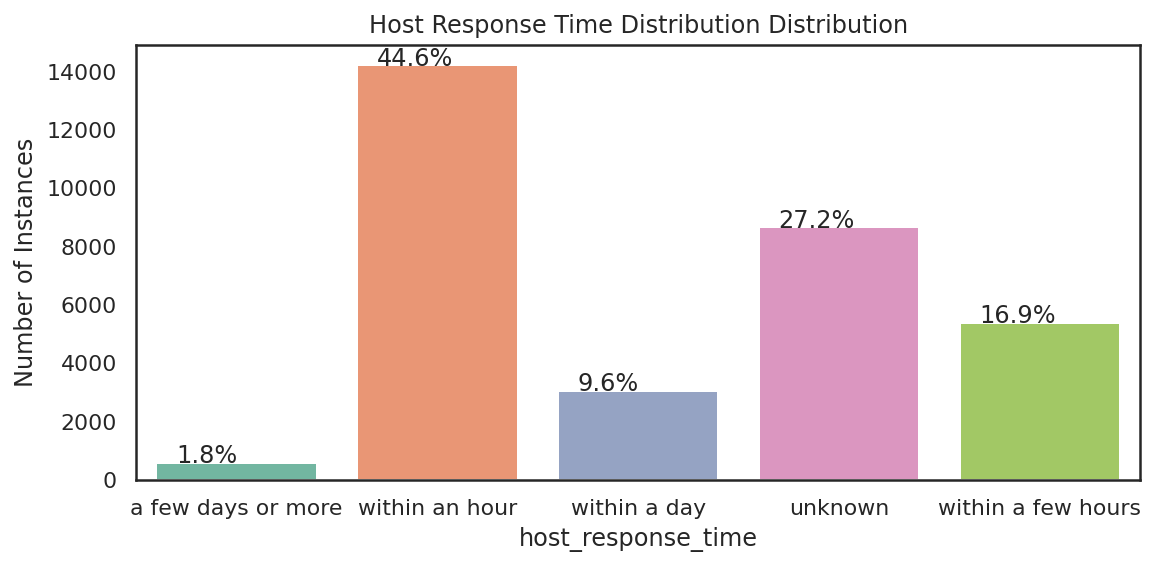

In [ ]:
plt.figure(figsize=(9,4))
perc_graph('host_response_time', df_listing, 'Host Response Time Distribution')

We will try to use communication review score column to fill these unknown values which represent 27% of the obversation points.

**9.**`review_scores_communication`:

Filling the missing values in `review_scores_communication` based on the mean score value of `host_response_time`:

**We believe that visitors may give the `review_scores_communication` based on `host_response_time` . As the response time is shorter, the review score is more likely to be higher. To understand the relationship between these two variables, we will follow steps below and attempt to fill the missing values in `review_scores_communication`:**

In [ ]:
# Find the distribution of review_score_communication values
df_listing.groupby('host_response_time').count()['review_scores_communication']

host_response_time
a few days or more      397
unknown                8643
within a day           2483
within a few hours     4195
within an hour        12043
Name: review_scores_communication, dtype: int64

In [ ]:
nan_df=df_listing.groupby('host_response_time').mean().round(2)[['review_scores_communication','number_of_reviews']].reset_index()
nan_df

host_response_time  review_scores_communication  number_of_reviews
0  a few days or more                         4.69              16.85
1             unknown                         4.83              16.00
2        within a day                         4.77              24.76
3  within a few hours                         4.79              28.47
4      within an hour                         4.82              39.89

The listings with unknown response time have reviews.. Unfortunately we are able to see the review date. At least the mean of the communication scores may lead us to a way to refill the unknown values. We can replace them with within an hour.

In [ ]:
# Replace unknown values with within a day
df_listing.host_response_time=df_listing.host_response_time.str.replace('unknown','within an hour')

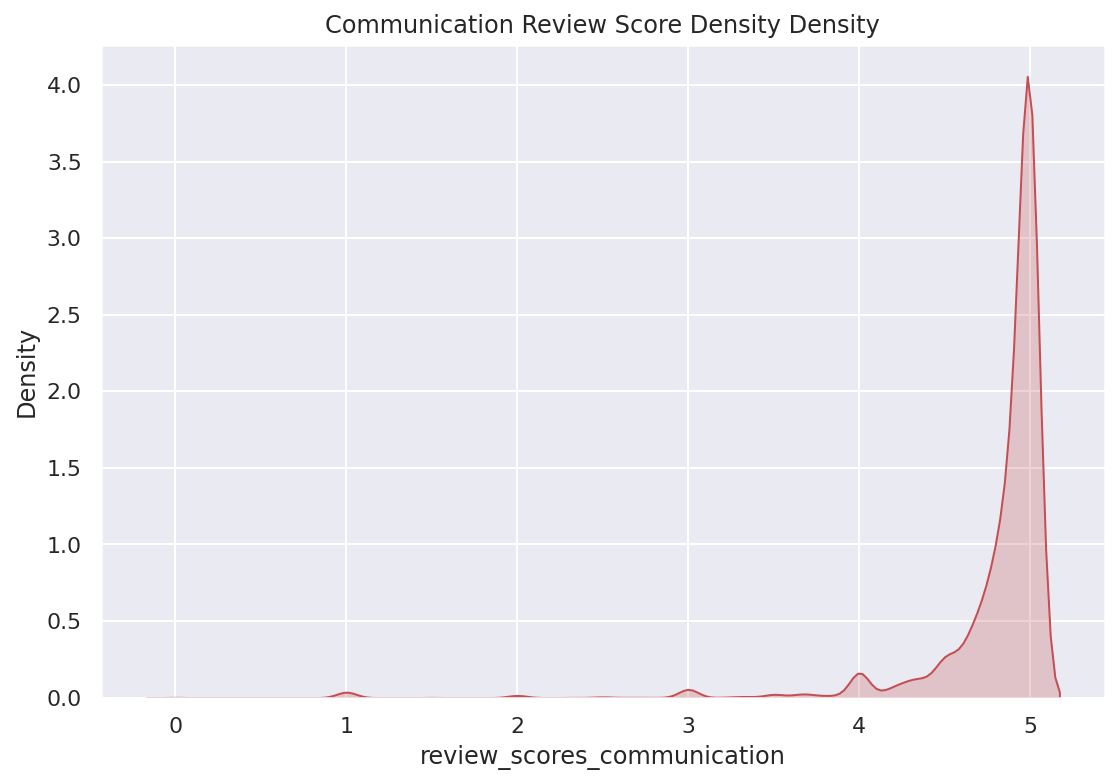

In [ ]:
# Plot the density of the density
kde('review_scores_communication',df_listing,'Communication Review Score Density')

In [ ]:
# Fill the missing values with the mean score of each host response time variable
values = df_listing.groupby('host_response_time')['review_scores_communication'].transform('mean').round().fillna(1)
df_listing['review_scores_communication'] = np.where(df_listing['review_scores_communication'].notna(),df_listing['review_scores_communication'],values).astype(float)

In [ ]:
# Print missing values
df_listing.review_scores_communication.isna().sum()

0

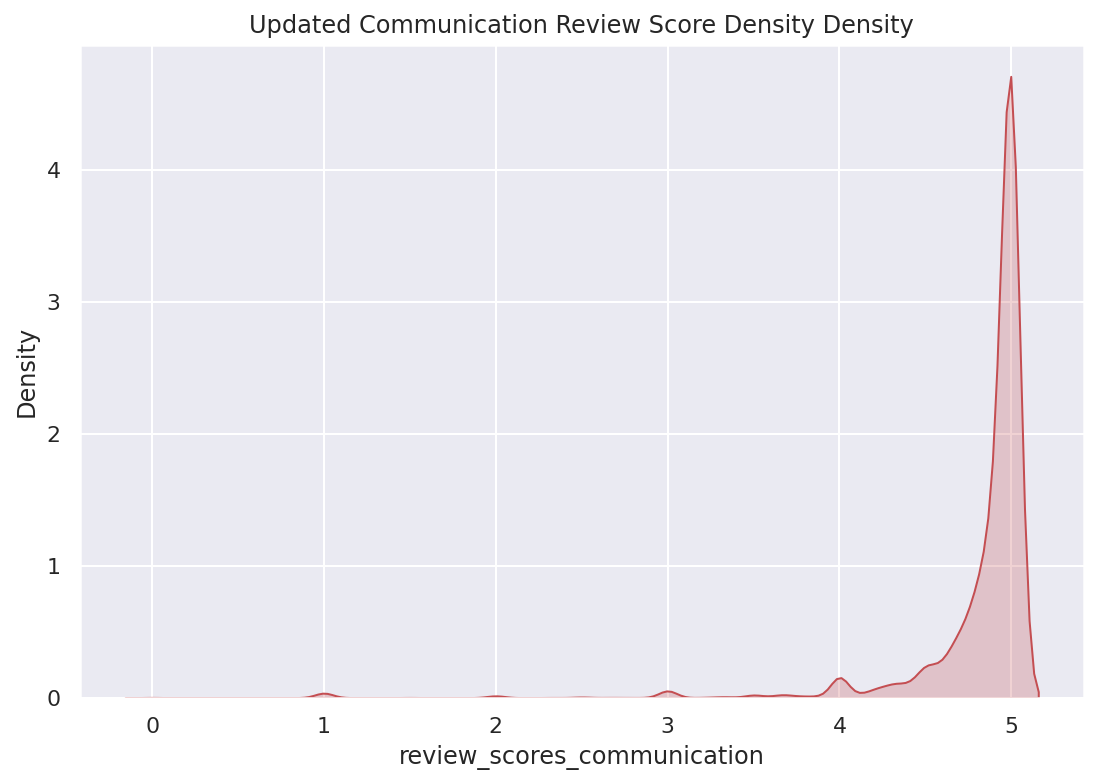

In [ ]:
kde('review_scores_communication',df_listing,'Updated Communication Review Score Density')

**10.** `host_response_rate`:

In [ ]:
# Check the unknown values 
print(f"NaN value proportion: {round((df_listing.host_response_rate.isna().sum()/len(df_listing))*100, 1)}%")

NaN value proportion: 27.2%


In [ ]:
# Quick look
df_listing.host_response_rate

0         39%
1        100%
2        100%
3        100%
4         NaN
         ... 
33298    100%
33299    100%
33300     93%
33301    100%
33302     98%
Name: host_response_rate, Length: 31821, dtype: object

In [ ]:
# Check if there is zero percentage in the column
df_listing[df_listing.host_response_rate=='0%'].shape


(205, 49)

In [ ]:
# Trim % sign
df_listing.host_response_rate= df_listing.host_response_rate.str.replace('%', '')

Fill missing values by using KNN method:

In [ ]:
  # fit on the dataset

imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

  # transform the dataset
df_listing['host_response_rate']= imputer.fit_transform(df_listing[['host_response_rate']]).round(2)




In [ ]:
# Convert the data type to integer
df_listing.host_response_rate=df_listing.host_response_rate.astype('int')

In [ ]:
# Bin host_response_rate values
host_response_bins=[0,26,51,76,101]
host_response_labels=['0-25%','26-50%','51-75%','76-100%']
df_listing['host_response_rate']=pd.cut(df_listing['host_response_rate'], bins=host_response_bins, labels=host_response_labels, right=False)


In [ ]:
df_listing['host_response_rate'].isna().sum()

0

In [ ]:
# Convert the column into object
df_listing['host_response_rate']=df_listing[['host_response_rate']].apply(lambda x: x.astype('object'))
df_listing['host_response_rate'].head()

0     26-50%
1    76-100%
2    76-100%
3    76-100%
4    76-100%
Name: host_response_rate, dtype: object

In [ ]:
# Let's check the missing values
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
review_scores_location               0.13
review_scores_value                  0.13
review_scores_checkin                0.13
review_scores_cleanliness            0.13
review_scores_accuracy               0.13
reviews_per_month                    0.13
first_review                         0.13
review_scores_rating                 0.13
last_review                          0.13
bedrooms                             0.10
beds                                 0.02
description                          0.02
host_location                        0.00
host_is_superhost                    0.00
host_picture_url                     0.00
host_since                           0.00
host_thumbnail_url                   0.00
host_identity_verified               0.00
host_has_profile_pic                 0.00
host_total_listings_count            0.00
host_listings_count                  0.00
bathrooms_text                       0.00
name                                 0.00

 **11.** `host_is_superhost`: After dropping most of the missing value rows, we have found that 21.3% of the hosts achieved the superhost status.                            

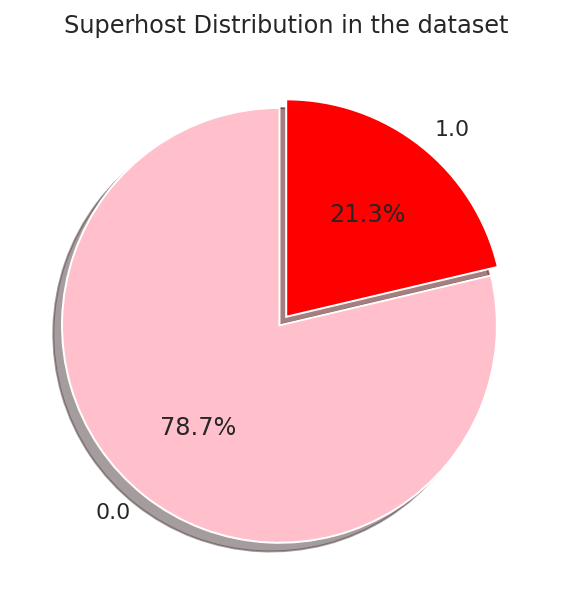

In [ ]:
#Create a pie chart to illustrate the superhost distribution in the dataset

labels = df_listing['host_is_superhost'].value_counts(sort = True).index
sizes = df_listing['host_is_superhost'].value_counts(sort = True)

colors = ["pink","red"]
explode = (0.05,0) 
 
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Superhost Distribution in the dataset')
plt.show()

In [ ]:
df_listing[df_listing.host_is_superhost.isna()].shape

(39, 49)

Probably all 39 hosts are recently registered. We can drop them.

In [ ]:
df_listing=df_listing[df_listing.host_is_superhost.notna()]

**12.** `host_since`: This column has been used to create a new column called `host_since_months` to calculate the number of the days since a host registered on the website. Additionally, we have found the year they have registered.                                      

In [ ]:
# Convert datetime
df_listing.host_since=pd.to_datetime(df_listing.host_since)

# Sanity check
df_listing.host_since

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0       2008-09-09
1       2009-02-03
2       2009-02-03
3       2009-03-03
4       2009-02-05
           ...    
33298   2015-04-28
33299   2021-06-02
33300   2021-06-24
33301   2016-12-16
33302   2020-07-10
Name: host_since, Length: 31782, dtype: datetime64[ns]

In [ ]:
df_listing.host_since.isna().sum()

0

In [ ]:
df_listing['host_year'] = df_listing['host_since'].dt.year
df_listing['host_year']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0        2008
1        2009
2        2009
3        2009
4        2009
         ... 
33298    2015
33299    2021
33300    2021
33301    2016
33302    2020
Name: host_year, Length: 31782, dtype: int64

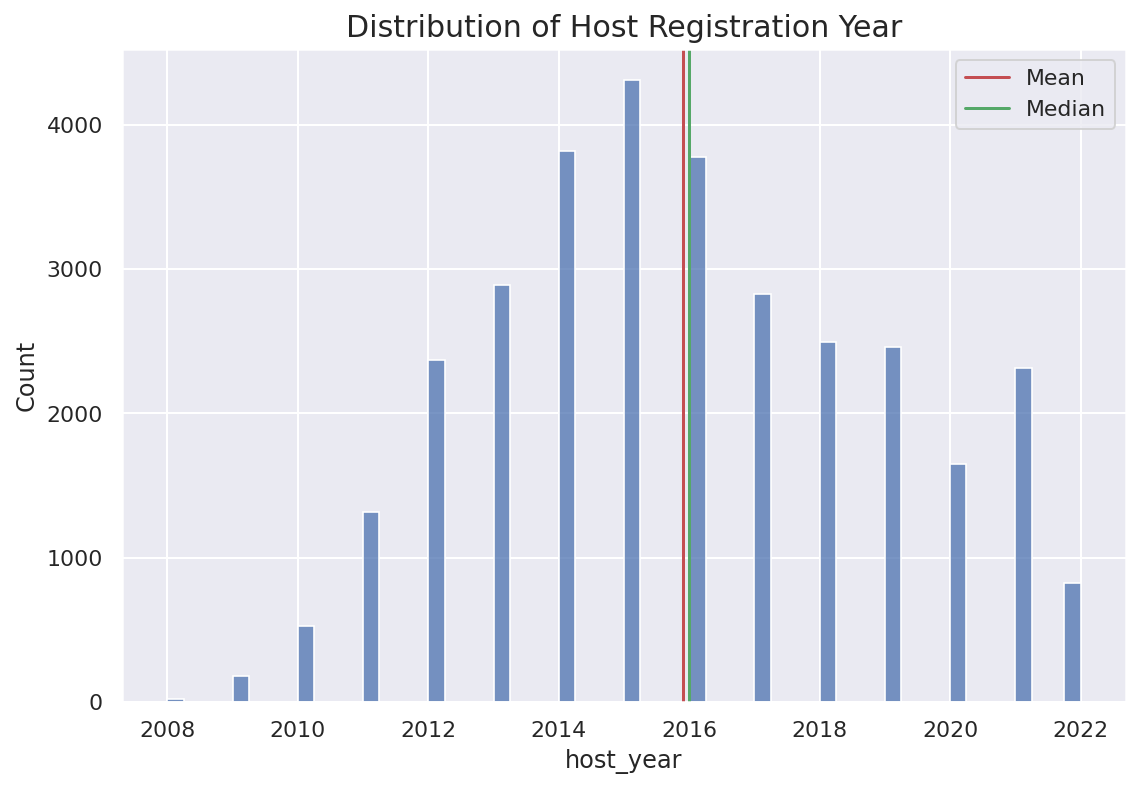

In [ ]:
# Save mean, and median to the variable

var=df_listing['host_year']
var_mean = df_listing['host_year'].mean()
var_median = df_listing['host_year'].median()

# Plot a histogram of song tempo, with lines marking mean and median
plt.figure()
sns.histplot(var, kde=False)
plt.axvline(var_mean, c='r', label='Mean')
plt.axvline(var_median, c='g', label='Median')
plt.legend()
plt.title('Distribution of Host Registration Year', fontsize=15)
plt.show()

We can conclude the followings:
- The host registration number increases till 2015, but it starts to slow down afterwards. 
- The mean host registiration year is 2016. 
- The highest number of hosts are registed in 2015.
- There is a decrease in 2020 due to the pandemic.
- After COVID's first year, there was a small increase in the number of registration in 2021 but it is followed by a dramatic decrease again in 2022.
- Year 2008 seems to be outlier. 

In [ ]:
# Only 16 listings belong to year 2008. We will still keep them
df_listing[df_listing.host_year==2008].shape

(17, 50)

Since we aim to keep the number of months the hosts have been active on Airbnb.com, we will drop the `host_year` column:

In [ ]:
df_listing.drop('host_year', axis=1, inplace=True)

In [ ]:
# Calculating the number of days
df_listing['host_since_months'] = (pd.datetime(2022, 6, 3) - df_listing.host_since).astype('timedelta64[M]')

df_listing['host_since_months']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



0        164.0
1        159.0
2        159.0
3        159.0
4        159.0
         ...  
33298     85.0
33299     12.0
33300     11.0
33301     65.0
33302     22.0
Name: host_since_months, Length: 31782, dtype: float64

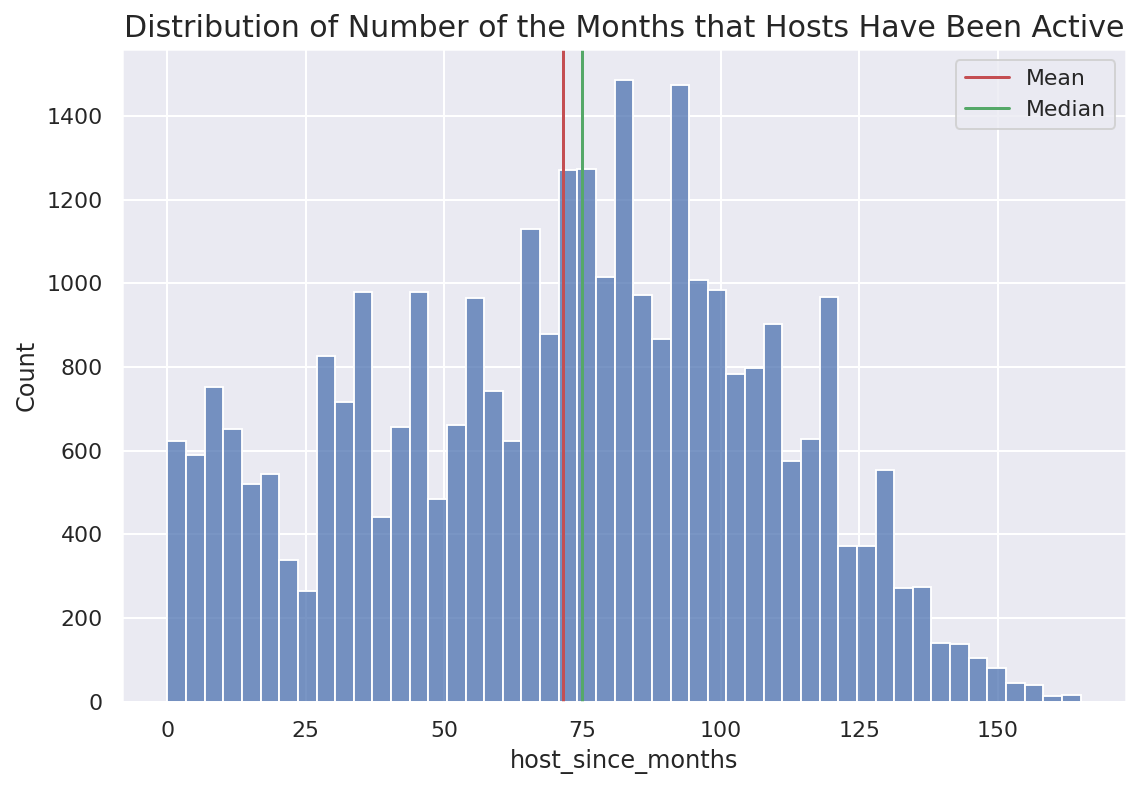

In [ ]:
# Save mean, and median to the variable

var=df_listing['host_since_months']
var_mean = df_listing['host_since_months'].mean()
var_median = df_listing['host_since_months'].median()

# Plot a histogram of song tempo, with lines marking mean and median
plt.figure()
sns.histplot(var, kde=False)
plt.axvline(var_mean, c='r', label='Mean')
plt.axvline(var_median, c='g', label='Median')
plt.legend()
plt.title('Distribution of Number of the Months that Hosts Have Been Active', fontsize=15)
plt.show()

yes, it may not be 100% normally distributed but it does not look like skewed either.

In [ ]:
# Drop the original host_since column
df_listing.drop(['host_since'],axis=1,inplace=True)

**13.** `host_location` : We think that visitors may feel more comfortable if their hosts live in the same city where the rental property is. We can see that most of the hosts are located in New York. Some of them only selected "US". We have decided to create a column which shows if the host lives in New York by filtering the values containing either New York or NY.

In [ ]:
# Examine the host locations
df_listing.host_location.value_counts()

New York, New York, United States           16291
Brooklyn, New York, United States            3693
US                                           3418
Queens, New York, United States              1657
United States                                 429
                                            ...  
Aloma, Florida, United States                   1
Uruguay                                         1
Ouagadougou, Centre Region, Burkina Faso        1
Christiana, Delaware, United States             1
Irwindale, California, United States            1
Name: host_location, Length: 1549, dtype: int64

In [ ]:
# Take a look at the property locations 
df_listing.neighbourhood_group_cleansed.value_counts()

Manhattan        13223
Brooklyn         11869
Queens            5118
Bronx             1199
Staten Island      373
Name: neighbourhood_group_cleansed, dtype: int64

In [ ]:
# Only 10 of the hosts named their location as Manhattan.
df_listing['host_location'].str.contains('New York').value_counts()

True     23130
False     8596
Name: host_location, dtype: int64

In [ ]:
# Check NY term
df_listing[df_listing['host_location'].astype(str).str.contains("NY")][['host_location']].head()

host_location
182  Brooklyn, NY
488  Brooklyn, NY
525  Brooklyn, NY
541  Brooklyn, NY
544  Brooklyn, NY

In [ ]:
# Convert rows with NY or New York to 1 
df_listing['host_location']=np.where(df_listing.host_location.str.contains('New York| NY'),1,0)


In [ ]:
df_listing.host_location.value_counts()

1    23211
0     8571
Name: host_location, dtype: int64

**14.** `host_has_profile_pic`: Only 308 of the hosts do not have a profile picture on the website. 



In [ ]:
df_listing.host_has_profile_pic.value_counts()

1.0    31474
0.0      308
Name: host_has_profile_pic, dtype: int64

We can drop this column too because it is extremely imbalanced and it should not be related with price.

In [ ]:
df_listing=df_listing.drop('host_has_profile_pic',axis=1)

**15.** `host_listings_count` vs `host_total_listings_count` vs `calculated_host_listings_count`: `host_listings_count` and `host_total_listings_count` columns are redundant. We're interested in only the number of listings within NYC which is found in `calculated_host_listings_count`. Thus we're dropping `host_total_listings_count` and `host_listings_count`.

In [ ]:
# How can the number of listing be 0?
df_listing.host_listings_count.value_counts()

1.0      11776
0.0       5544
2.0       3974
3.0       1993
4.0       1214
         ...  
180.0        1
36.0         1
601.0        1
146.0        1
163.0        1
Name: host_listings_count, Length: 99, dtype: int64

In [ ]:
df_listing.host_total_listings_count.value_counts()

1.0      11776
0.0       5544
2.0       3974
3.0       1993
4.0       1214
         ...  
180.0        1
36.0         1
601.0        1
146.0        1
163.0        1
Name: host_total_listings_count, Length: 99, dtype: int64

In [ ]:
df_listing=df_listing.drop(['host_total_listings_count','host_listings_count'], axis=1)

**16.** `calculated_host_listings_count`,`calculated_host_listings_count_entire_homes`, `calculated_host_listings_count_private_rooms`, `calculated_host_listings_count_shared_rooms`: These columns represent the listings a host owns located in NYC. In other words, they do not include properties the host does in other cities.

In [ ]:
df_listing.calculated_host_listings_count.describe()

count    31782.000000
mean        17.354855
std         54.668847
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        391.000000
Name: calculated_host_listings_count, dtype: float64

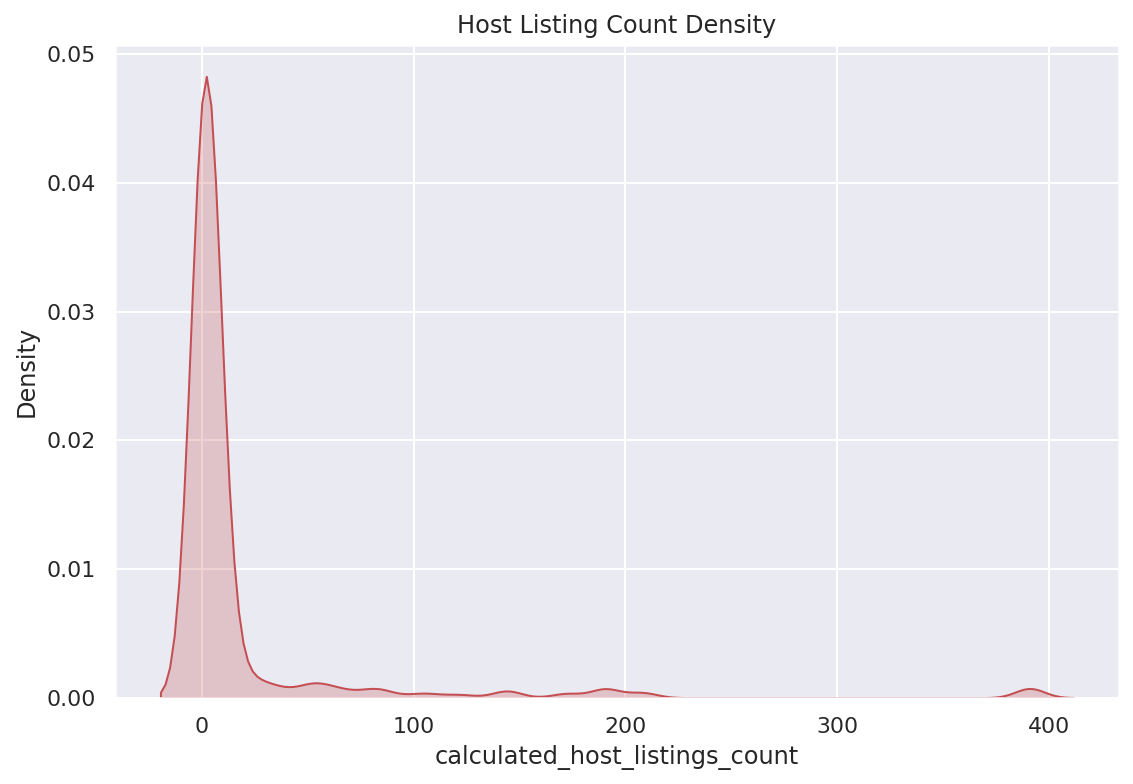

In [ ]:
kde('calculated_host_listings_count',df_listing,'Host Listing Count')

In [ ]:
df_outliers('calculated_host_listings_count',df_listing)

       calculated_host_listings_count
count                     5136.000000
mean                        97.467095
std                        104.058362
min                          9.000000
25%                         22.000000
50%                         54.000000
75%                        145.000000
max                        391.000000


16% of the data seems outliers.

In [ ]:
print(f'The percentage of the outliers in the column: {round(5136/len(df_listing),2)}')

The percentage of the outliers in the column: 0.16


Since it is a very high percentage, we have decided to drop only the visible outliers which the hosts have over a total of 400 calculated listings.

In [ ]:
df_listing=df_listing[df_listing.calculated_host_listings_count<391]

It is the best to bin this column:

In [ ]:
df_listing['total_host_listing_more_than_1']=np.where(df_listing.calculated_host_listings_count>1,1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Drop the original column
df_listing=df_listing.drop('calculated_host_listings_count',axis=1)

Let's take a look at other columns:

In [ ]:
df_listing[['calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','calculated_host_listings_count_entire_homes']]

calculated_host_listings_count_private_rooms  \
0                                                 0   
1                                                 2   
2                                                 0   
3                                                 1   
4                                                 1   
...                                             ...   
33297                                             0   
33298                                             0   
33299                                             0   
33300                                            16   
33302                                             0   

       calculated_host_listings_count_shared_rooms  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
...                                            ...   
33297                                            0   
33298                                            0   
33299                                            0   
33300                                            0   
33302                                            0   

       calculated_host_listings_count_entire_homes  
0                                                3  
1                                                0  
2                                                1  
3                                                0  
4                                                0  
...                                            ...  
33297                                            4  
33298                                            3  
33299                                            5  
33300                                            0  
33302                                            4  

[31391 rows x 3 columns]

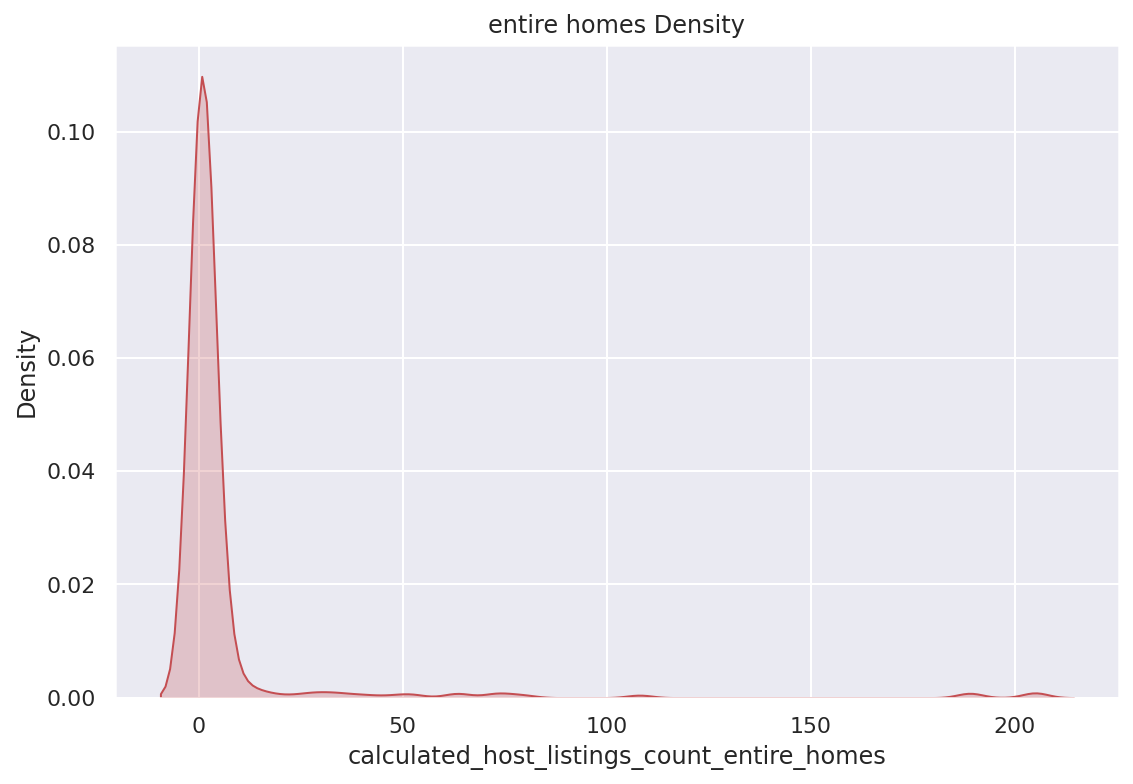

In [ ]:
kde('calculated_host_listings_count_entire_homes',df_listing,'entire homes')

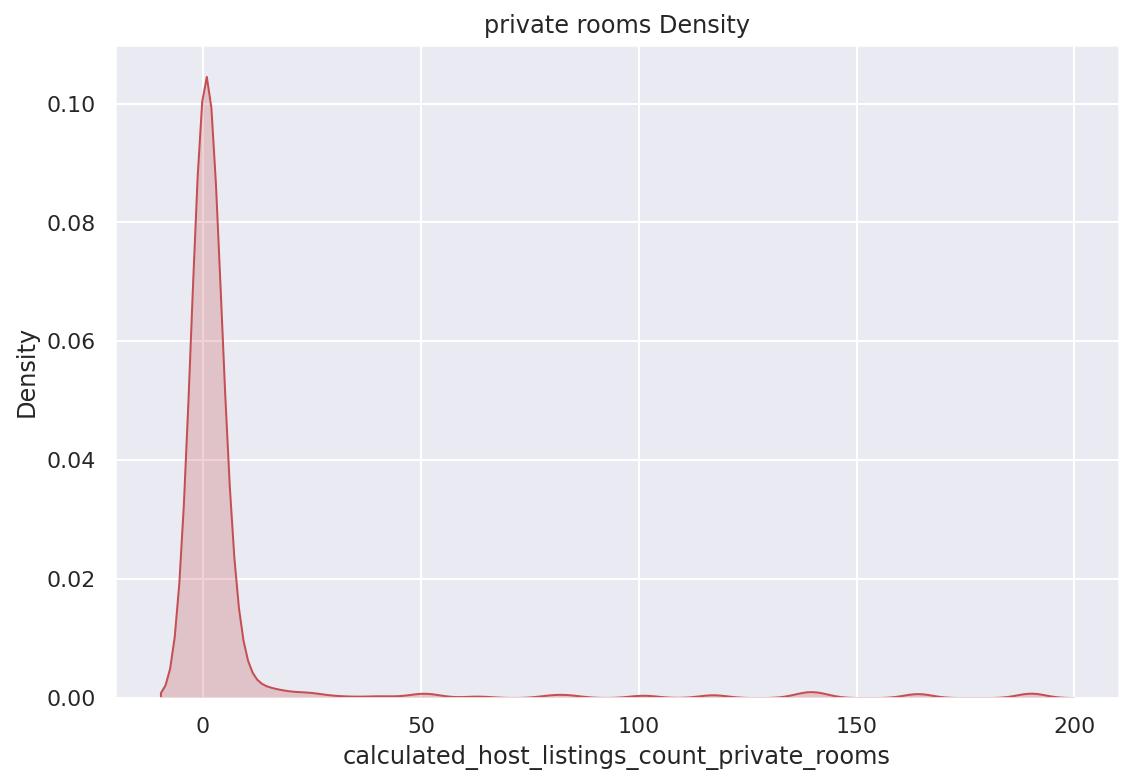

In [ ]:
kde('calculated_host_listings_count_private_rooms',df_listing,'private rooms')

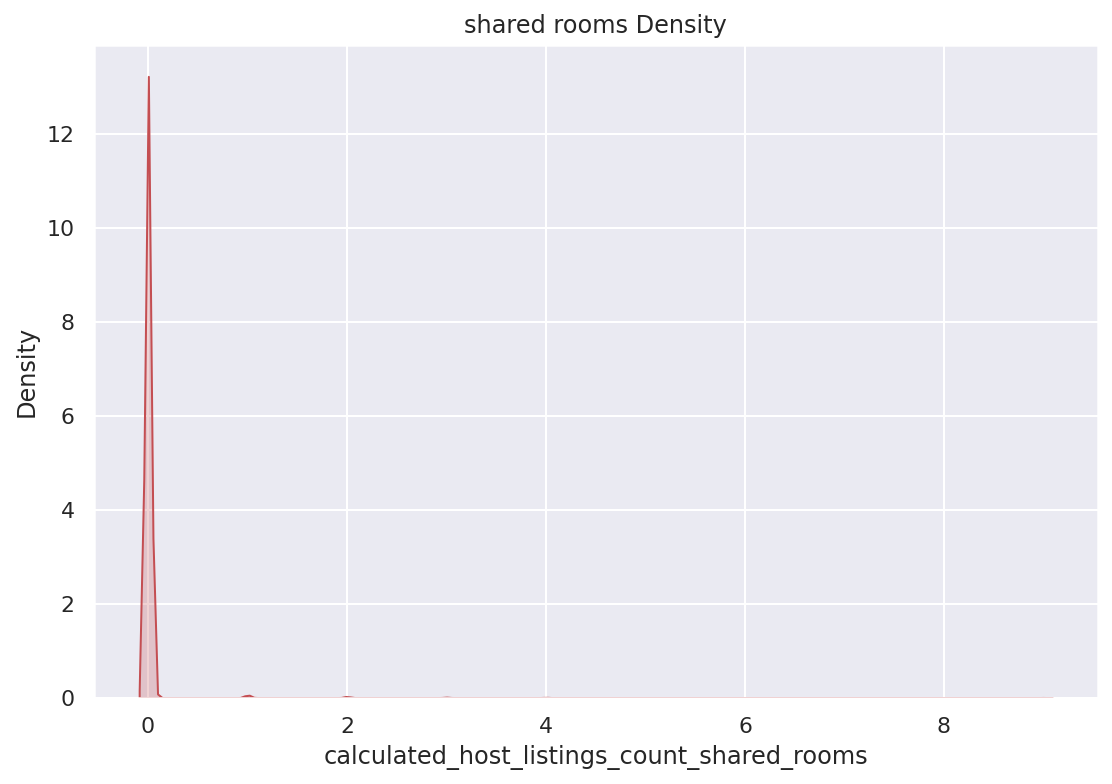

In [ ]:
kde('calculated_host_listings_count_shared_rooms',df_listing,'shared rooms')

In [ ]:
df_listing.calculated_host_listings_count_shared_rooms.value_counts()

0    31129
1      144
2       61
3       25
4       16
9        7
6        5
5        3
8        1
Name: calculated_host_listings_count_shared_rooms, dtype: int64

We will drop all these columns because they do not contain usefull information. Majority of them are zero.

In [ ]:

df_listing=df_listing.drop(columns=['calculated_host_listings_count_shared_rooms','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms'],axis=1)

**17.** `number_of_reviews_l30d`: It represents the number of reviews within 30 last days. We are going to binarize this column. If a listing has at least one review in the last 30 days, the column value will be 1.

In [ ]:
df_listing.number_of_reviews_l30d.value_counts().head()



0    21342
1     3399
2     2172
3     1713
4     1175
Name: number_of_reviews_l30d, dtype: int64

Let's plot the relationship between the number of reviews and the reviews given in the last 30 days:

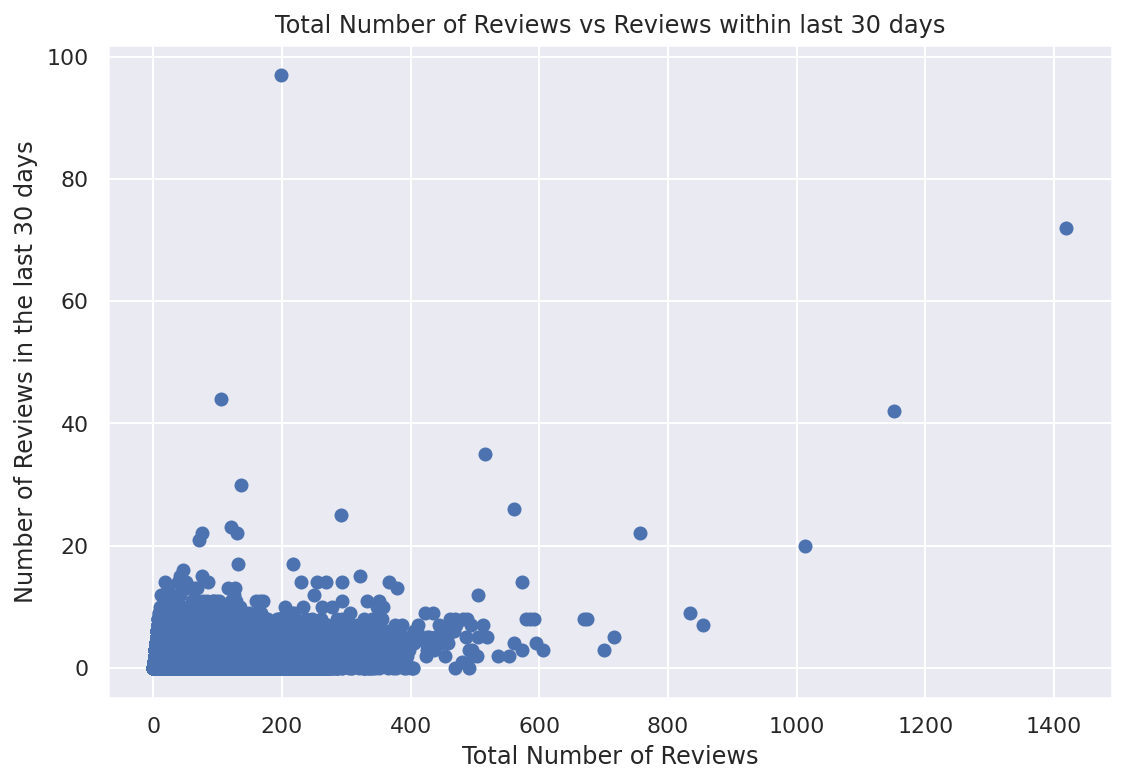

In [ ]:
plt.scatter(x=df_listing.number_of_reviews, y=df_listing.number_of_reviews_l30d)
plt.ylabel('Number of Reviews in the last 30 days')
plt.xlabel('Total Number of Reviews')
plt.title('Total Number of Reviews vs Reviews within last 30 days')
plt.show()

In [ ]:
df_listing['number_of_reviews_l30d']=np.where(df_listing.number_of_reviews_l30d<1,0,1)

**18.**`number_of_reviews_ltm`: Number of reviews in the last month

In [ ]:
df_listing.number_of_reviews_ltm.value_counts()

0      13554
1       2832
2       1898
3       1477
4       1092
       ...  
110        1
139        1
177        1
909        1
136        1
Name: number_of_reviews_ltm, Length: 151, dtype: int64

In [ ]:
# check outliers
df_outliers('number_of_reviews_ltm',df_listing)

       number_of_reviews_ltm
count            4149.000000
mean               42.929140
std                36.365421
min                23.000000
25%                28.000000
50%                36.000000
75%                49.000000
max              1010.000000


13% of them seems to be outliers.

In [ ]:
print(f'The percentage of the outliers in the column: {round(4149/len(df_listing),2)}')

The percentage of the outliers in the column: 0.13


We have decided to drop this column:

In [ ]:
df_listing=df_listing.drop('number_of_reviews_ltm',axis=1)

In [ ]:
df_listing.shape

(31391, 42)

**19.** `review_scores_location`:

In [ ]:
# Calculate the missing values in location review column
print(f'The total missing values in review_scores_location is {df_listing.review_scores_location.isna().sum()}.')

The total missing values in review_scores_location is 3730.


Steps to fill the missing values in `review_scores_location` based on the mean review score value of `neighborhood_cleaned`:

- Calculating the mean review score of each neighborhood.

- Replace the missing values with the mean values.

In [ ]:
# Check if there is any missing values
df_listing[df_listing.review_scores_location.isna()][['neighbourhood_cleansed']].value_counts()

neighbourhood_cleansed
Midtown                   303
Hell's Kitchen            210
Bedford-Stuyvesant        191
Harlem                    170
Upper West Side           164
                         ... 
Emerson Hill                1
Soundview                   1
Eastchester                 1
East Morrisania             1
Allerton                    1
Length: 194, dtype: int64

We can see that the number of listing per neighborhood varies. Some neighborhoods have only 1 listing.

In [ ]:
# Count the number of reviews per neighborhood.a
df_listing.groupby('neighbourhood_cleansed').count()[['id']]


id
neighbourhood_cleansed     
Allerton                 38
Arden Heights             3
Arrochar                 15
Arverne                  91
Astoria                 542
...                     ...
Windsor Terrace          94
Woodhaven                69
Woodlawn                  6
Woodrow                   1
Woodside                354

[240 rows x 1 columns]

In [ ]:
# Fill all the messing vlaues by using np.where and transform functions
values = df_listing.groupby('neighbourhood_cleansed')['review_scores_location'].transform('mean').round().fillna(1)
df_listing['review_scores_location'] = np.where(df_listing['review_scores_location'].notna(),df_listing['review_scores_location'],values).astype(float)

In [ ]:
# Sanity check
df_listing['review_scores_location'].isna().sum()

0

**20.** `Number of Listing per Neighborhood`: We are creating a new column because the competition also impacts the price in other words number of listings in the neighboorhood.

In [ ]:
# Create the new column
df_listing['listing_per_neighborhood']=0

In [ ]:
temp=df_listing.groupby('neighbourhood_cleansed').count()[['id']].reset_index()
temp.rename({'id':'listing_per_neighborhood'}, axis=1, inplace=True)
temp.sort_values(by='listing_per_neighborhood',ascending=False)

neighbourhood_cleansed  listing_per_neighborhood
12      Bedford-Stuyvesant                      2225
233           Williamsburg                      1993
106                 Harlem                      1556
141                Midtown                      1249
107         Hell's Kitchen                      1242
..                     ...                       ...
234            Willowbrook                         1
190              Rossville                         1
91          Fort Wadsworth                         1
238                Woodrow                         1
198            South Beach                         1

[240 rows x 2 columns]

In [ ]:
# Double check the data type
df_listing.listing_per_neighborhood.dtype

dtype('int64')

In [ ]:
# Replace zero values with number of listings per neighborhood
for x in range(0,len(temp)):
  df_listing.loc[df_listing['neighbourhood_cleansed'] == temp['neighbourhood_cleansed'][x], 'listing_per_neighborhood'] = temp['listing_per_neighborhood'][x]

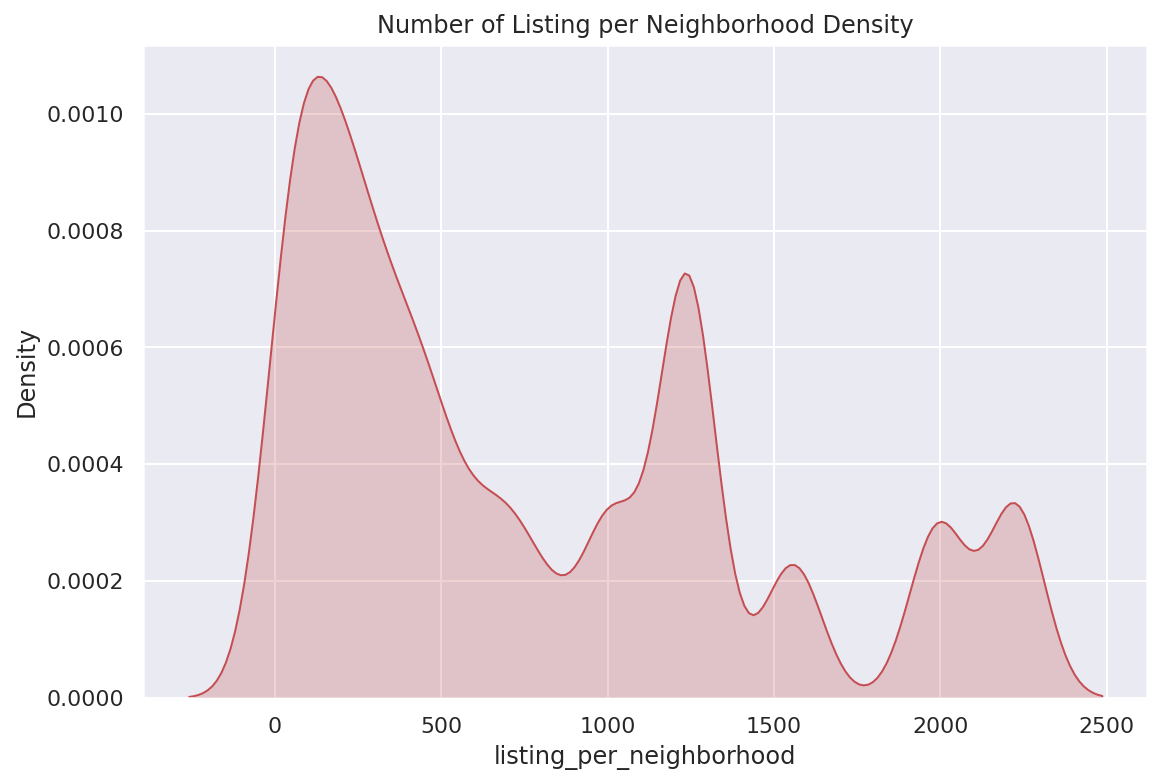

In [ ]:
# Plot the distribution
kde('listing_per_neighborhood',df_listing,'Number of Listing per Neighborhood')

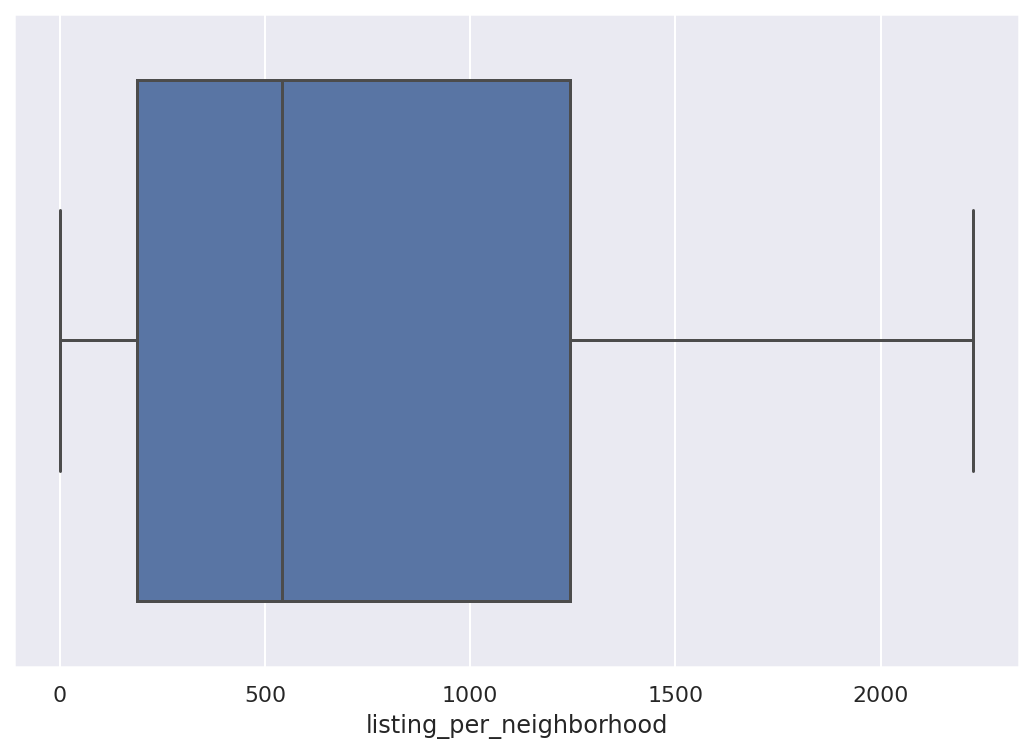

In [ ]:
sns.boxplot(x='listing_per_neighborhood',data=df_listing)

Nice there is no outliers but it is still skewed data. Let's continue to check other columns:

In [ ]:
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
review_scores_value                  0.12
review_scores_cleanliness            0.12
review_scores_checkin                0.12
review_scores_accuracy               0.12
first_review                         0.12
last_review                          0.12
reviews_per_month                    0.12
review_scores_rating                 0.12
bedrooms                             0.10
beds                                 0.02
description                          0.02
bathrooms_text                       0.00
name                                 0.00

**21.** `review_scores_value`, `review_scores_checkin`, `host_response_rate`,`review_scores_cleanliness`, `review_scores_accuracy`, `review_scores_rating`, `reviews_per_month`, and `last_review` : Lastly, we will use the kNN technique to fill the missing values in these columns


In [ ]:
nan_columns=['review_scores_value', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating', 'reviews_per_month']


In [ ]:
for c in nan_columns:
  # define imputer
  imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
  # fit on the dataset
  df_listing[c]= imputer.fit_transform(df_listing[[c]]).round(2)
  # transform the dataset

  # print total missing value percentages again
  print(f' Number of missing values in column {c}:  {df_listing[c].isna().sum()}')

 Number of missing values in column review_scores_value:  0
 Number of missing values in column review_scores_checkin:  0
 Number of missing values in column review_scores_cleanliness:  0
 Number of missing values in column review_scores_accuracy:  0
 Number of missing values in column review_scores_rating:  0
 Number of missing values in column reviews_per_month:  0


In [ ]:
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
first_review              0.12
last_review               0.12
bedrooms                  0.10
beds                      0.02
description               0.02
bathrooms_text            0.00
name                      0.00

24. `bedrooms`: We observe some outliers and will use capping method to treat them.

In [ ]:
df_listing.bedrooms.value_counts()

1.0     20977
2.0      5013
3.0      1726
4.0       434
5.0        97
6.0        37
7.0        10
8.0         8
9.0         4
14.0        1
10.0        1
15.0        1
11.0        1
13.0        1
Name: bedrooms, dtype: int64

In [ ]:
# Check nan values
df_listing.bedrooms.isna().sum()

3080

In [ ]:
# Use KNN method to refill the missing values
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# fit on the dataset
df_listing['bedrooms']= imputer.fit_transform(df_listing[['bedrooms']]).round()
# transform the dataset

# print total missing value percentages again
print(f' Number of missing values in bedrooms column:  {df_listing.bedrooms.isna().sum()}')

 Number of missing values in bedrooms column:  0


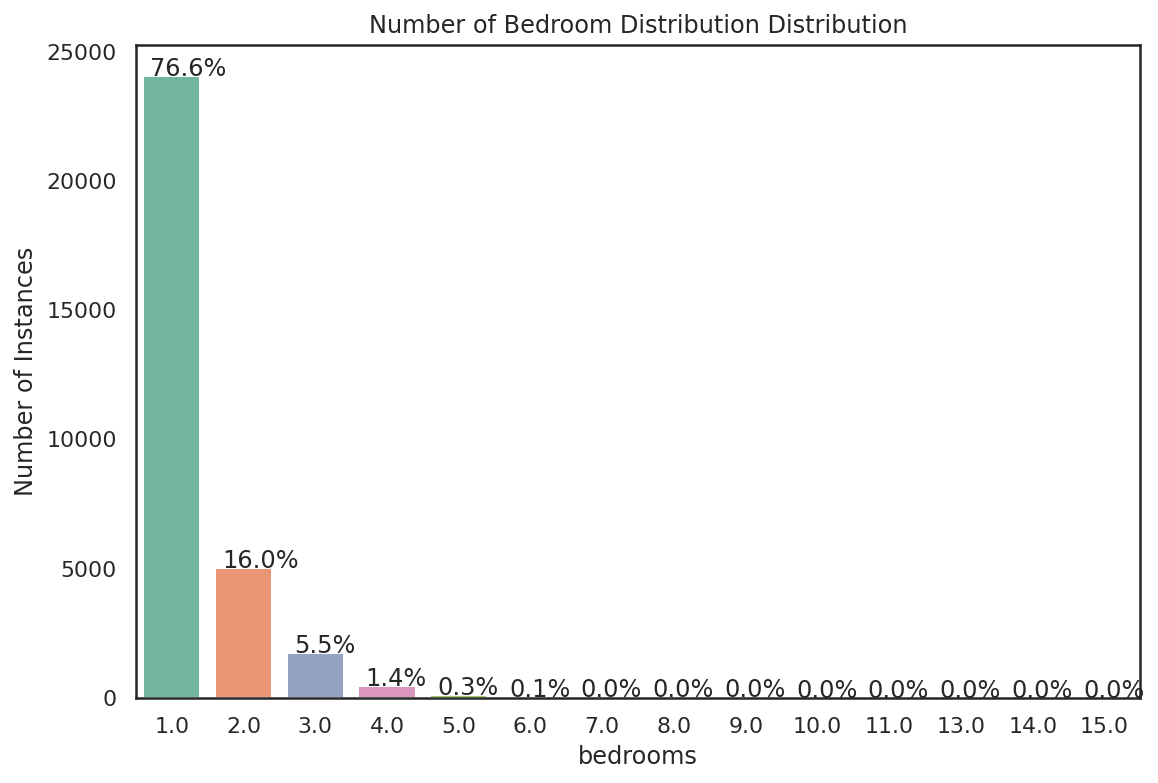

In [ ]:
# Plot the distribution
perc_graph('bedrooms', df_listing, 'Number of Bedroom Distribution')

In [ ]:
# check outliers
df_outliers('bedrooms',df_listing)

          bedrooms
count  7334.000000
mean      2.437960
std       0.811857
min       2.000000
25%       2.000000
50%       2.000000
75%       3.000000
max      15.000000


Well, we cannot cap 7346 rows. Instead we will cap only 595 listings (3 bedrooms and more). We may even drop this column due to its correlation with `accommodates` column.

In [ ]:
print(f'The percentage of the outliers in the column: {round(595/len(df_listing),2)}')

The percentage of the outliers in the column: 0.02


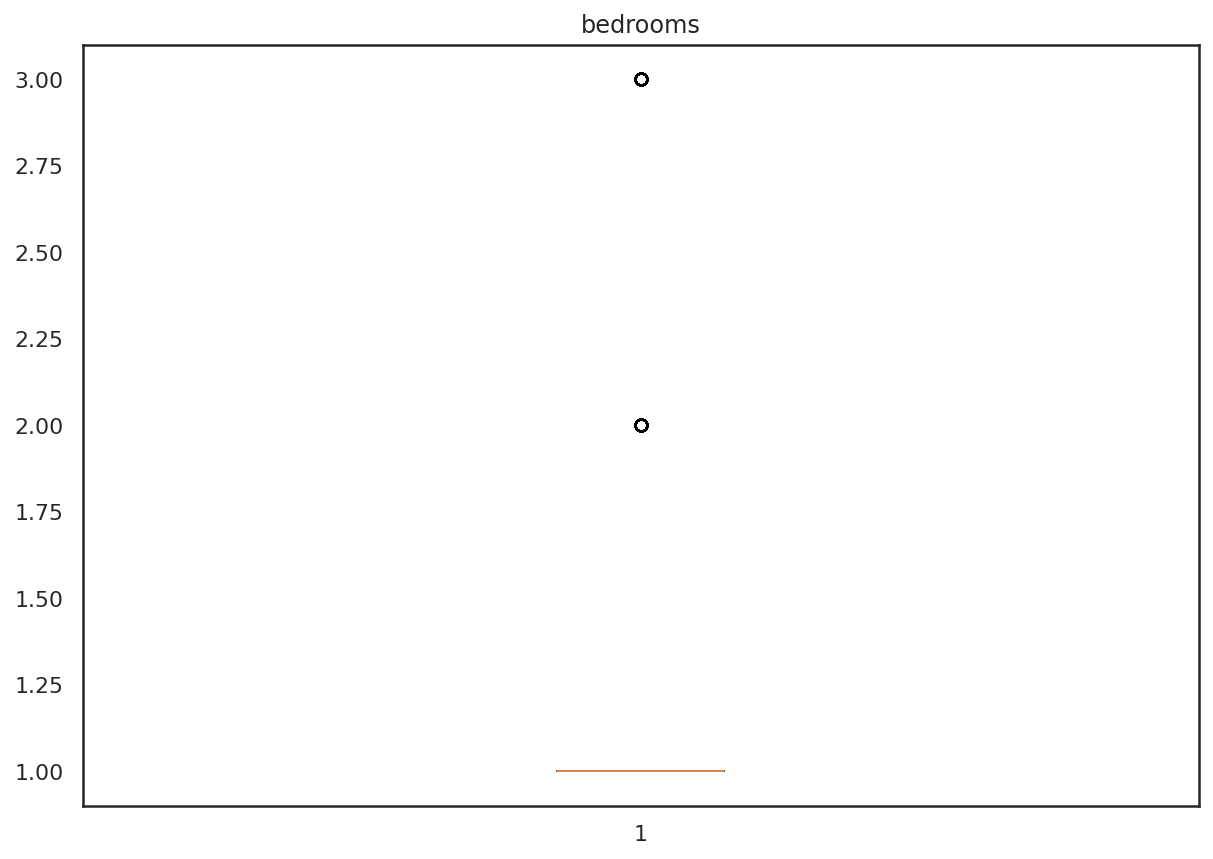

In [ ]:
capping('bedrooms',df_listing,0.0,0.98)

In [ ]:
df_listing.bedrooms.value_counts()

1.0    24057
2.0     5013
3.0     2321
Name: bedrooms, dtype: int64

25. `beds`: Again we observed some outliers and decided to fill the missing values according to the mean of the bedroom column.

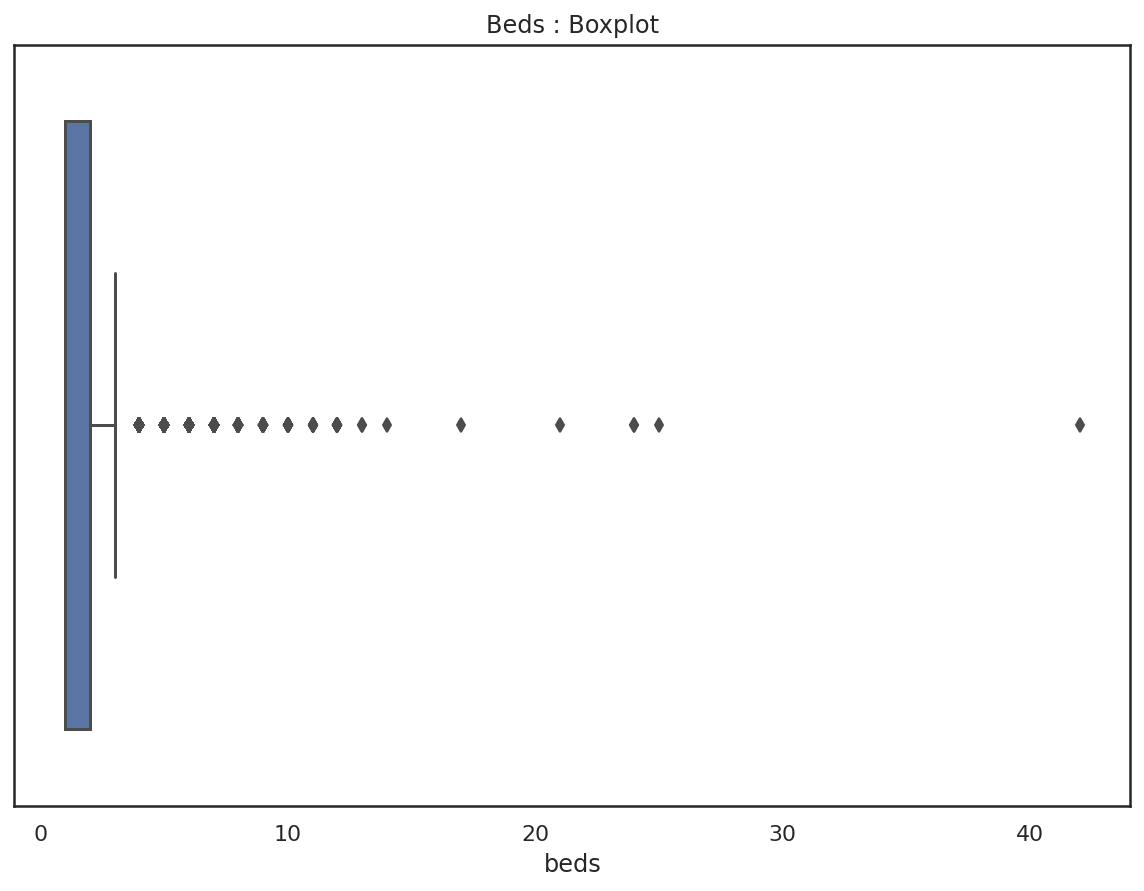

In [ ]:
plt.figure(figsize =(10, 7))
 
# Creating plot
sns.boxplot(data=df_listing, x='beds').set_title('Beds : Boxplot')

plt.show()


Before removing the outliers, we are able to get rid of the NaN values in `beds` column too.

In [ ]:
# Check nan values
df_listing.beds.isna().sum()

630

In [ ]:
# Fill missing values based on the mean of bedroom numbers:

# Calculate the mean review_score_communication values per host response time again
nan_df=df_listing.groupby('bedrooms').mean().round()[['beds']].reset_index()
nan_df

bedrooms  beds
0       1.0   1.0
1       2.0   2.0
2       3.0   4.0

In [ ]:
#use groupby and transform to find mean then fillna with 1
values = df_listing.groupby('bedrooms')['beds'].transform('mean').round().fillna(1)

In [ ]:
# Fill the missing values
df_listing['beds'] = np.where(df_listing['beds'].notna(),df_listing['beds'],values).astype(int)

In [ ]:
# Check nan values
df_listing.beds.isna().sum()

0

In [ ]:
df_outliers('beds',df_listing)

              beds
count  2044.000000
mean      4.934442
std       1.880577
min       4.000000
25%       4.000000
50%       4.000000
75%       5.000000
max      42.000000


6% of the data is outliers so we can cap them.

In [ ]:
print(f'The percentage of the outliers in the column: {round(2044/len(df_listing),2)}')

The percentage of the outliers in the column: 0.07


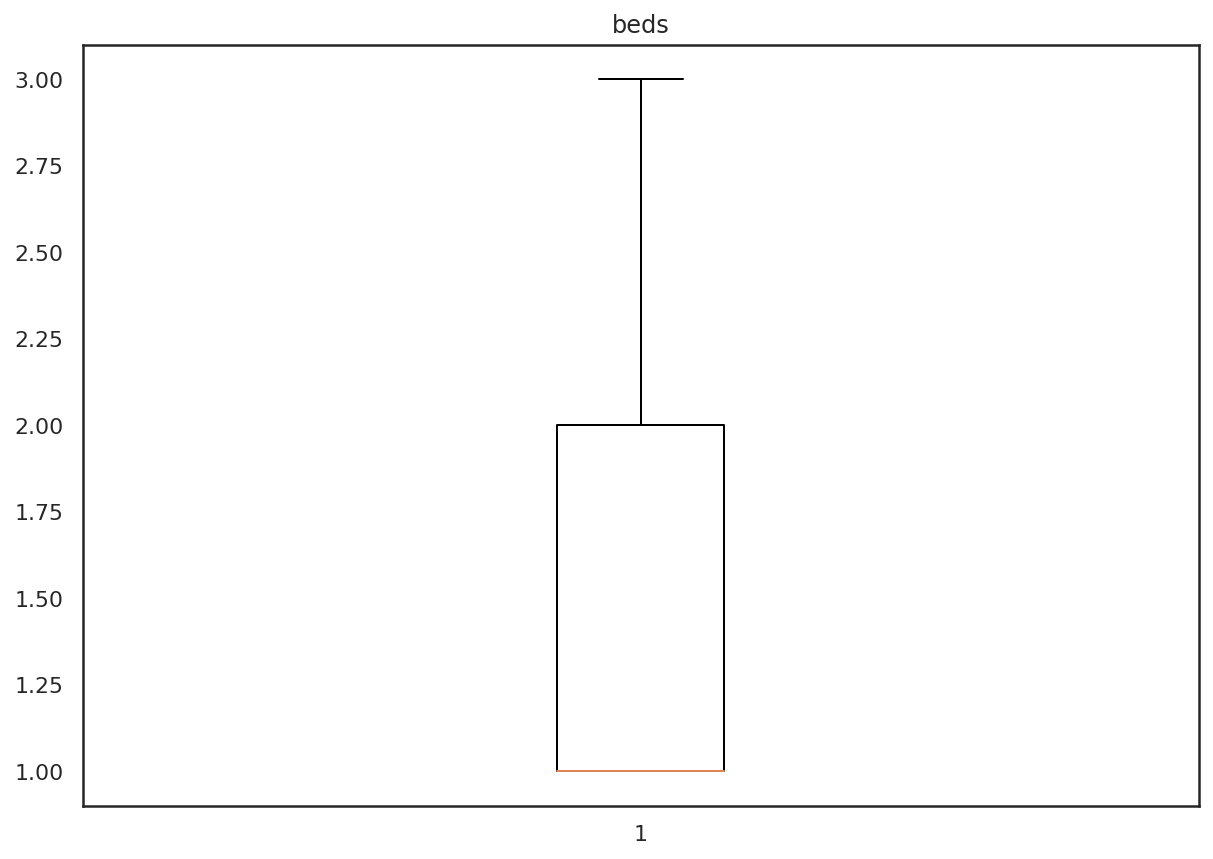

In [ ]:
capping('beds',df_listing,0.0,0.93)

In [ ]:
df_listing.beds.value_counts()

1.0    19536
2.0     7049
3.0     4806
Name: beds, dtype: int64

Perfect no more outliers!


**26.** `bathrooms_text`: We will change the name to bathroom and check if there are any outliers.

In [ ]:
# Rename the column
df_listing.rename(columns={'bathrooms_text':'bathrooms'},errors="raise", inplace=True)



In [ ]:
# Unique bahtroom entry types
df_listing.bathrooms.unique()

array(['1 bath', nan, '1.5 baths', '1 shared bath', '1 private bath',
       'Shared half-bath', '2 baths', '3 baths', 'Half-bath', '2.5 baths',
       '1.5 shared baths', '2 shared baths', '0 shared baths',
       'Private half-bath', '4.5 baths', '3.5 baths', '2.5 shared baths',
       '0 baths', '15.5 baths', '4 baths', '3 shared baths',
       '4 shared baths', '5 baths', '6 baths', '15 baths',
       '3.5 shared baths', '4.5 shared baths', '7.5 baths', '5.5 baths',
       '6.5 baths', '7 baths', '8 baths', '6 shared baths'], dtype=object)

There are interesting terms such as 0 shared baths or 0 baths. We believe that shared bath and private bath should matter for the visitors. Therefore we have decided to remove the outliers, and use one hot encoder to convert them to binary columns.

In [ ]:
df_listing.bathrooms.value_counts()

1 bath               16686
1 shared bath         7313
1 private bath        2204
2 baths               1994
1.5 baths              842
2 shared baths         775
1.5 shared baths       546
2.5 baths              287
3 baths                173
0 shared baths          93
2.5 shared baths        80
3 shared baths          79
3.5 baths               73
4 baths                 66
0 baths                 35
Half-bath               28
4.5 baths               19
Shared half-bath        16
4 shared baths          15
Private half-bath        8
5 baths                  6
6 baths                  5
5.5 baths                4
7.5 baths                2
8 baths                  2
6 shared baths           2
4.5 shared baths         2
3.5 shared baths         1
6.5 baths                1
7 baths                  1
15.5 baths               1
15 baths                 1
Name: bathrooms, dtype: int64

Even though some listings include 0 shared baths, actually almost half of the listing name says shared bathroom. We have also detected name and description columns including such as room across bathroom or private bathroom. We will count them as 1 shared bathroom.

In [ ]:
temp=df_listing[(df_listing.bathrooms=='0 shared baths') & ((df_listing.description.str.contains('bath')) |(df_listing.name.str.contains('bath')))][['name','description','bathrooms']]
temp.head(20)

name  \
415               Beautiful Private Bedroom - Downstairs   
1358                         Smell the Roses in Brooklyn   
7388                         Private room in Astoria, NY   
10971        house on the hill with free parking in NYC!   
11328  •COZY APARTMENT IN BEDFORD AREA, 5 MINS MANHAT...   
21741                  Nice private bedroom in Manhattan   
21755                                       Paz and love   
22076                 A Quiet Cabin/Pod in a noisy city.   
22894                 Clean..Blue Door Studio Hall in BK   
23506                     YONKERS CLOSE TO MANHATTAN # 1   
25491               Private Room at Rogers on B 116th St   
26544   ♔ Quant Centrally Located Room,Near Subway,Pratt   
26897                                Eden By The Park 06   
28187             Private Apartment/ Shared Bathroom 517   
28190              Private Apartment/Shared Bathroom 525   
28192             Private Apartment/ Shared Bathroom 528   
28193             Private Apartment/ Shared Bathroom 630   
28194             Private Apartment/ Shared Bathroom 676   
28195             Private Apartment/ Shared Bathroom 741   
28196             Private Apartment/ Shared Bathroom 724   

                                             description       bathrooms  
415    Cozy bedroom in a 100 year old Brownstone loca...  0 shared baths  
1358   Our cozy cocoon is located in the heart of Bed...  0 shared baths  
7388   Great location, close to Manhattan <br />.<br ...  0 shared baths  
10971  We are located on Staten Island, Very easy and...  0 shared baths  
11328  Hi everyone and welcome to my lovely apartment...  0 shared baths  
21741  I renting one private room in my 3 bedroom apa...  0 shared baths  
21755  This room has a  large room and  private bathr...  0 shared baths  
22076  A unique single occupancy cabin in a vegetaria...  0 shared baths  
22894  Clean, open studio space for small gatherings ...  0 shared baths  
23506  Spacious, renovated room on the third floor. Q...  0 shared baths  
25491  Private Guest suite located in Rockaway Beach....  0 shared baths  
26544  Welcome to our Boutique BNB, We are located le...  0 shared baths  
26897  A Private Bedroom & Full-Size Bed in a brand n...  0 shared baths  
28187  A small unit which sleeps two people on a full...  0 shared baths  
28190  Lovely unit which sleeps two people on a full ...  0 shared baths  
28192  A small unit which sleeps two people on a full...  0 shared baths  
28193  A lovely unit which sleeps two people on a ful...  0 shared baths  
28194  A lovely unit which sleeps two people on a ful...  0 shared baths  
28195  A lovely unit which sleeps two people on a ful...  0 shared baths  
28196  A lovely unit which sleeps two people on a ful...  0 shared baths

In [ ]:
temp.shape

(51, 3)

We will create two columns: `shared bathroom` and `number of bathrooms`

In [ ]:
df_listing['shared_bathroom']=np.where(df_listing['bathrooms'].str.contains('shared'),1,0)

df_listing['shared_bathroom'].value_counts()

0    22454
1     8937
Name: shared_bathroom, dtype: int64

In [ ]:
# Extract only float numbers from the column by using regex
df_listing['bathroom_number']=df_listing['bathrooms'].str.extractall('([-+]?\d*\.\d+|\d+)').unstack().fillna('').sum(axis=1).astype(float)

In [ ]:
df_listing['bathroom_number']

0        1.0
1        NaN
2        1.5
3        1.0
4        1.0
        ... 
33297    2.0
33298    1.0
33299    3.0
33300    1.0
33302    1.0
Name: bathroom_number, Length: 31391, dtype: float64

In [ ]:
 df_listing[df_listing['bathroom_number']==0][['bathrooms','bathroom_number']]

bathrooms  bathroom_number
415    0 shared baths              0.0
688    0 shared baths              0.0
689    0 shared baths              0.0
1259          0 baths              0.0
1279          0 baths              0.0
...               ...              ...
32216  0 shared baths              0.0
32253  0 shared baths              0.0
32825         0 baths              0.0
33155  0 shared baths              0.0
33212         0 baths              0.0

[128 rows x 2 columns]

In [ ]:
# Replace all zeros with ones

df_listing.bathroom_number=np.where(df_listing.bathroom_number==0.0, 1.0, df_listing.bathroom_number)

In [ ]:
df_listing.bathroom_number.value_counts()

1.0     26331
2.0      2769
1.5      1388
2.5       367
3.0       252
4.0        81
3.5        74
4.5        21
6.0         7
5.0         6
5.5         4
7.5         2
8.0         2
15.5        1
15.0        1
6.5         1
7.0         1
Name: bathroom_number, dtype: int64

In [ ]:

print(f'Total number of missing bathroom values is {df_listing.bathroom_number.isna().sum()}.')

Total number of missing bathroom values is 83.


In [ ]:
# Fill missing values based on the mean of bedroom numbers:

# Calculate the mean review_score_communication values per host response time again
nan_df=df_listing.groupby('bedrooms').mean().round()[['bathroom_number']].reset_index()
nan_df

bedrooms  bathroom_number
0       1.0              1.0
1       2.0              1.0
2       3.0              2.0

In [ ]:
#use groupby and transform to find mean then fillna with 1
values = df_listing.groupby('bedrooms')['bathroom_number'].transform('mean').round().fillna(1)

df_listing['bathroom_number'] = np.where(df_listing['bathroom_number'].notna(),df_listing['bathroom_number'],values).astype(float)

In [ ]:
# Sanity check
print(f'Total number of missing bathroom values is {df_listing.bathroom_number.isna().sum()}.')

Total number of missing bathroom values is 0.


In [ ]:
# check outliers

df_outliers('bathroom_number',df_listing)

       bathroom_number
count      4977.000000
mean          2.037372
std           0.641784
min           1.500000
25%           1.500000
50%           2.000000
75%           2.000000
max          15.500000


Again it is the best to bin the column as follows:

In [ ]:
df_listing['bathroom_more_than_1']=np.where(df_listing.bathroom_number>1.0, 1, 0)

In [ ]:
df_listing['bathroom_more_than_1'].value_counts()

0    26414
1     4977
Name: bathroom_more_than_1, dtype: int64

In [ ]:
# Drop the column
df_listing=df_listing.drop(columns=['bathrooms'],axis=1)  #'bedrooms'

# Check
df_listing.columns

Index(['id', 'name', 'description', 'host_id', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_verifications', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month', 'host_since_months',
       'total_host_listing_more_than_1', 'listing_per_neighborhood',
       'shared_bathroom', 'bathroom_number', 'bathroom_more_than_1'],
 

Let's continue to clean the missing values:

In [ ]:
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
first_review            0.12
last_review             0.12
description             0.02
name                    0.00

**27.**`first_review`& `last_review` : The data extraction date was 3 June 2022. We can calculate the number of weeks between the earliest and latest review dates and June 3rd 2022 and convert them into a numerical value.

In [ ]:
# Quick look
df_listing.last_review.value_counts()

2022-05-30    978
2022-05-29    795
2022-05-22    644
2022-05-31    618
2022-05-20    484
             ... 
2019-01-26      1
2017-03-12      1
2015-11-06      1
2016-11-03      1
2021-05-13      1
Name: last_review, Length: 2500, dtype: int64

We need to change its data type to datetime:

In [ ]:
df_listing['last_review']=pd.to_datetime(df_listing['last_review'])

In [ ]:
# Find the number of the reviews per date
temp=pd.DataFrame(df_listing.last_review.value_counts())
temp

last_review
2022-05-30          978
2022-05-29          795
2022-05-22          644
2022-05-31          618
2022-05-20          484
...                 ...
2019-01-26            1
2017-03-12            1
2015-11-06            1
2016-11-03            1
2021-05-13            1

[2500 rows x 1 columns]

In [ ]:
first_review_day=temp.index.min()
last_review_day=temp.index.max()


print(f'the first and last review dates are {first_review_day} & {last_review_day} ,respectively')

the first and last review dates are 2011-05-12 00:00:00 & 2022-06-03 00:00:00 ,respectively


In [ ]:
df_listing[df_listing.last_review=='2011-12-10']

id                    name  \
57  27883  East Village Sanctuary   

                                    description  host_id  host_location  \
57  Sorry, this listing is no longer available.   120223              0   

   host_response_time host_response_rate host_acceptance_rate  \
57     within an hour            76-100%              76-100%   

    host_is_superhost                                 host_thumbnail_url  ...  \
57                0.0  https://a0.muscache.com/im/pictures/user/39d3a...  ...   

   review_scores_location review_scores_value  instant_bookable  \
57                   4.79                4.74                 0   

   reviews_per_month host_since_months  total_host_listing_more_than_1  \
57              0.18             144.0                               0   

    listing_per_neighborhood shared_bathroom  bathroom_number  \
57                       816               0              1.0   

    bathroom_more_than_1  
57                     0  

[1 rows x 45 columns]

In [ ]:
df_listing.first_review=df_listing.first_review.astype('datetime64')

In [ ]:
# Calculating the number of weeks
df_listing['first_review_week'] = (pd.datetime(2022, 6, 3) - df_listing.first_review).astype('timedelta64[W]')

df_listing['first_review_week']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



0        653.0
1        679.0
2        439.0
3        682.0
4        664.0
         ...  
33297      NaN
33298      NaN
33299      NaN
33300      NaN
33302      NaN
Name: first_review_week, Length: 31391, dtype: float64

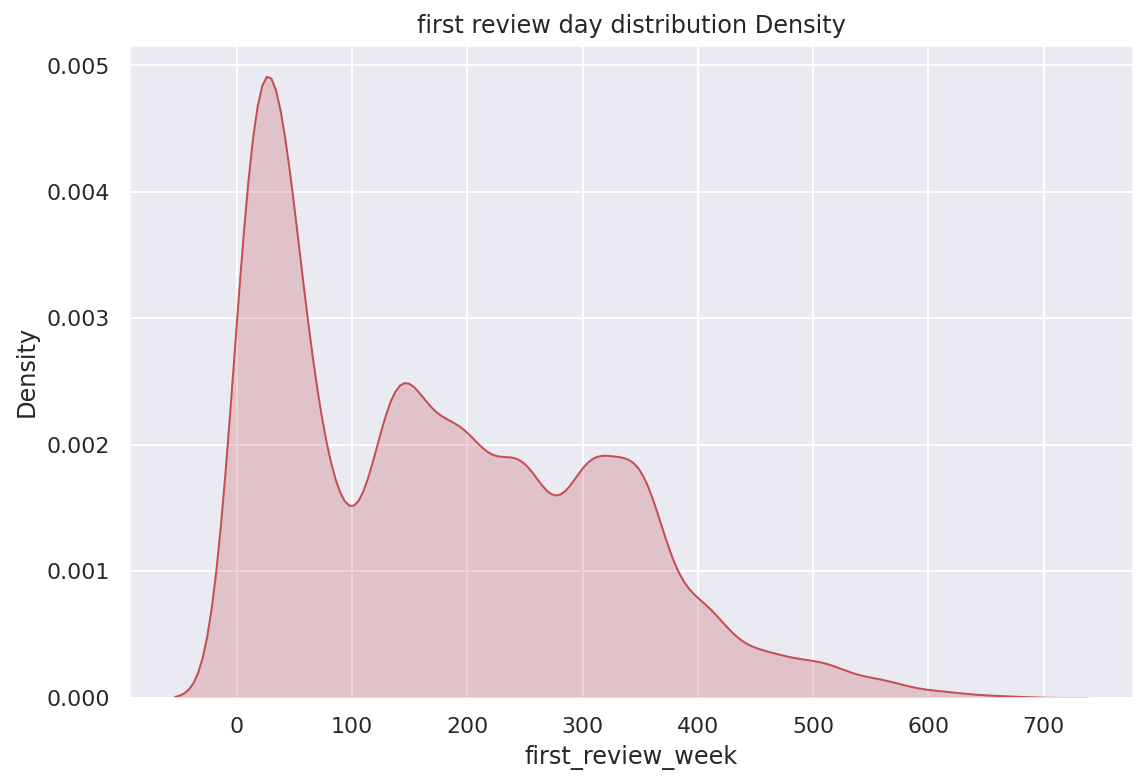

In [ ]:
kde('first_review_week',df_listing,'first review day distribution')

We have a right skewed distribution.

In [ ]:
df_listing.first_review_week.dtype

dtype('float64')

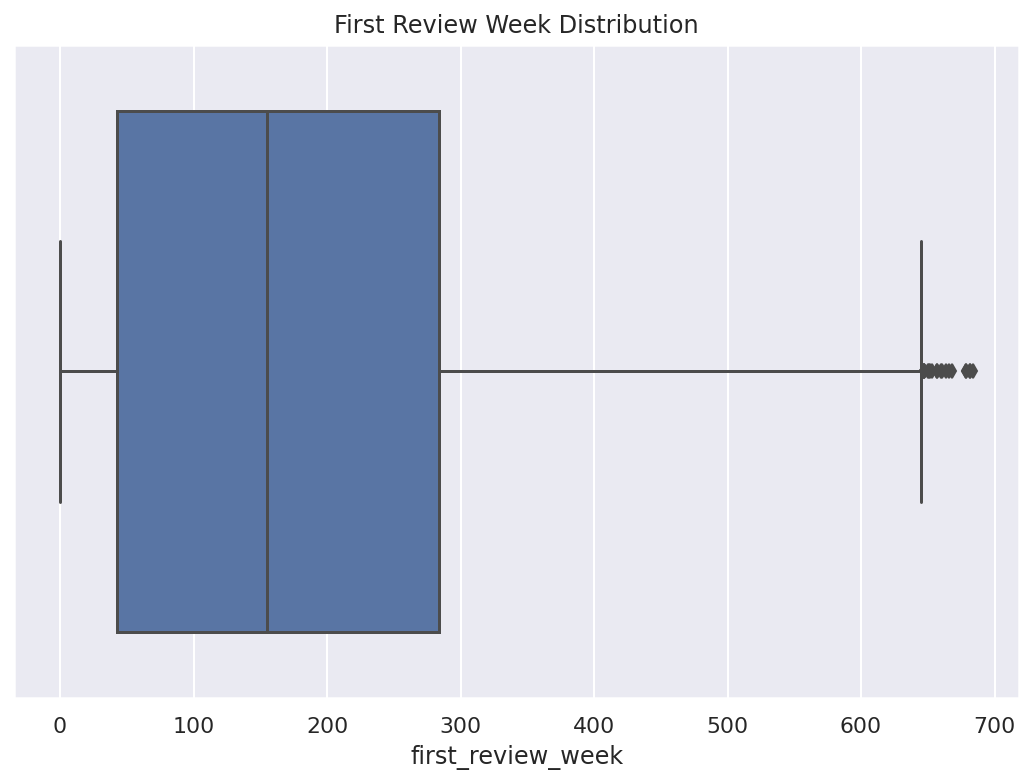

In [ ]:
sns.boxplot(x='first_review_week',data=df_listing)
plt.title('First Review Week Distribution')
plt.show()

In [ ]:
df_listing.first_review_week.describe()

count    27698.000000
mean       175.577876
std        139.428157
min          0.000000
25%         43.000000
50%        155.000000
75%        284.000000
max        684.000000
Name: first_review_week, dtype: float64

Let's follow the steps to examine `last_review` column:

In [ ]:
df_listing.last_review=df_listing.last_review.astype('datetime64')

In [ ]:
# Calculating the number of weeks
df_listing['last_review_week'] = (pd.datetime(2022, 6, 3) - df_listing.last_review).astype('timedelta64[W]')

df_listing['last_review_week']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



0        134.0
1        130.0
2         42.0
3          3.0
4        254.0
         ...  
33297      NaN
33298      NaN
33299      NaN
33300      NaN
33302      NaN
Name: last_review_week, Length: 31391, dtype: float64

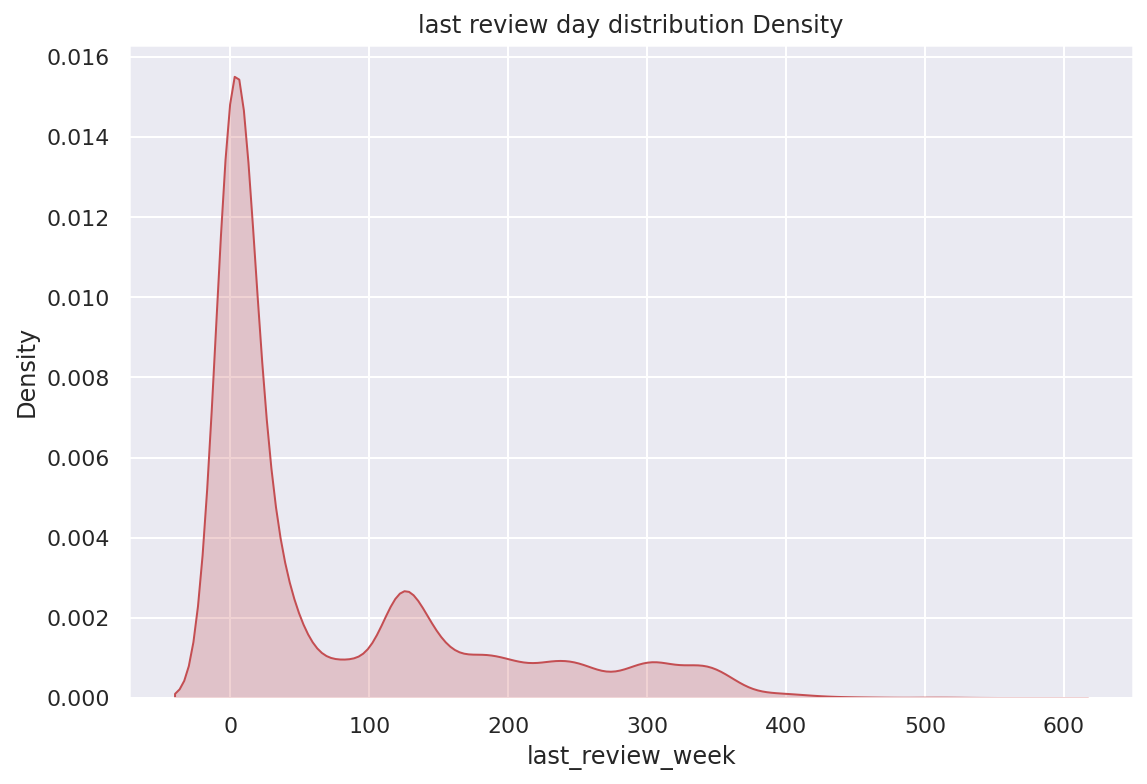

In [ ]:
kde('last_review_week',df_listing,'last review day distribution')

We will fill the missing values using KNN in both columns:

In [ ]:
# Use KNN method for missing values
nan_columns=['last_review_week','first_review_week']
for c in nan_columns:
  # define imputer
  imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
  # fit on the dataset
  df_listing[c]= imputer.fit_transform(df_listing[[c]]).round()
  # transform the dataset

  # print total missing value percentages again
  print(f' Number of missing values in column {c}:  {df_listing[c].isna().sum()}')

 Number of missing values in column last_review_week:  0
 Number of missing values in column first_review_week:  0


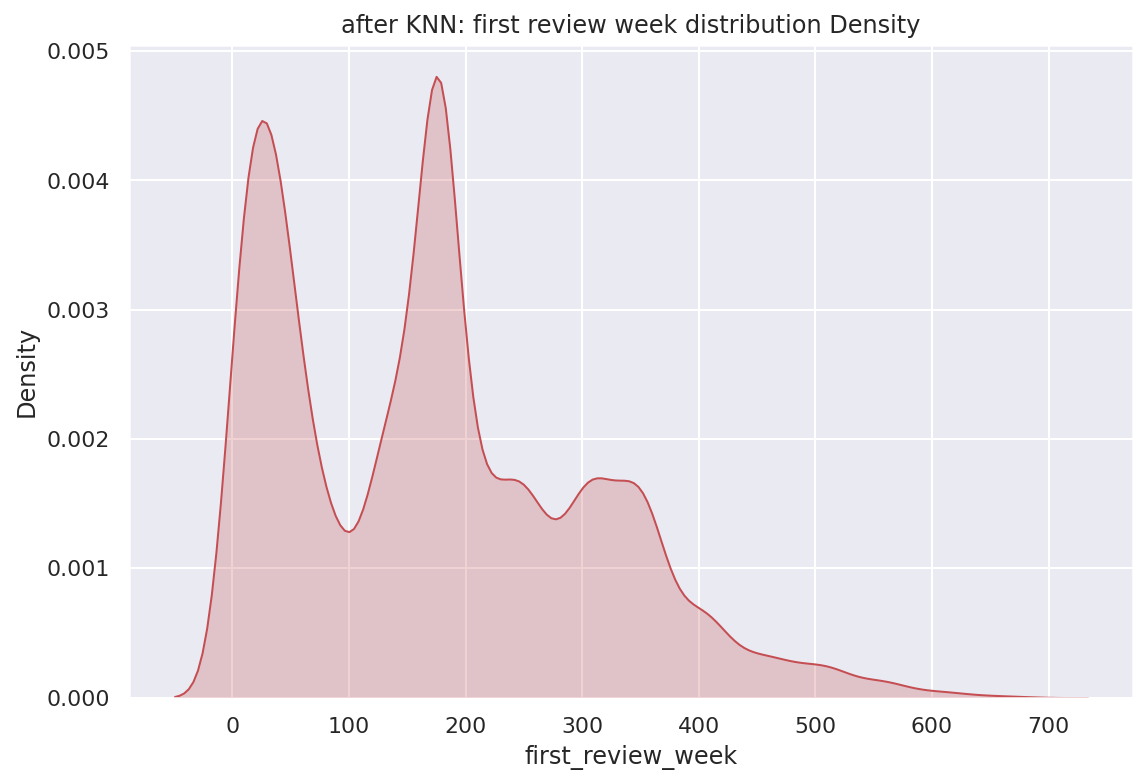

In [ ]:
kde('first_review_week',df_listing,'after KNN: first review week distribution')

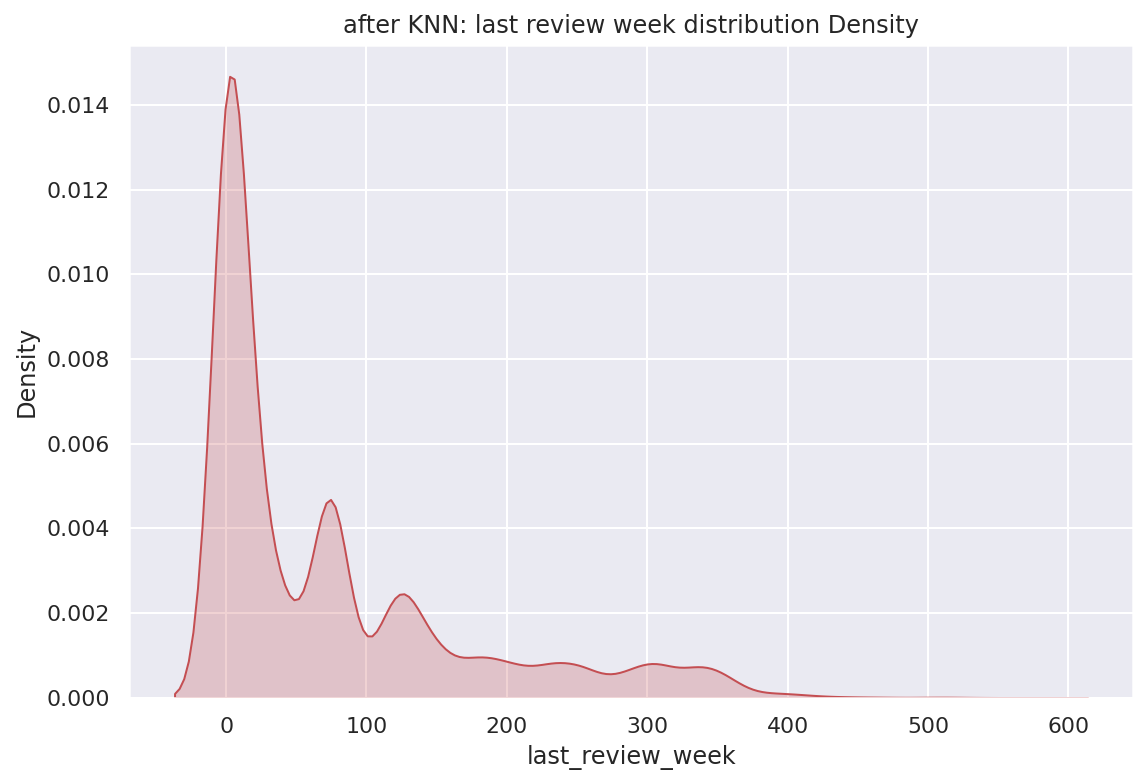

In [ ]:
kde('last_review_week',df_listing,'after KNN: last review week distribution')

In [ ]:
df_outliers('last_review_week',df_listing)

       last_review_week
count       1961.000000
mean         334.161652
std           35.289139
min          290.000000
25%          308.000000
50%          334.000000
75%          350.000000
max          577.000000


In [ ]:
print(f'The percentage of the outliers in the column: {round(1961/len(df_listing),2)}')

The percentage of the outliers in the column: 0.06


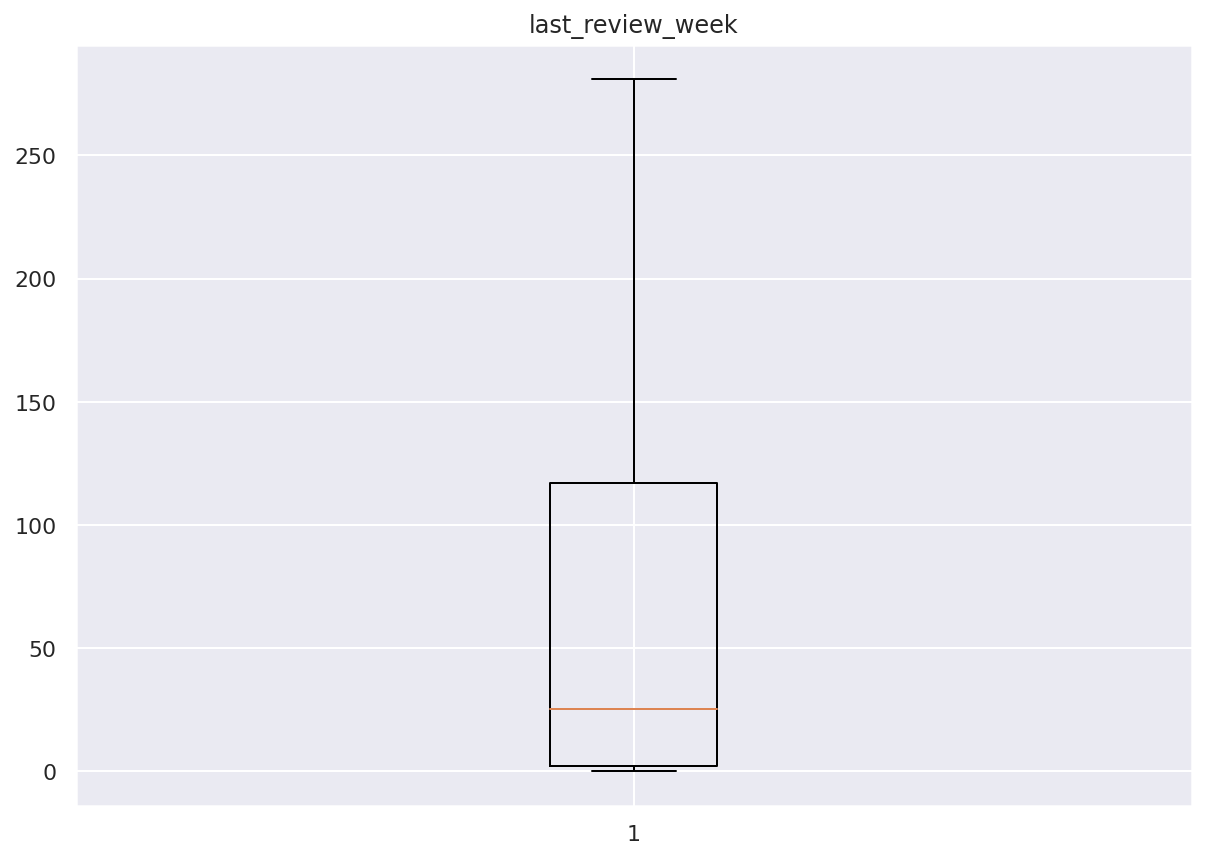

In [ ]:
capping('last_review_week',df_listing,0.0,0.93)

In [ ]:
df_outliers('first_review_week',df_listing)

       first_review_week
count         124.000000
mean          610.217742
std            28.735848
min           574.000000
25%           586.000000
50%           606.500000
75%           625.250000
max           684.000000


In [ ]:
print(f'The percentage of the outliers in the column: {round(124/len(df_listing),2)}')

The percentage of the outliers in the column: 0.0


Less than 1% of the data is outliers so we will skip this column.

We can drop the original `first_review` and `last_review` columns 

In [ ]:
# Drop the column
df_listing=df_listing.drop(columns=['last_review','first_review'],axis=1)

# Check
df_listing.columns

Index(['id', 'name', 'description', 'host_id', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_verifications', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'host_since_months', 'total_host_listing_more_than_1',
       'listing_per_neighborhood', 'shared_bathroom', 'bathroom_number',
       'bathroom_more_than_1', 'first_review_week', 'last_review

**28.**`minimum_nights` & `maximum_nights`: There are some irrelevant numbers such that the maximum value of the minimum nights that a visitor must stay is 1250. When we are addressing the outliers, we will be able to drop them.

In [ ]:
df_listing[['minimum_nights','maximum_nights']].describe()

minimum_nights  maximum_nights
count    31391.000000    3.139100e+04
mean        17.969928    7.027646e+04
std         32.188835    1.212173e+07
min          1.000000    1.000000e+00
25%          2.000000    4.000000e+01
50%          7.000000    3.650000e+02
75%         30.000000    1.125000e+03
max       1250.000000    2.147484e+09

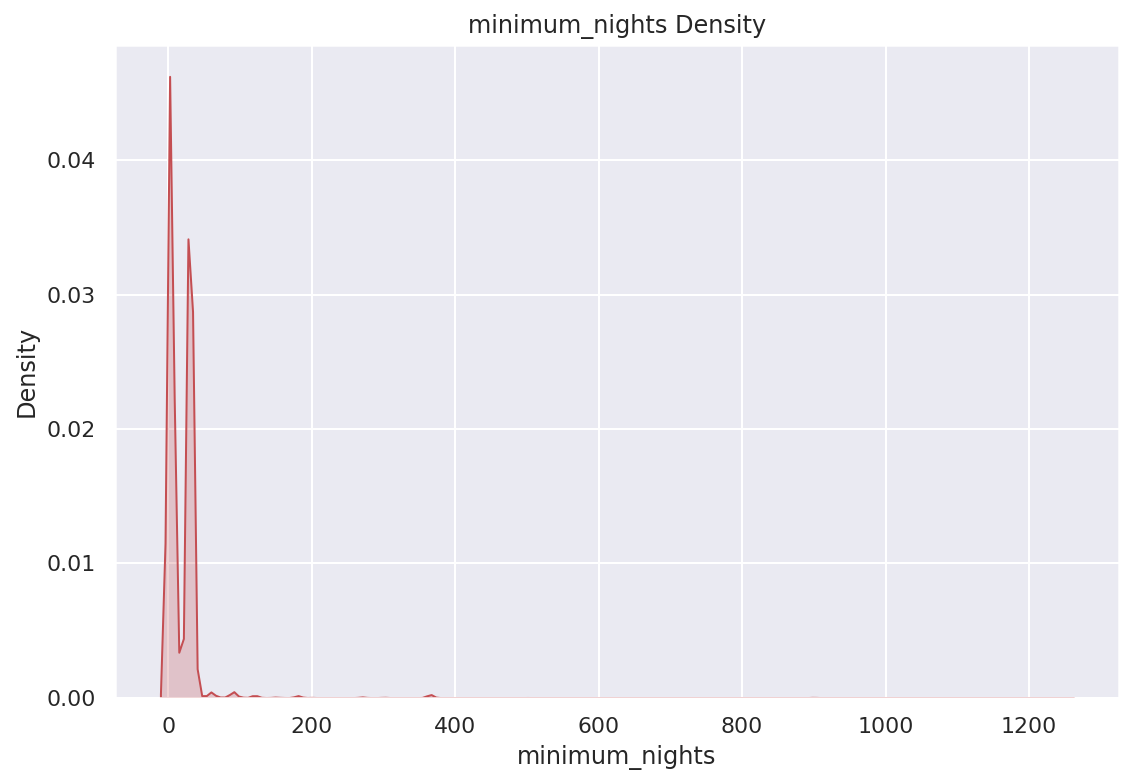

In [ ]:
kde('minimum_nights',df_listing,'minimum_nights')

In [ ]:
df_outliers('minimum_nights',df_listing)

       minimum_nights
count      443.000000
mean       197.607223
std        165.073298
min         73.000000
25%         90.000000
50%        120.000000
75%        270.000000
max       1250.000000


Only 1% of the data is outliers. We can cap those values.

In [ ]:
print(f'The percentage of the outliers in the column: {round(443/len(df_listing),3)}')

The percentage of the outliers in the column: 0.014


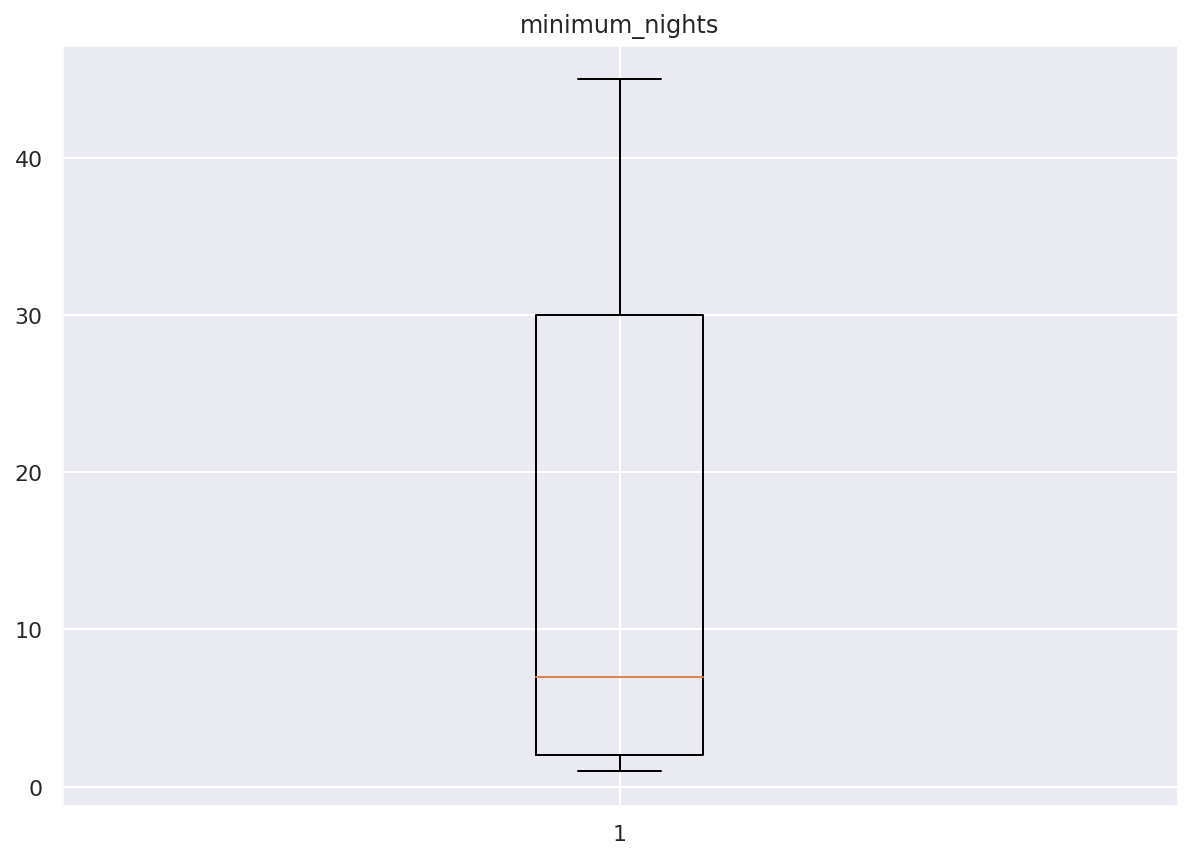

In [ ]:
# Capping
capping('minimum_nights',df_listing,0.0,0.98)

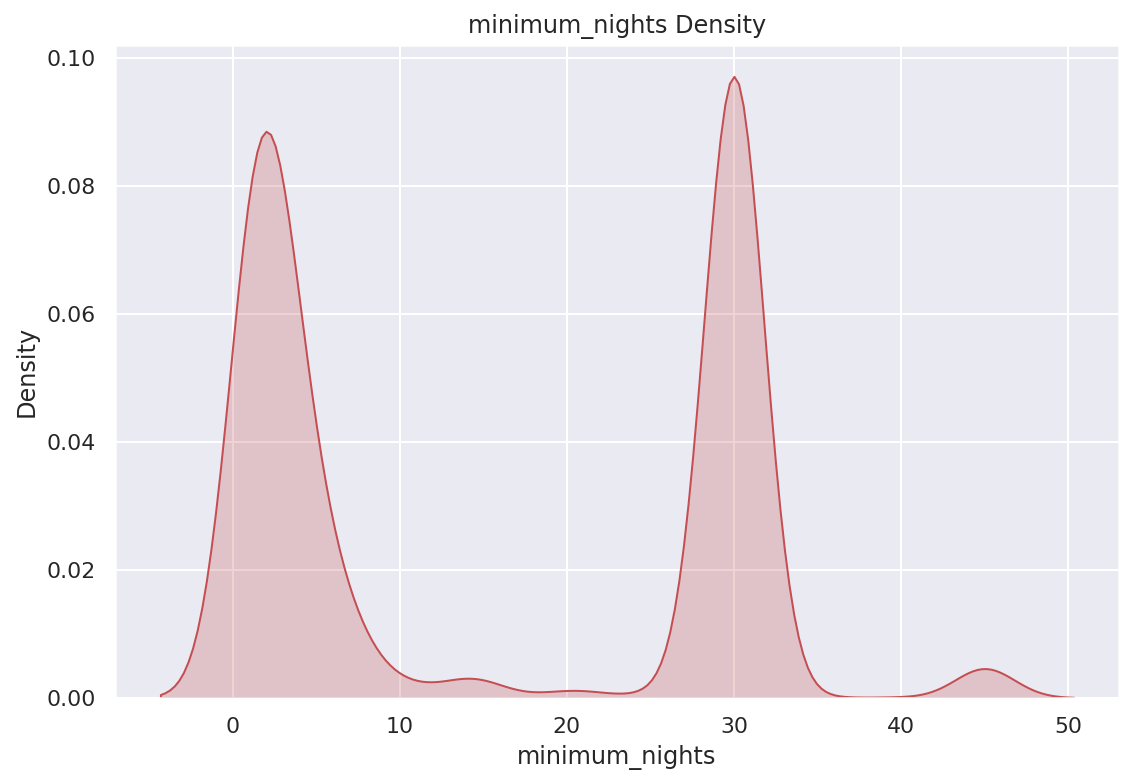

In [ ]:
kde('minimum_nights',df_listing,'minimum_nights')

Looking much better now.

 `maximum_nights`

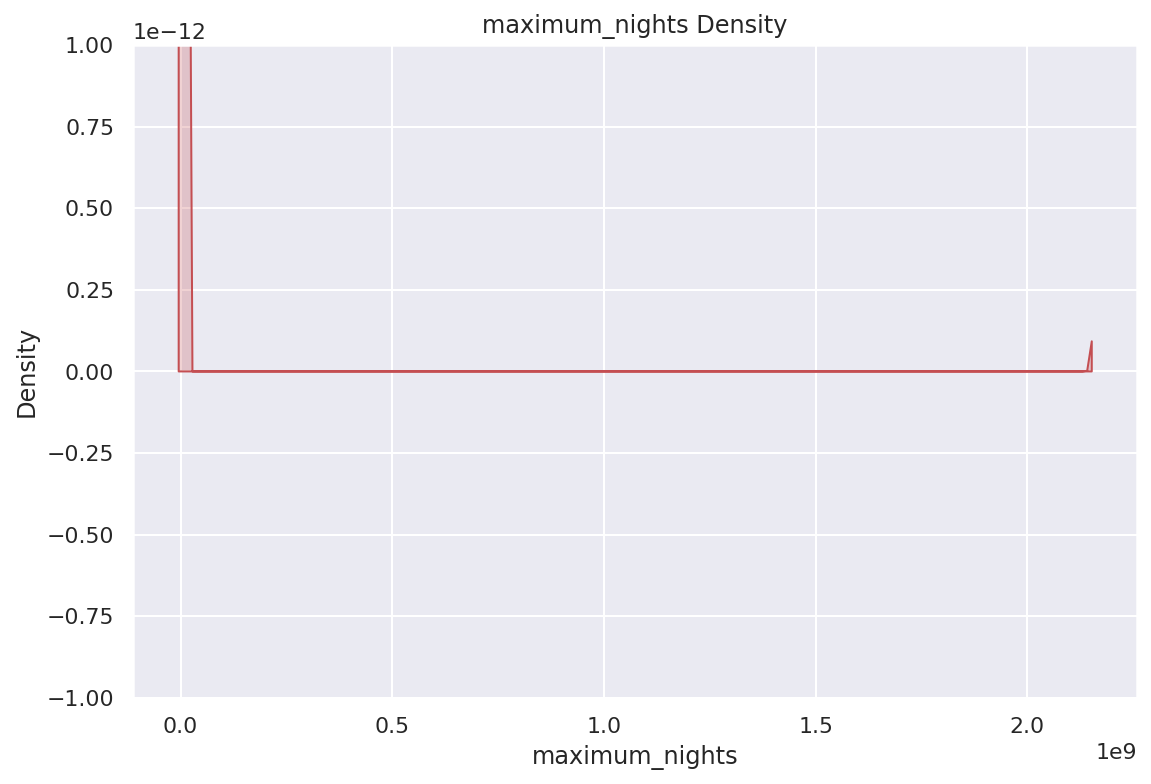

In [ ]:
kde('maximum_nights',df_listing,'maximum_nights')

In [ ]:
df_outliers('maximum_nights',df_listing)

       maximum_nights
count    7.000000e+00
mean     3.125034e+08
std      8.092051e+08
min      9.999000e+03
25%      9.999500e+03
50%      1.000000e+04
75%      2.000000e+07
max      2.147484e+09


In [ ]:
# Let's eliminate the outstanding outlier which is 3000.
df_listing=df_listing[df_listing.maximum_nights<3000]

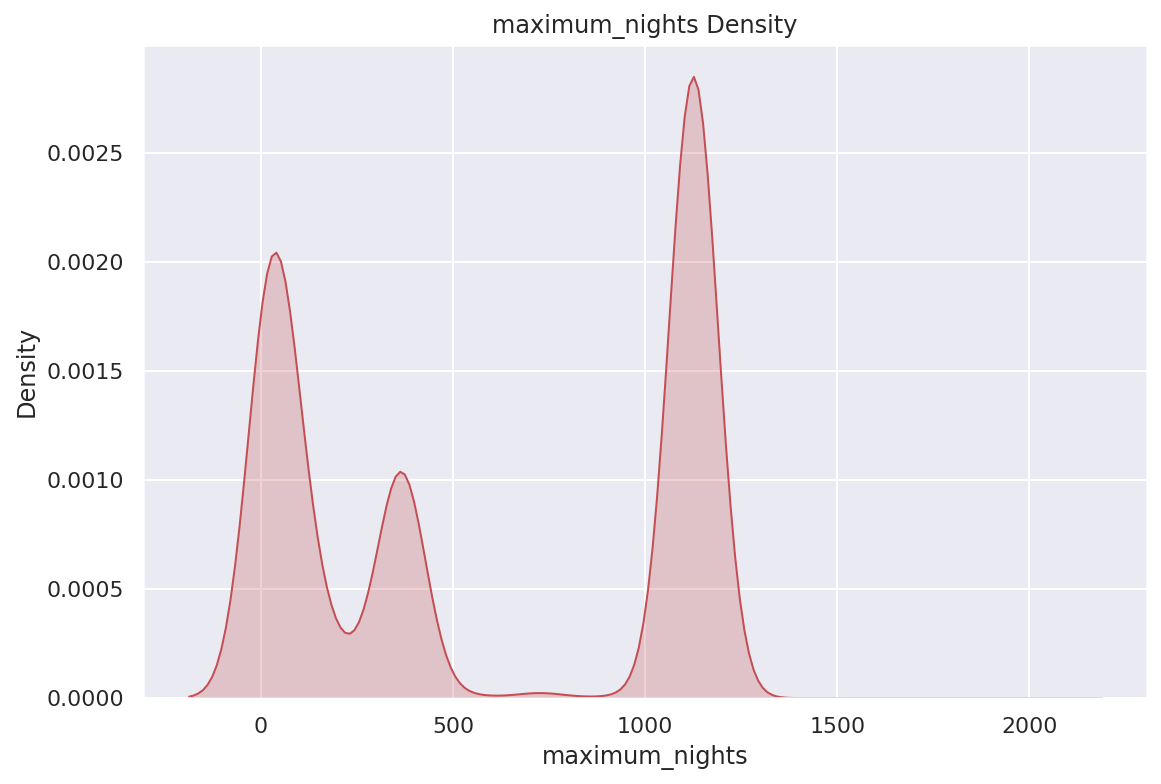

In [ ]:
kde('maximum_nights',df_listing,'maximum_nights')

In [ ]:
df_listing.maximum_nights.isna().sum()

0

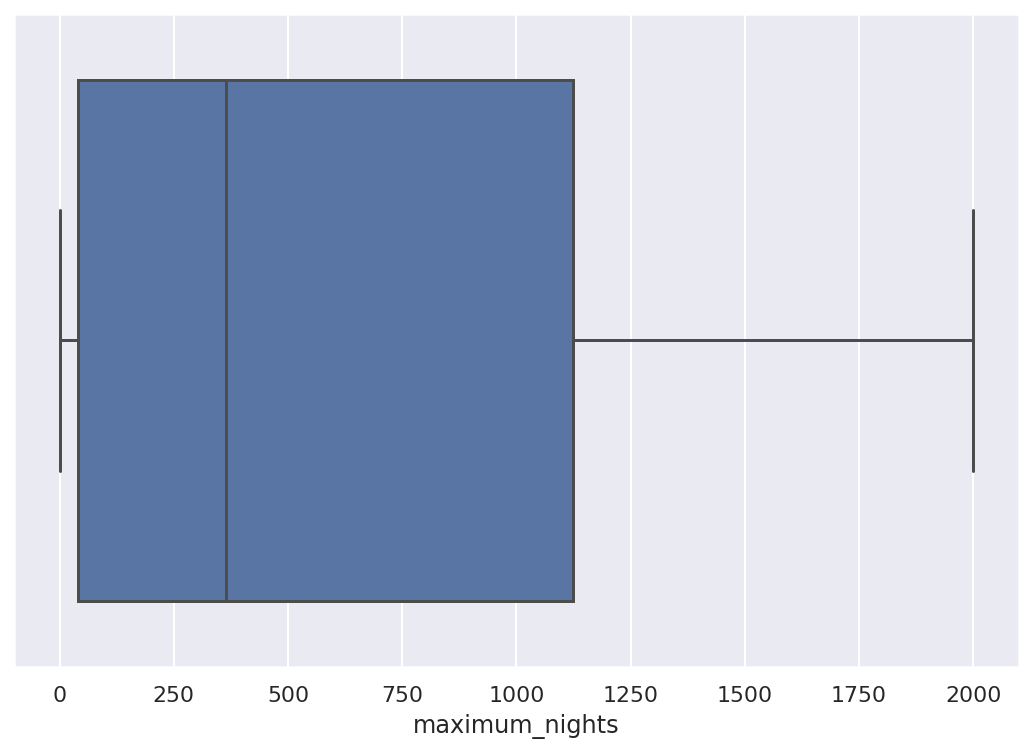

In [ ]:
sns.boxplot(x=df_listing.maximum_nights,data=df_listing)

Everything seems perfect after removing the one outlier which was 3000.

**29.** `host_verifications`: There are empty and None rows. After we ensured that the other host and reviews of these rows are NaN/missing values too, we have decided to drop the 10 rows.

In [ ]:
# Check missing values
df_listing.host_verifications.isna().sum()

0

In [ ]:
# Quick look at host_verification column
df_listing.host_verifications.value_counts()

['email', 'phone']                  24673
['email', 'phone', 'work_email']     4123
['phone']                            2448
['phone', 'work_email']                93
['email']                              37
[]                                     10
Name: host_verifications, dtype: int64

We see that almost all hosts are being verified via phone number but we can check if a host is being verified via work_email so the companies may charge higher prices than a host who is renting her/his private room.

In [ ]:
# Number of listings which were verified via phone
df_listing['host_phone_verification']=np.where(df_listing['host_verifications'].str.contains('phone'),1,0)

df_listing['host_phone_verification'].value_counts()

1    31337
0       47
Name: host_phone_verification, dtype: int64

In [ ]:
# Number of listings which were verified via personal email

df_listing['host_email_verification']=np.where(df_listing['host_verifications'].str.contains('email'),1,0)

df_listing['host_email_verification'].value_counts()

1    28926
0     2458
Name: host_email_verification, dtype: int64

In [ ]:
# Number of listings which were verified via work email

df_listing['host_work_email_verification']=np.where(df_listing['host_verifications'].str.contains('work_email'),1,0)

df_listing['host_work_email_verification'].value_counts()

0    27168
1     4216
Name: host_work_email_verification, dtype: int64

In [ ]:
df_listing['host_work_email_verification'].isna().sum()

0

We will create a new column to identify whether listings verified via work email because we believe that the price may vary when the rental property is listed by professional companies or individuals. We can drop the original `host_verifications` ,`host_phone_verification`, `host_identity_verified` and `host_email_verification`columns:

In [ ]:
df_listing=df_listing.drop(columns=['host_verifications','host_phone_verification','host_email_verification','host_identity_verified'],axis=1)


In [ ]:
# Sanity check
df_listing.columns

Index(['id', 'name', 'description', 'host_id', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'host_since_months', 'total_host_listing_more_than_1',
       'listing_per_neighborhood', 'shared_bathroom', 'bathroom_number',
       'bathroom_more_than_1', 'first_review_week', 'last_review_week',
       'host_work_email_verification'],
      d

Export the dataframe for Tablaeu visualization:

In [ ]:
df_listing.to_csv('/content/drive/My Drive/df_recommender.csv', encoding='utf-8', index=False)

**30.** `neighbourhood_cleansed`: This columns involves more than 250 values so we are going to group some of the neighborhoods and create new columns from it, instead.

Neighborhoods with the highest number of listings are Midtown, Hell's Kitchen,Harlem, Upper West and East Sides. 

In [ ]:
# Filter only manhattan neighbourhoods
df_manhattan=df_listing[df_listing.neighbourhood_group_cleansed=='Manhattan'][['neighbourhood_cleansed','number_of_reviews','review_scores_location','latitude','longitude']]
df_manhattan.neighbourhood_cleansed[df_manhattan.number_of_reviews==0].value_counts()

Midtown                300
Hell's Kitchen         207
Harlem                 169
Upper West Side        163
Upper East Side        139
Chelsea                 77
Financial District      75
East Harlem             63
Lower East Side         63
West Village            59
Theater District        59
Murray Hill             57
East Village            47
Kips Bay                43
Inwood                  39
Washington Heights      32
Tribeca                 27
SoHo                    14
Ellis Island            12
Chinatown               12
Gramercy                12
Central Park            10
Little Italy             8
Morningside Heights      8
Stuyvesant Town          7
Greenwich Village        7
Flatiron District        6
Battery Park City        6
Nolita                   4
NoHo                     4
Two Bridges              2
Roosevelt Island         1
Civic Center             1
Name: neighbourhood_cleansed, dtype: int64

In [ ]:
len(df_manhattan.neighbourhood_cleansed.unique())

34

In [ ]:
df_manhattan.neighbourhood_cleansed.unique()

array(['Midtown', 'Upper West Side', 'Morningside Heights', 'East Harlem',
       "Hell's Kitchen", 'East Village', 'Lower East Side',
       'Upper East Side', 'Washington Heights', 'Chelsea', 'Kips Bay',
       'Harlem', 'West Village', 'Tribeca', 'Flatiron District',
       'Chinatown', 'Greenwich Village', 'Nolita', 'Murray Hill',
       'Central Park', 'Gramercy', 'Financial District',
       'Theater District', 'Little Italy', 'SoHo', 'Inwood',
       'Battery Park City', 'Two Bridges', 'Ellis Island', 'NoHo',
       'Civic Center', 'Roosevelt Island', 'Stuyvesant Town',
       'Marble Hill'], dtype=object)

We will eliminate Ellis Island and Marble Hill which include only fewer rental places. We believe that it is hard to group them with other neighborhoods due to their geographic locations.


In [ ]:
df_listing=df_listing[df_listing.neighbourhood_cleansed!='Ellis Island||Marble Hill']
df_manhattan.neighbourhood_cleansed.unique()

array(['Midtown', 'Upper West Side', 'Morningside Heights', 'East Harlem',
       "Hell's Kitchen", 'East Village', 'Lower East Side',
       'Upper East Side', 'Washington Heights', 'Chelsea', 'Kips Bay',
       'Harlem', 'West Village', 'Tribeca', 'Flatiron District',
       'Chinatown', 'Greenwich Village', 'Nolita', 'Murray Hill',
       'Central Park', 'Gramercy', 'Financial District',
       'Theater District', 'Little Italy', 'SoHo', 'Inwood',
       'Battery Park City', 'Two Bridges', 'Ellis Island', 'NoHo',
       'Civic Center', 'Roosevelt Island', 'Stuyvesant Town',
       'Marble Hill'], dtype=object)

In [ ]:
#Manhattan neighborhood groups

# Filter and create a new column based on the list above
df_listing['neigh_harlem_manhattan']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('harlem|morningside heights|hamilton heights|washington heights|fort george|inwood'),1,0)


In [ ]:
df_listing['neigh_harlem_manhattan'].value_counts()

0    28454
1     2930
Name: neigh_harlem_manhattan, dtype: int64

In [ ]:
#Manhattan neighborhood groups


 # Filter and create a new column based on the list above
df_listing['neigh_central_park_manhattan']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('central park|upper west side|yorkville|upper east side|rosevelt island|lincoln square|lenox hill'),1,0)


# kitchen refers to hell's kitchen
Manhattan_middle_list=['clinton','midtown','turtle bay','theater district','kitchen','garment district','kips bay','murray hill','gramercy park','sutton','beekman','tudor','stuyvesant','medical city']
df_listing['neigh_midtown_south_manhattan']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('union square|chelsea|hudson yards|garment district|greeley square|herald square|kips bay|koreatown|murray hill|rose hill|midtown south|nomad'),1,0)
df_listing['neigh_midtown_west_manhattan']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('kitchen|theater district'),1,0)
df_listing['neigh_midtown_east_manhattan']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('midtown|turtle bay|sutton|medical city|roosevelt island'),1,0)


# Filter and create a new column based on the list above
df_listing['neigh_lower_manhattan']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('flatiron|gramercy|ellis island|stuyvesant town|meat packing district|west village|greenwich village|noho|east village|alphabet city|bowery|lower east side|little italy|nolita|soho|hudson square|chinatown|two bridges|tribeca|civic center|south street seaport|battery park city|financial district|southern tip|wall street|white hall'),1,0)

Filter Brooklyn neighborhoods, which are closer to Manhattan area where tourists spend their time:

In [ ]:
df_listing['neigh_closer_brooklyn']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('dumbo|brooklyn heights|downtown brooklyn|clinton hill|navy yard|williamsburg|greenpoint|cobble hill|boerum hill|fort greene|carroll gardens|red hook|gowanus|park slope|prospect park|prospect heights|boerum hill|sunset park|greenwood cementry|windsor terrace'),1,0)

Filter Queens and Bronx neighborhoods which are closer to Manhattan area where tourists spend their time:

In [ ]:
temp=df_listing[df_listing.neighbourhood_group_cleansed=='Queens']

In [ ]:
temp.groupby('neighbourhood_cleansed').mean()[['price','listing_per_neighborhood']].sort_values(by='price',ascending=False)

price  listing_per_neighborhood
neighbourhood_cleansed                                            
Broad Channel                 356.000000                       2.0
Neponsit                      272.000000                       2.0
Belle Harbor                  237.666667                       6.0
Rockaway Park                 211.656250                      64.0
Arverne                       199.725275                      91.0
Rockaway Beach                191.762712                      59.0
Jamaica Estates               189.423077                      26.0
LaGuardia Airport             188.000000                       1.0
Little Neck                   180.800000                       5.0
Far Rockaway                  178.304348                      46.0
Edgemere                      174.466667                      15.0
Long Island City              162.321429                     364.0
Whitestone                    160.416667                      12.0
Bayside                       151.466667                      60.0
Middle Village                150.777778                      27.0
Breezy Point                  150.000000                       3.0
Jamaica Hills                 146.909091                      11.0
Bellerose                     145.615385                      13.0
Forest Hills                  142.770115                      87.0
Springfield Gardens           137.840336                     119.0
South Ozone Park              135.490566                      53.0
Howard Beach                  133.347826                      23.0
Fresh Meadows                 132.178571                      28.0
St. Albans                    130.137931                      87.0
Bay Terrace                   127.250000                       4.0
Cambria Heights               127.071429                      56.0
Glendale                      126.645833                      48.0
College Point                 126.363636                      33.0
Jamaica                       126.059289                     253.0
Rosedale                      123.631579                     114.0
Briarwood                     121.675676                      37.0
Kew Gardens Hills             117.590909                      22.0
East Elmhurst                 116.391534                     189.0
Maspeth                       115.188235                      85.0
Corona                        114.829787                      47.0
Ditmars Steinway              114.763158                     228.0
Richmond Hill                 112.103093                      97.0
Ozone Park                    111.750000                      60.0
Bayswater                     111.562500                      16.0
Ridgewood                     111.160173                     231.0
Queens Village                107.112500                      80.0
Floral Park                   102.375000                       8.0
Flushing Meadows Corona Park  101.625000                       8.0
Laurelton                      99.535714                      56.0
Kew Gardens                    97.500000                      36.0
Astoria                        97.149446                     542.0
Rego Park                      96.155556                      90.0
Flushing                       95.744292                     438.0
Woodhaven                      93.492754                      69.0
Sunnyside                      93.255061                     247.0
Forest Park                    91.642857                      14.0
Douglaston                     86.666667                       6.0
Jackson Heights                84.625000                     192.0
Hollis                         84.285714                      21.0
Woodside                       82.536723                     354.0
Holliswood                     79.000000                       1.0
Elmhurst                       78.647321                     224.0

In [ ]:

# Filter and create a new column based on the list above
df_listing['neigh_closer_queens']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('long island city|astoria|ravenswood|hunters point'),1,0)


# Filter and create a new column based on the list above
df_listing['neigh_closer_bronx']=np.where(df_listing.neighbourhood_cleansed.str.lower().str.contains('port morris|mott haven|marble hill|mt eden|concourse|melrose|woodstock|longwood'),1,0)



In [ ]:
# Let's drop the original column
df_listing=df_listing.drop('neighbourhood_cleansed',axis=1)


Let's continue checking the missing values:

In [ ]:
df_missing=df_listing.isna().sum().to_frame(name="Missing Values").sort_values(by='Missing Values', ascending=False)
round(df_missing[df_missing['Missing Values']>0]/len(df_listing),2)

Missing Values
description            0.02
name                   0.00

We are going to fill the missing values with unknown in `description` and `name` columns: 

In [ ]:
# Fill NaN as unknown
df_listing.name=df_listing.name.fillna('unknown')
df_listing.description=df_listing.description.fillna('unknown')

---

In [ ]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31384 entries, 0 to 33302
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              31384 non-null  int64   
 1   name                            31384 non-null  object  
 2   description                     31384 non-null  object  
 3   host_id                         31384 non-null  int64   
 4   host_location                   31384 non-null  int64   
 5   host_response_time              31384 non-null  object  
 6   host_response_rate              31384 non-null  object  
 7   host_acceptance_rate            31384 non-null  category
 8   host_is_superhost               31384 non-null  float64 
 9   host_thumbnail_url              31384 non-null  object  
 10  host_picture_url                31384 non-null  object  
 11  neighbourhood_group_cleansed    31384 non-null  object  
 12  latitude          

In [ ]:
# Drop text and unnecessary columns

df_listing=df_listing.drop(['host_location','id','host_id','bathroom_number','host_thumbnail_url','host_picture_url','latitude','longitude'],axis=1)


#### **Preventing Multicollinearity Issue:** 

In [ ]:
# Select only numerical columns
df_listing_num=df_listing.select_dtypes(include='number')

In [ ]:
df_listing_num.columns

Index(['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month', 'host_since_months',
       'total_host_listing_more_than_1', 'listing_per_neighborhood',
       'shared_bathroom', 'bathroom_more_than_1', 'first_review_week',
       'last_review_week', 'host_work_email_verification',
       'neigh_harlem_manhattan', 'neigh_central_park_manhattan',
       'neigh_midtown_south_manhattan', 'neigh_midtown_west_manhattan',
       'neigh_midtown_east_manhattan', 'neigh_lower_manhattan',
       'neigh_closer_brooklyn', 'neigh_closer_queens', 'neigh_closer_bronx'],
      dtype='object')

Method I: Variance inflation factor (VIF) helps us to measure of the amount of multicollinearity in each feature. The features with the value of more than 10 should be eliminated.  

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_listing_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_listing_num.values, i) for i in range(len(df_listing_num.columns))]


In [ ]:
# Reset index
vif_num=vif_data.reset_index(drop=True)

In [ ]:
# Filter columns whose VIF value is over 10
vif_num[vif_num.VIF>10]

feature         VIF
1                  accommodates   15.828051
2                      bedrooms   16.618701
3                          beds   16.411320
10         review_scores_rating  360.696082
11       review_scores_accuracy  460.527438
12    review_scores_cleanliness  215.635160
13        review_scores_checkin  400.037169
14  review_scores_communication  406.901447
15       review_scores_location  246.690375
16          review_scores_value  394.160427

In [ ]:
# Check if there is NaN VIF value
vif_num[vif_num.VIF.isna()]

Empty DataFrame
Columns: [feature, VIF]
Index: []

According to VIF table, we need to drop all the review related columns but we will keep at least the most important one which is `review_score_value` because this review is given based on the price and value the visitors gained during their stay.

---

Method II: A Correlation Matrix Heat Map: 
 We will keep our threshold as 60%.


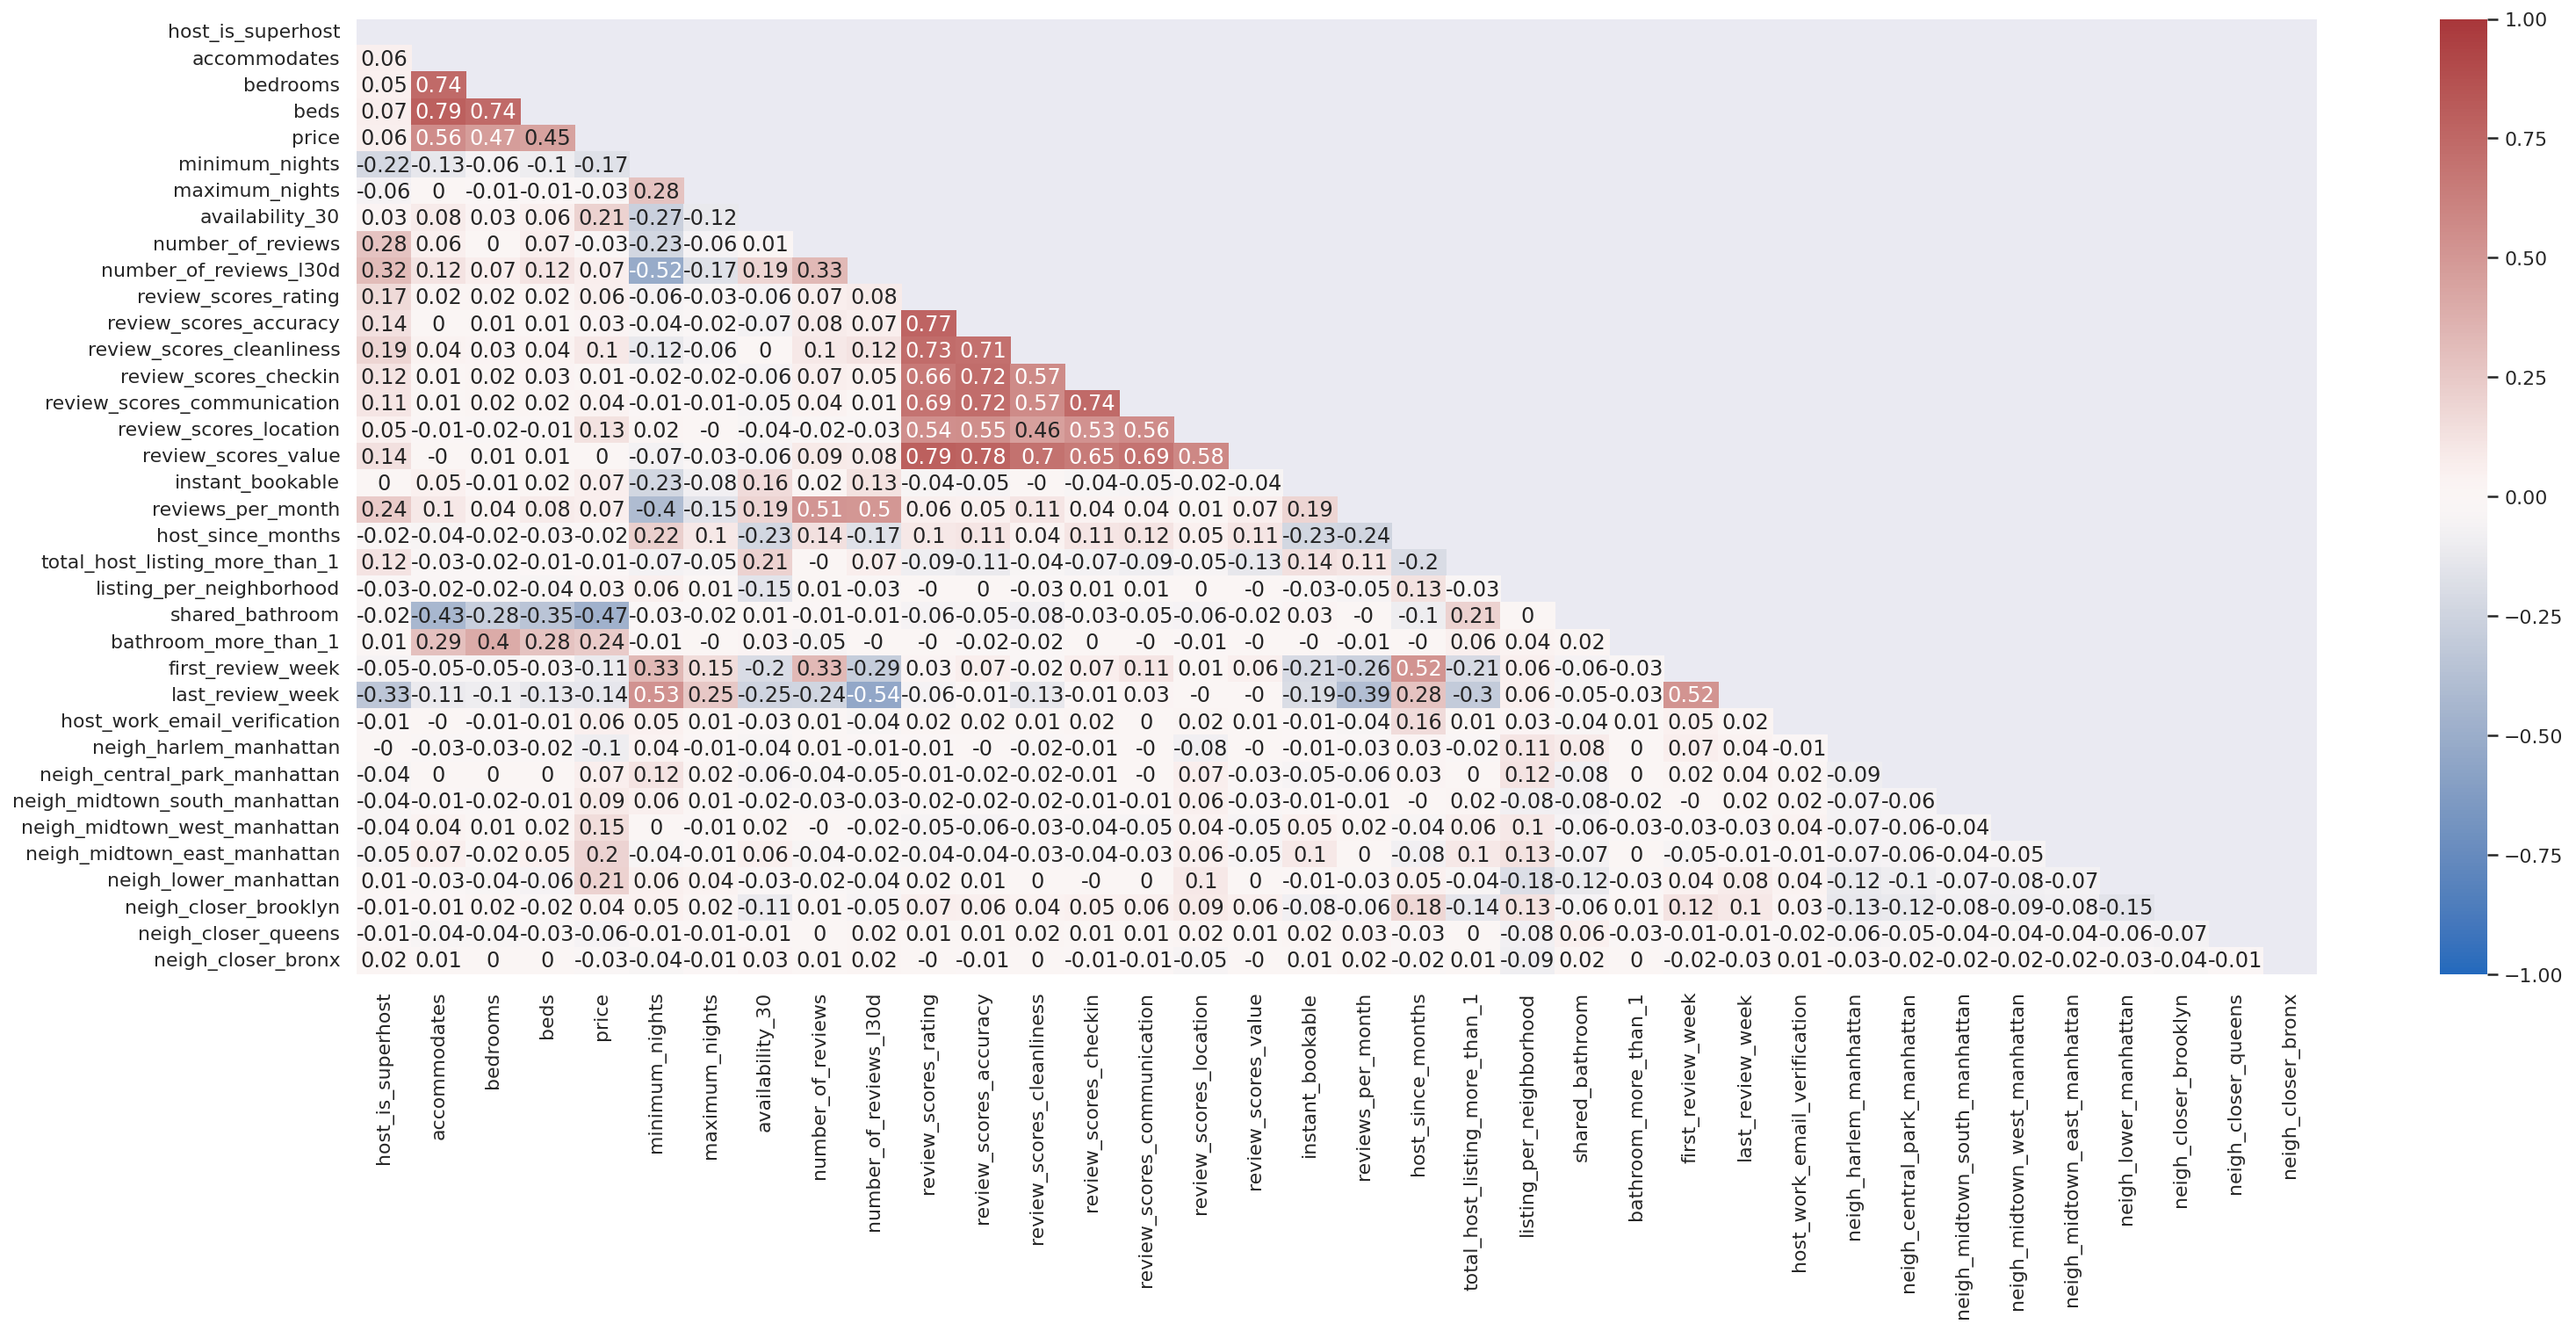

In [ ]:
matrix = df_listing.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(25,10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

We will keep our threshold at 60% to avoid losing important data.

- Among the numerical variables, the following features seem to be moderately or highly correlation with the target value/price:
  - `shared_bathroom`,`accommodates`,`bedrooms`, and `beds`

- Beds-Bedrooms-Accommodates columns are highly correlated in a positive way. We are going to drop beds and bedrooms because we think accommodates column is more crucial when predicting the price.

- Shared bathroom tends to have a negative correlation with price which is expected too. 

- First and last_review_week seem to be moderately correlated with availability and minimum and maximum required nights but we will keep them for now. 

- We may drop first_review_week due to its high correlation with host_since_months column. It was expected so we need only one of them. 

- Availibility columns are expected to be correlated too.

In [ ]:
# Drop the columns with high coefficiency


df_listing.drop(columns=['review_scores_accuracy','reviews_per_month'],inplace=True)

# Select numerical variables again
df_listing_num=df_listing.select_dtypes(include='number')

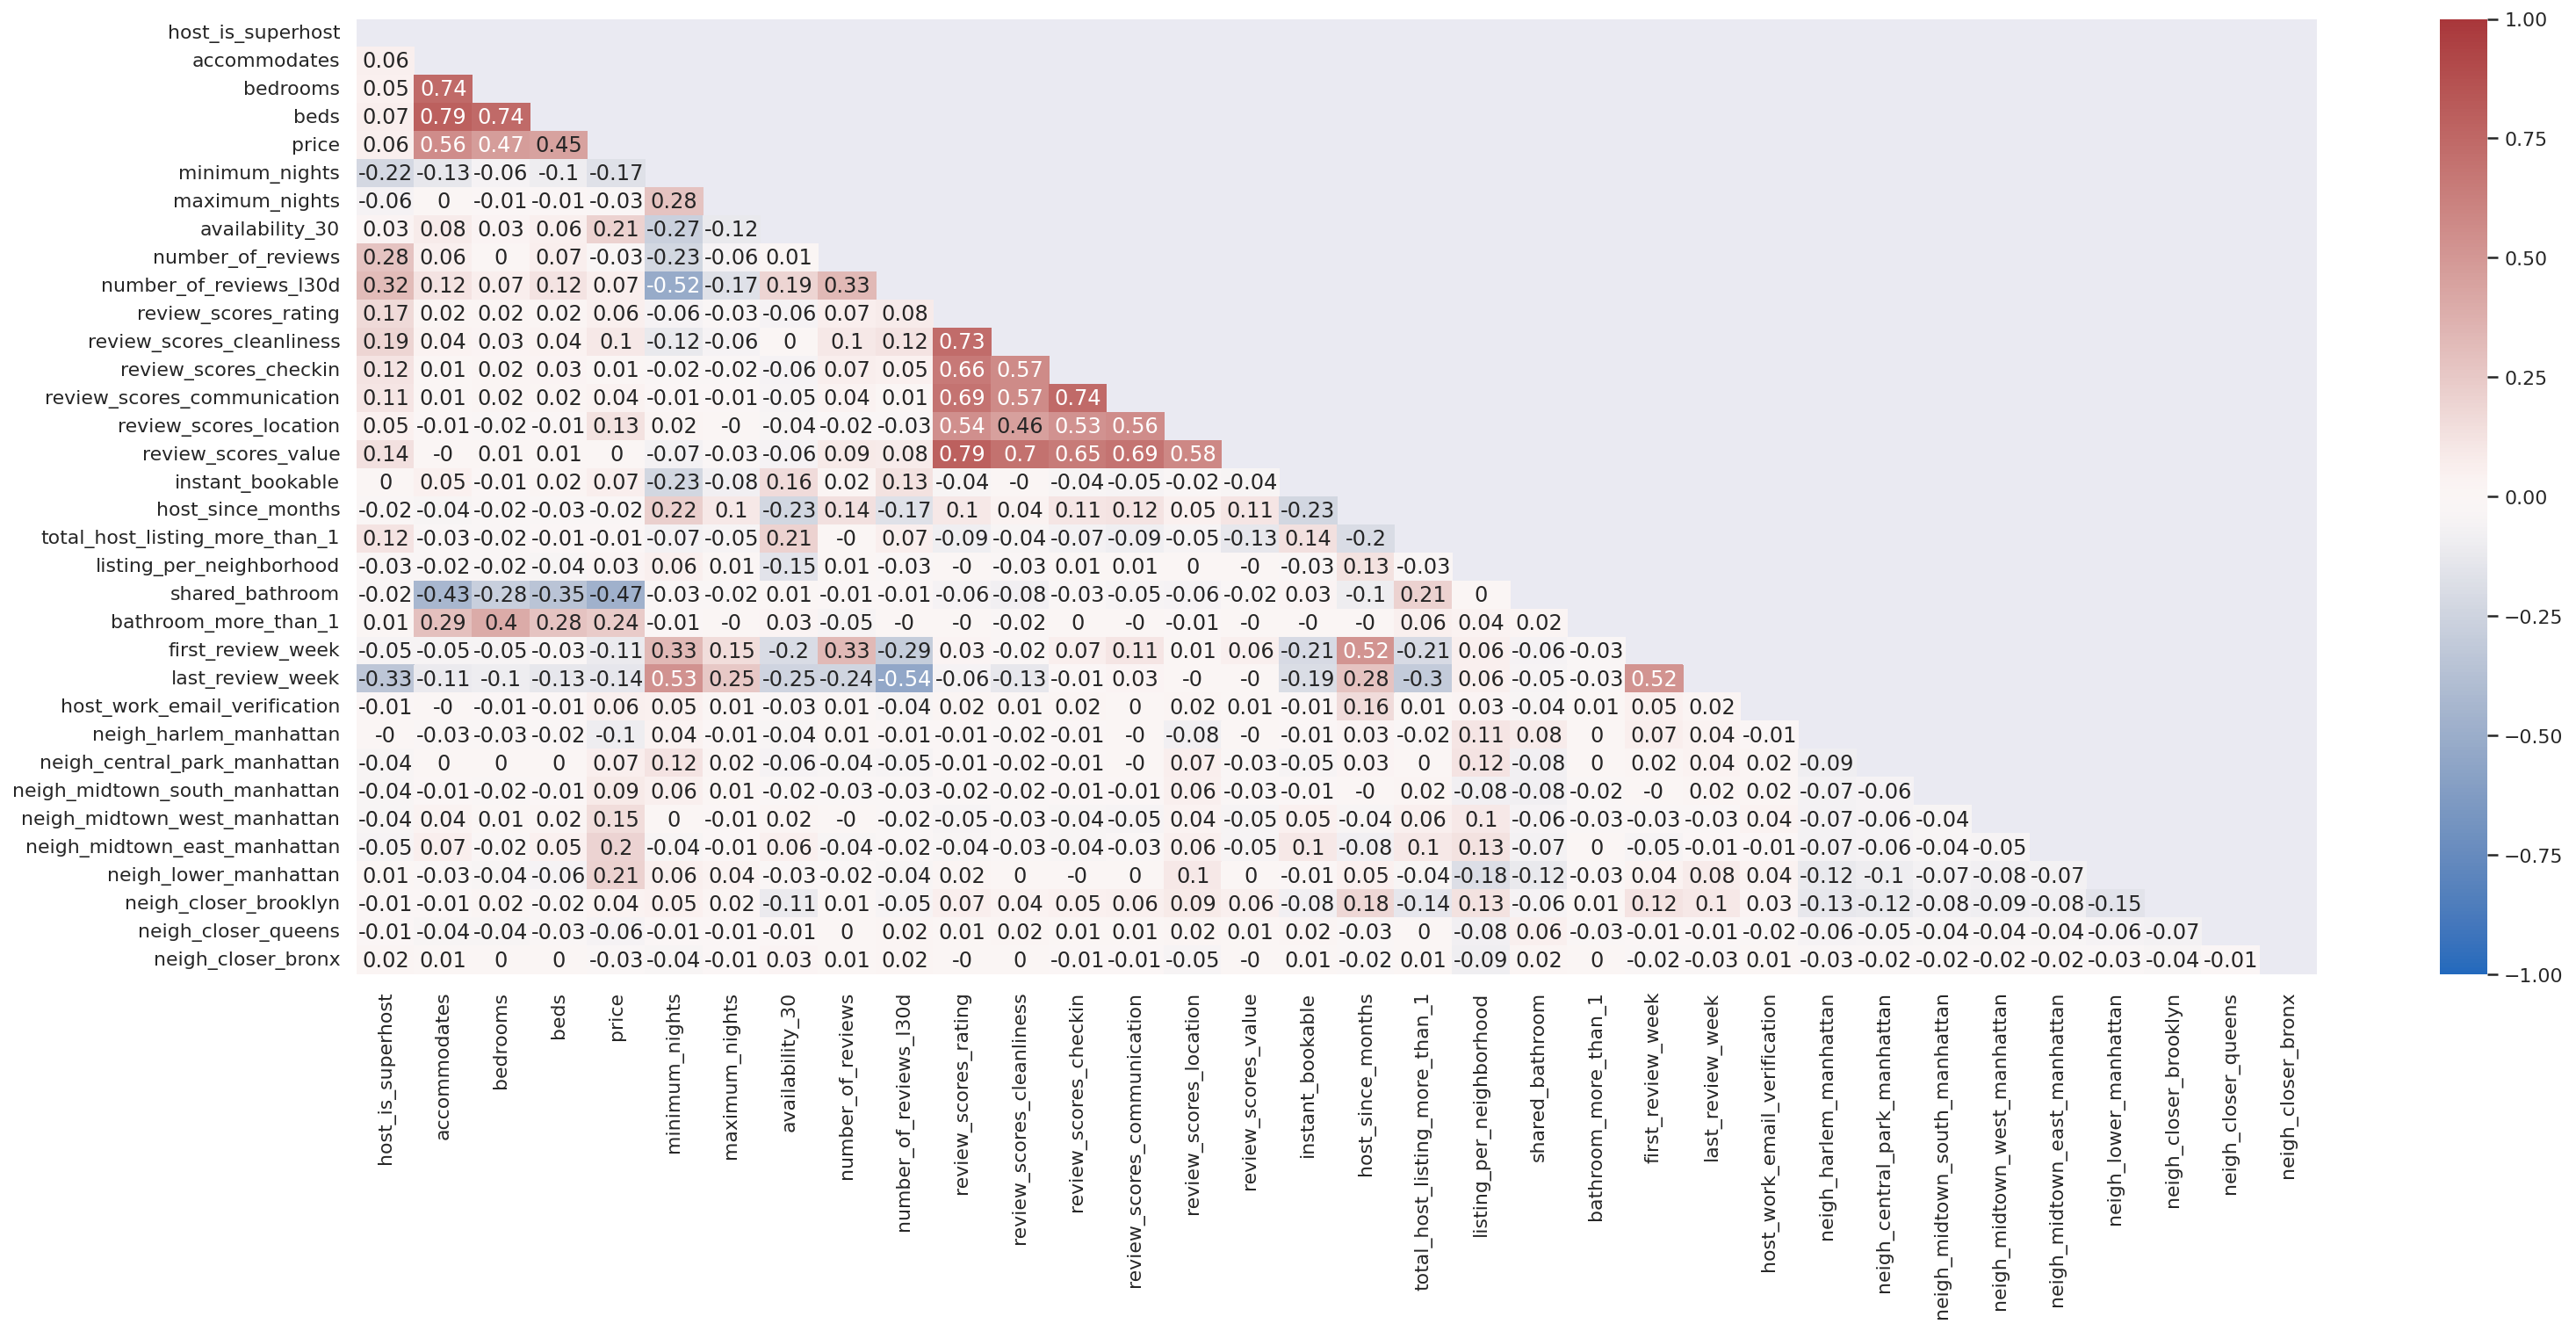

In [ ]:
matrix = df_listing_num.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(25,10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [ ]:
# Drop the columns with high coefficiency
df_listing.drop(columns=['review_scores_communication','review_scores_cleanliness','beds'],inplace=True)
df_listing_num=df_listing.select_dtypes(include='number')

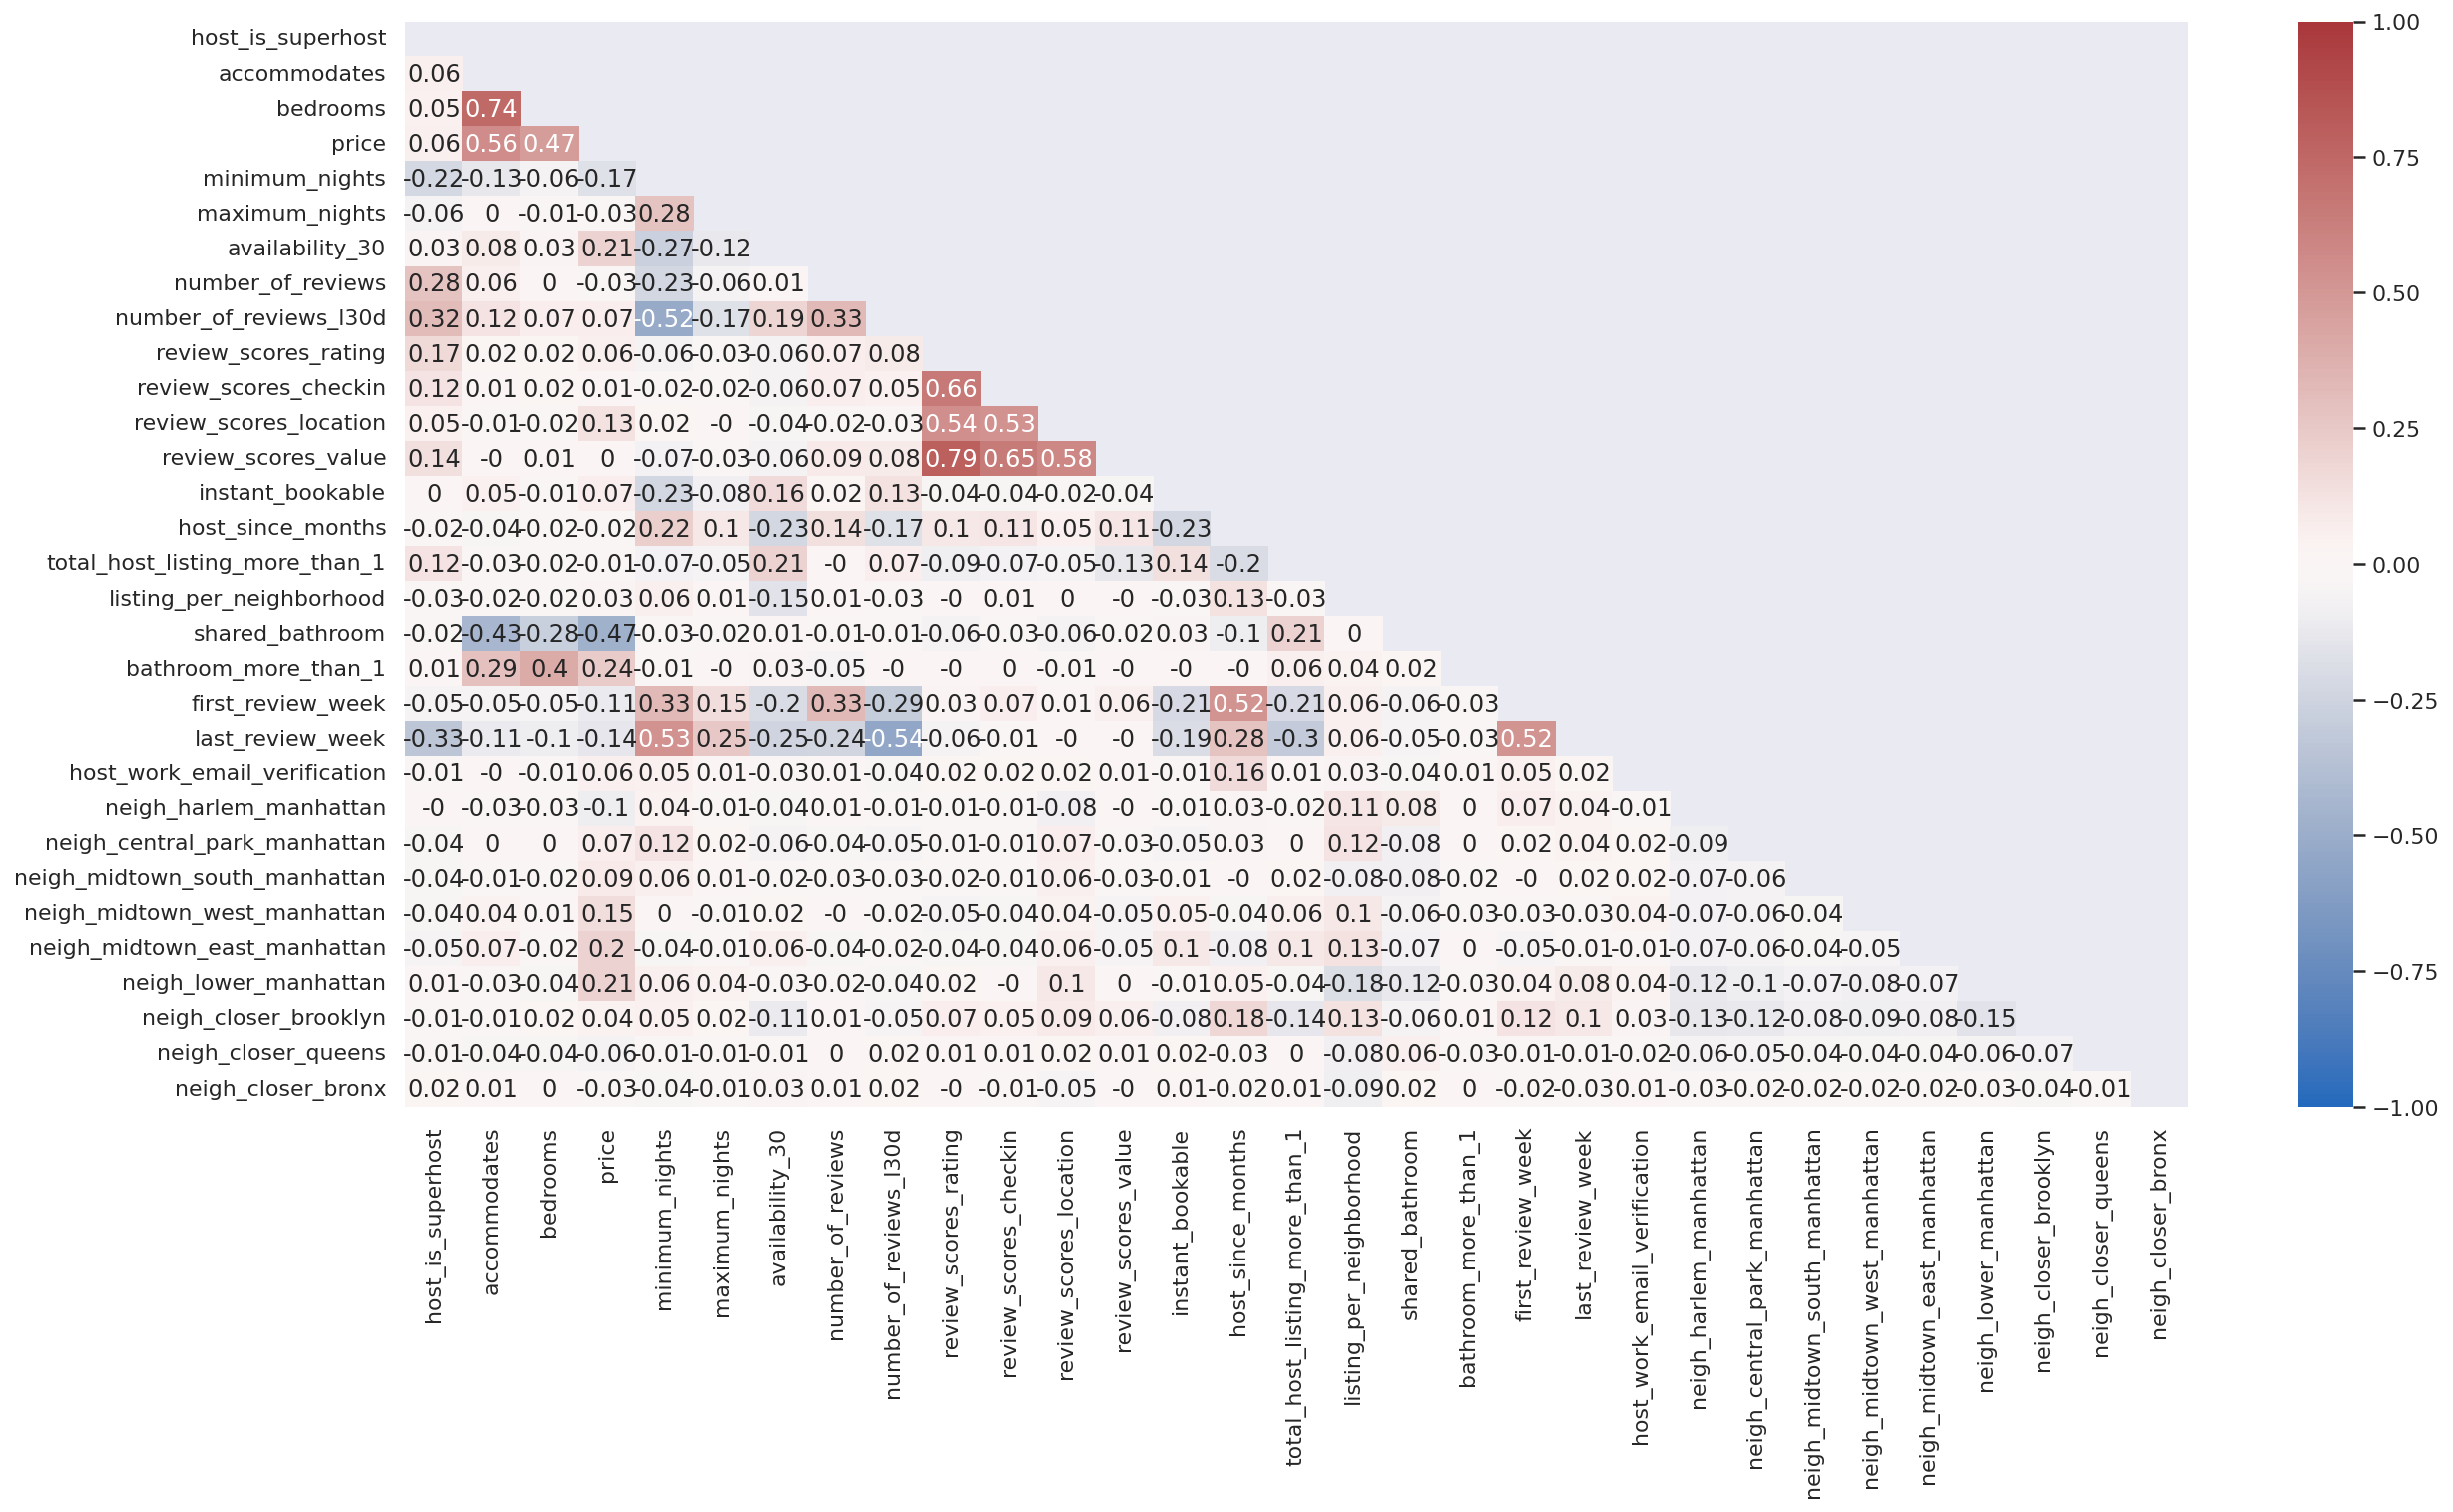

In [ ]:
matrix = df_listing_num.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [ ]:
# Drop the columns with high coefficiency
df_listing.drop(columns=['review_scores_checkin','first_review_week','last_review_week','bedrooms','review_scores_rating'],inplace=True)
df_listing_num=df_listing.select_dtypes(include='number')

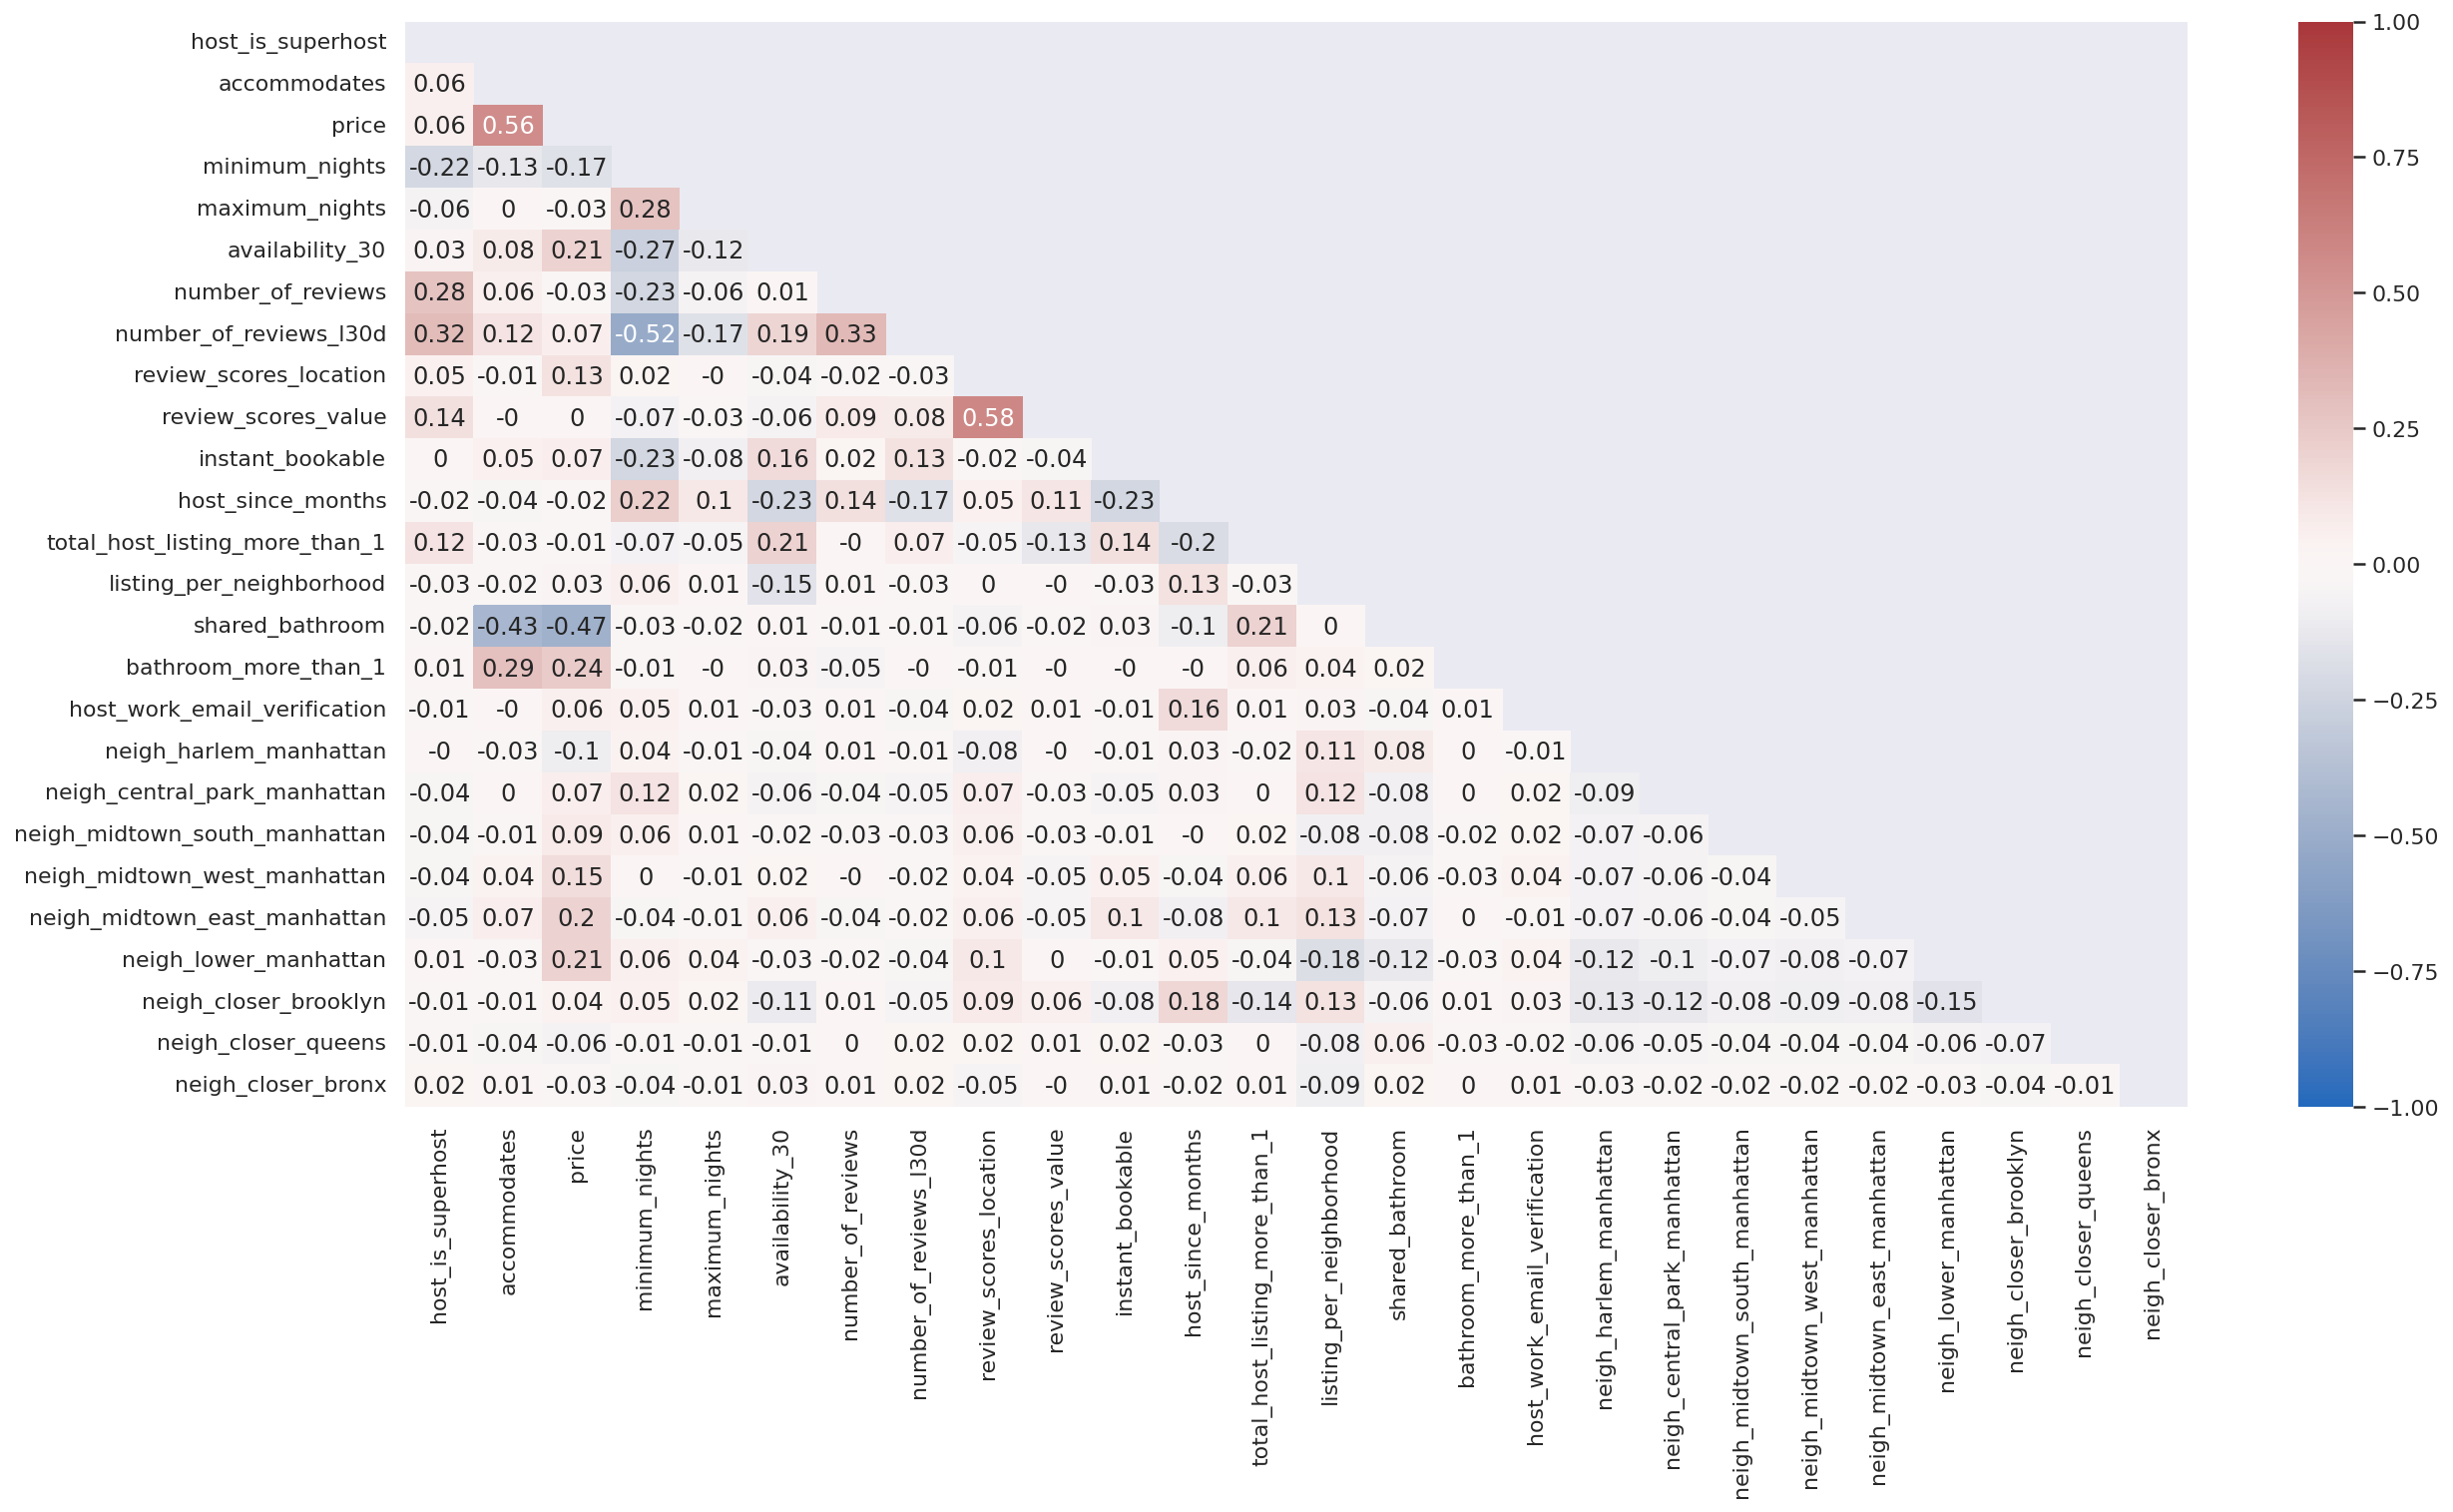

In [ ]:
matrix = df_listing_num.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_listing_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_listing_num.values, i) for i in range(len(df_listing_num.columns))]


In [ ]:
# Reset index
vif_num=vif_data.reset_index(drop=True)

In [ ]:
# Filter columns whose VIF value is over 10
vif_num[vif_num.VIF>10]

feature         VIF
8  review_scores_location  168.945954
9     review_scores_value  160.245895

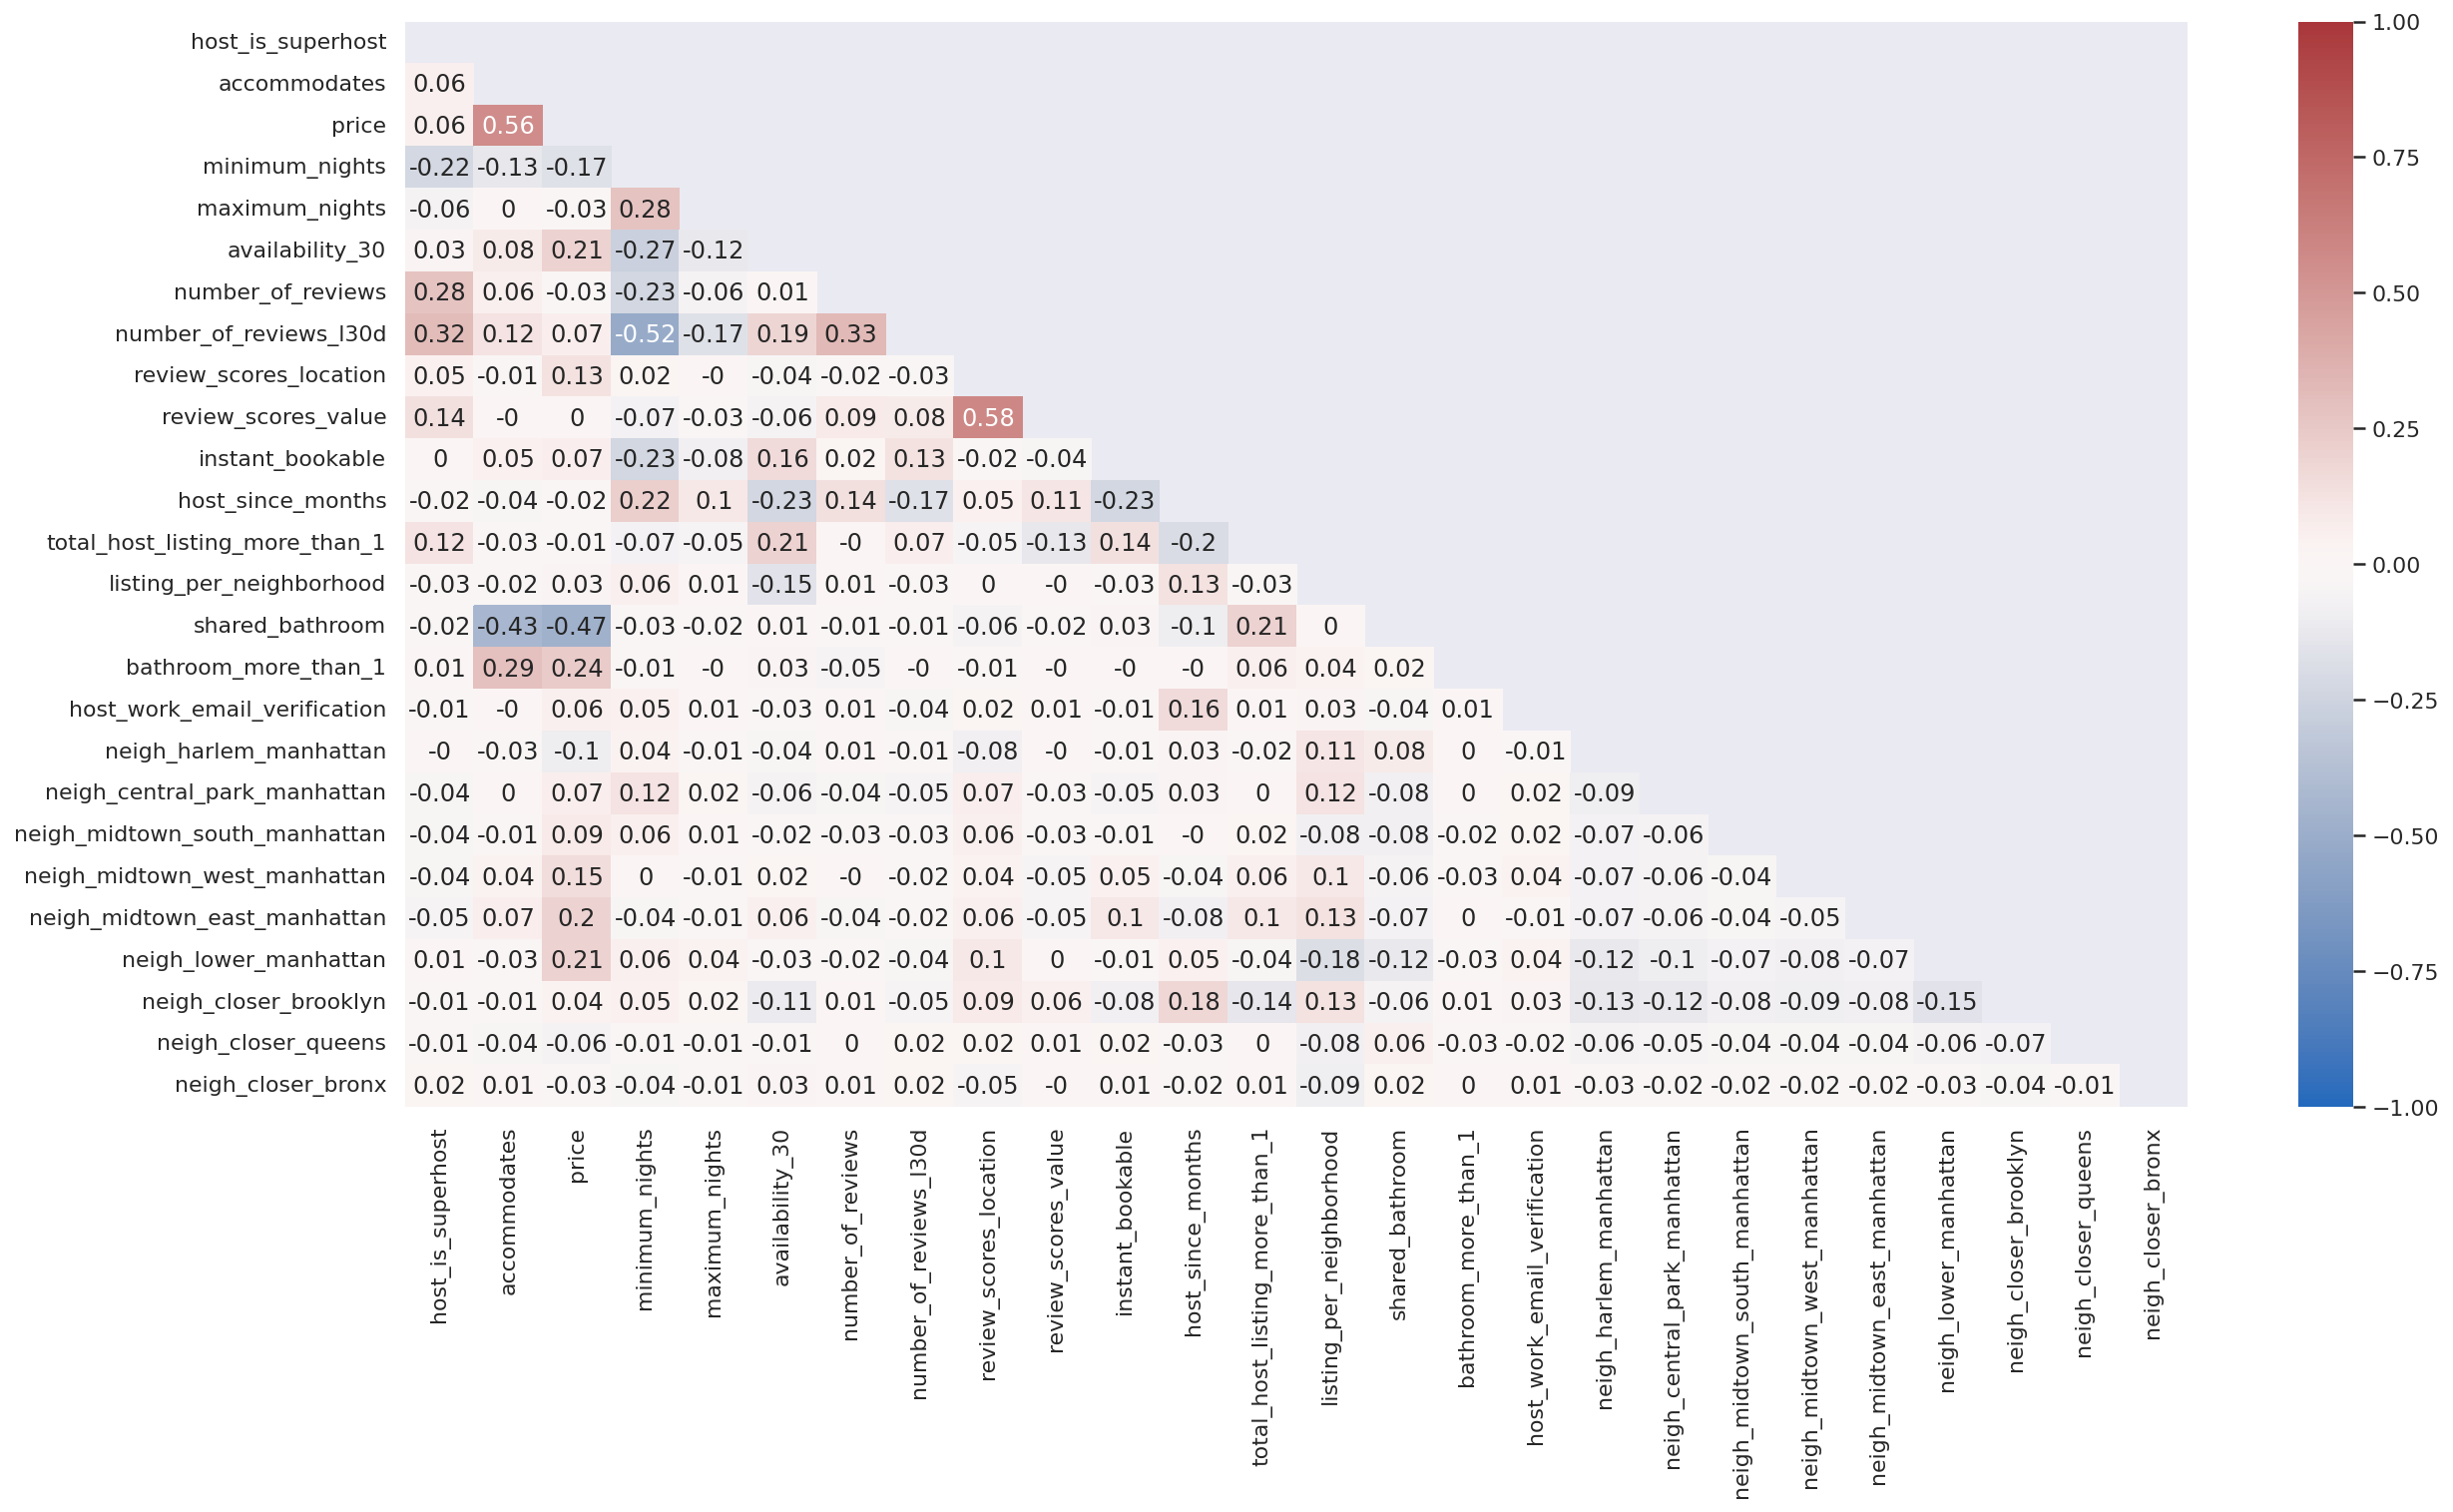

In [ ]:
matrix = df_listing_num.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

We may drop the features with coefficient higher than 50% in the next notebook.

For now, all columns except for  `accommodates` and `shared_bathroom` have more than 50% correlation with the target value.

In [ ]:
matrix[matrix['price']<-0.5].index

Index(['shared_bathroom'], dtype='object')

In [ ]:
matrix[matrix['price']>0.5].index

Index(['accommodates', 'price'], dtype='object')

In [ ]:
print(f'Final dataset shape is {df_listing.shape}')

Final dataset shape is (31384, 34)


EXPORT PREPROCESSED DATASETS:

In [ ]:
# Export preprocessed dataset capped outliers

df_listing.to_csv('/content/drive/My Drive/df_preprocessed_capped.csv', encoding='utf-8', index=False)

**Next Steps:**

- We will split our data into train and test datasets, do further feature engineering including encoding and transforming steps.
- The next notebook also includes analysis (basic modelling) about text-based columns.



---


Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 1 of 4